In [1]:
import fitz  # PyMuPDF
import pandas as pd
import numpy as np
import re
import os
from PIL import Image
import io
import matplotlib.pyplot as plt

In [2]:
pdf_file = '/Users/rodrigocarrillo/Library/CloudStorage/OneDrive-EmoryUniversity/Natural Language Processing Projects/Examen Residentado Peru/CONAREME/Year2020/PEDIATRIA.pdf'

In [3]:
def extract_questions(pdf_path):
    doc = fitz.open(pdf_path)
    questions_data = []  # List to store questions

    # Updated regular expression: handle questions with or without a '?'
    #question_pattern = re.compile(r"(\d+)\.\s(.*?)(?:\?)?\s*(?=A\.)", re.DOTALL)
    question_pattern = re.compile(r"(\d+)\.\s(.*?\??)\s*(?=A\.)", re.DOTALL)

    for page in doc:
        text = page.get_text("text")  # Extract full page text
        
        # Find all questions in the text using findall()
        questions = question_pattern.findall(text)
        
        # Append all the questions to the questions_data list
        for _, question in questions:
            questions_data.append(question.strip())  # Store the cleaned question text

    # Convert extracted questions to DataFrame
    questions_df = pd.DataFrame(questions_data, columns=["question"])
    return questions_df

In [4]:
def extract_answers(pdf_path):
    doc = fitz.open(pdf_path)
    answers_data = []  # List to store answers for each question

    # Regular expression for extracting answers
    answer_pattern = re.compile(r"^(A|B|C|D|E)\.\s(.+)", re.MULTILINE)

    for page in doc:
        text = page.get_text("text")  # Extract full page text
        lines = text.split("\n")  # Split into lines for structured parsing

        current_answers = []  # List to store answers for a given question
        for line in lines:
            answer_match = answer_pattern.match(line)
            if answer_match:
                opt, ans_text = answer_match.groups()
                current_answers.append(ans_text.strip())

            # After four options are found, store them as one row in answers_data
            if len(current_answers) == 5:
                answers_data.append(current_answers)
                current_answers = []  # Reset for next question

    # Convert extracted answers to DataFrame with four columns
    answers_df = pd.DataFrame(answers_data, columns = ["option_A", "option_B", "option_C", "option_D", "option_E"])
    return answers_df

In [5]:
def get_largest_rectangle(rects):
    """Return the largest rectangle from a list of rectangles."""
    if not rects:
        return None
    
    # Calculate area for each rectangle and store with index
    areas = [(abs((rect.br.x - rect.tl.x) * (rect.br.y - rect.tl.y)), idx) 
             for idx, rect in enumerate(rects)]
    
    # Sort by area (first element of tuple)
    areas.sort(key=lambda x: x[0], reverse=True)
    
    # Return the rectangle with largest area
    return rects[areas[0][1]]

def extract_correct_answers(pdf_path):
    doc = fitz.open(pdf_path)
    correct_answers = []
    missing_questions = []  # Track questions that were skipped
    
    # Flexible regex for answer choices (handles missing spaces like "A." and "A. ")
    answer_pattern = re.compile(r"^(A|B|C|D|E)\.\s(.+)", re.MULTILINE)
    
    for page_num, page in enumerate(doc, start=1):
        text = page.get_text("text")  # Extract full page text
        lines = text.split("\n")  # Split into lines
        
        # Extract valid answer positions using regex
        answer_positions = {key: [] for key in ["A", "B", "C", "D", "E"]}
        
        for line in lines:
            match = answer_pattern.match(line)
            if match:
                answer_letter, answer_text = match.groups()
                
                # Try different search variations to find the best match
                search_texts = [
                    match.group(0),  # Original matched text
                    match.group(0).strip(),  # Stripped version
                    answer_letter + '.' + answer_text,  # Without space after period
                    answer_letter.upper() + '. ' + answer_text,  # Different case
                ]
                
                rects = None
                used_search_text = ""
                
                # Find the first successful search
                for search_text in search_texts:
                    rects = page.search_for(search_text)
                    if rects:
                        used_search_text = search_text
                        break
                
                if rects:
                    # Select the largest rectangle
                    largest_rect = get_largest_rectangle(rects)
                    if largest_rect:
                        answer_positions[answer_letter].append(largest_rect)
        
        # Find the maximum number of questions on the page
        num_questions = max(len(answer_positions["A"]), len(answer_positions["B"]), len(answer_positions["C"]),
                          len(answer_positions["D"]), len(answer_positions["E"]))
        
        # Debugging: Show how many answers were found
        print(f"\nPage {page_num}: Found {num_questions} questions")
        
        for idx in range(num_questions):
            best_answer = None
            best_yellow_pixels = 0  # Track the highest number of yellow pixels
            has_all_options = True  # Flag to check if we have all 4 options
            
            for answer_letter in ["A", "B", "C", "D", "E"]:
                rects = answer_positions[answer_letter]
                if idx >= len(rects):
                    has_all_options = False  # Missing one or more options
                    continue
                
                rect = rects[idx]
                
                # Debugging: Print detected answer positions
                print(f"Page {page_num}, Q{idx+1} - {answer_letter}: Detected box: "
                      f"x0={rect.x0:.1f}, y0={rect.y0:.1f}, x1={rect.x1:.1f}, y1={rect.y1:.1f}")
                
                # Expand bounding box only to the right
                expanded_rect = fitz.Rect(rect.x0, rect.y0, rect.x1 + 50, rect.y1)
                
                # Extract pixels from the expanded region
                pixmap = page.get_pixmap(clip=expanded_rect)
                img = np.frombuffer(pixmap.samples, dtype=np.uint8).reshape(pixmap.h, pixmap.w, pixmap.n)
                
                # Count yellow pixels (pixels with high red and green, low blue)
                yellow_mask = (
                    (img[:, :, 0] > 200) &  # High red
                    (img[:, :, 1] > 200) &  # High green
                    (img[:, :, 2] < 150)    # Low blue
                )
                yellow_pixels = np.sum(yellow_mask)
                
                # Count total non-white pixels
                nonwhite_mask = ~np.all(img > 250, axis=2)
                total_pixels = np.sum(nonwhite_mask)
                
                # Debug information
                print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Yellow pixels: {yellow_pixels}")
                print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Total non-white pixels: {total_pixels}")
                
                if total_pixels > 0:
                    yellow_percentage = (yellow_pixels / total_pixels) * 100
                    print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Yellow percentage: {yellow_percentage:.1f}%")
                
                # Display the box in the notebook
                plt.figure(figsize=(8, 4))
                plt.imshow(img)
                plt.gca().add_patch(plt.Rectangle((0, 0), expanded_rect.width, expanded_rect.height,
                                                fill=False, color='red', linewidth=2))
                plt.title(f'Page {page_num}, Q{idx+1}, Answer {answer_letter}\nYellow pixels: {yellow_pixels}')
                plt.axis('off')
                plt.show()
                
                # Store the best answer based on the highest number of yellow pixels
                if yellow_pixels > best_yellow_pixels:
                    best_yellow_pixels = yellow_pixels
                    best_answer = answer_letter
            
            # If missing options, log missing questions
            if not has_all_options:
                missing_questions.append(f"Page {page_num}, Q{idx+1}")
            
            if best_answer:
                correct_answers.append(best_answer)
                print(f"\nPage {page_num}, Q{idx+1} - Selected Answer: {best_answer} (based on yellow pixel count)")
                print("====================================================================================================")
                print("\n")
                print("\n")
            else:
                correct_answers.append("DK")
    
    # Debugging: Print missing questions
    if missing_questions:
        print("\n⚠️ The following questions were skipped due to missing options:")
        for q in missing_questions:
            print(q)
    
    return pd.DataFrame(correct_answers, columns=["correct_answer"])


Page 1: Found 8 questions
Page 1, Q1 - A: Detected box: x0=82.5, y0=110.3, x1=132.1, y1=123.0
Page 1, Q1, A: Yellow pixels: 0
Page 1, Q1, A: Total non-white pixels: 248
Page 1, Q1, A: Yellow percentage: 0.0%


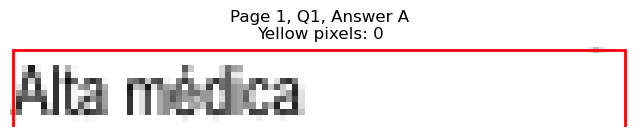

Page 1, Q1 - B: Detected box: x0=82.5, y0=122.9, x1=247.5, y1=135.6
Page 1, Q1, B: Yellow pixels: 0
Page 1, Q1, B: Total non-white pixels: 842
Page 1, Q1, B: Yellow percentage: 0.0%


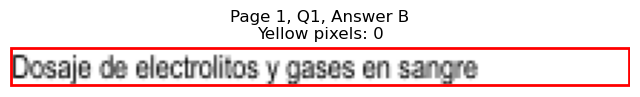

Page 1, Q1 - C: Detected box: x0=82.9, y0=135.5, x1=269.6, y1=148.2
Page 1, Q1, C: Yellow pixels: 0
Page 1, Q1, C: Total non-white pixels: 989
Page 1, Q1, C: Yellow percentage: 0.0%


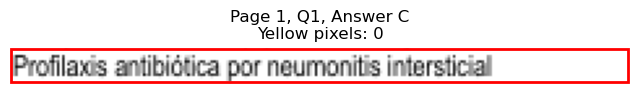

Page 1, Q1 - D: Detected box: x0=334.6, y0=110.3, x1=453.5, y1=123.0
Page 1, Q1, D: Yellow pixels: 1764
Page 1, Q1, D: Total non-white pixels: 2210
Page 1, Q1, D: Yellow percentage: 79.8%


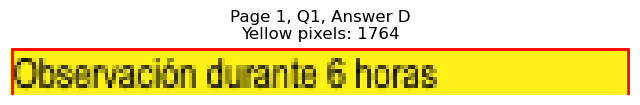

Page 1, Q1 - E: Detected box: x0=334.1, y0=122.9, x1=492.3, y1=135.6
Page 1, Q1, E: Yellow pixels: 192
Page 1, Q1, E: Total non-white pixels: 963
Page 1, Q1, E: Yellow percentage: 19.9%


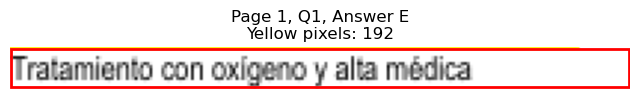


Page 1, Q1 - Selected Answer: D (based on yellow pixel count)




Page 1, Q2 - A: Detected box: x0=82.5, y0=577.4, x1=126.2, y1=590.0
Page 1, Q2, A: Yellow pixels: 95
Page 1, Q2, A: Total non-white pixels: 513
Page 1, Q2, A: Yellow percentage: 18.5%


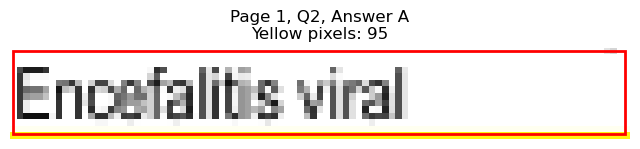

Page 1, Q2 - B: Detected box: x0=82.5, y0=211.3, x1=173.2, y1=224.0
Page 1, Q2, B: Yellow pixels: 1436
Page 1, Q2, B: Total non-white pixels: 1846
Page 1, Q2, B: Yellow percentage: 77.8%


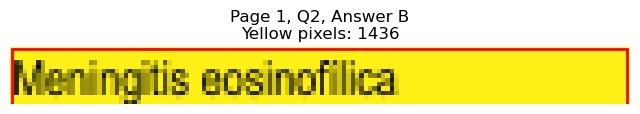

Page 1, Q2 - C: Detected box: x0=82.9, y0=223.9, x1=184.2, y1=236.6
Page 1, Q2, C: Yellow pixels: 149
Page 1, Q2, C: Total non-white pixels: 681
Page 1, Q2, C: Yellow percentage: 21.9%


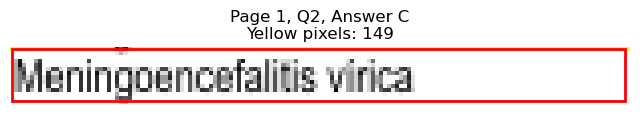

Page 1, Q2 - D: Detected box: x0=334.6, y0=198.6, x1=421.4, y1=211.3
Page 1, Q2, D: Yellow pixels: 0
Page 1, Q2, D: Total non-white pixels: 447
Page 1, Q2, D: Yellow percentage: 0.0%


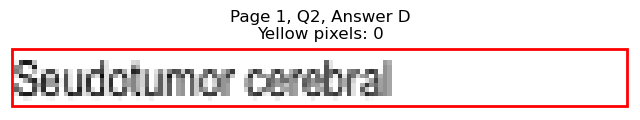

Page 1, Q2 - E: Detected box: x0=334.1, y0=211.3, x1=406.4, y1=224.0
Page 1, Q2, E: Yellow pixels: 0
Page 1, Q2, E: Total non-white pixels: 365
Page 1, Q2, E: Yellow percentage: 0.0%


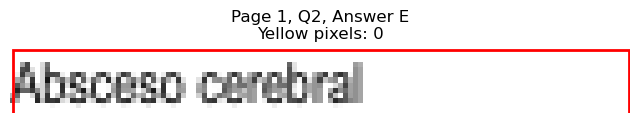


Page 1, Q2 - Selected Answer: B (based on yellow pixel count)




Page 1, Q3 - A: Detected box: x0=82.5, y0=261.7, x1=226.5, y1=274.4
Page 1, Q3, A: Yellow pixels: 1903
Page 1, Q3, A: Total non-white pixels: 2702
Page 1, Q3, A: Yellow percentage: 70.4%


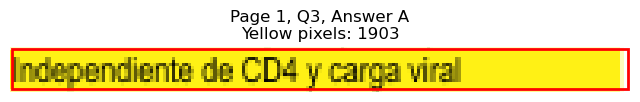

Page 1, Q3 - B: Detected box: x0=82.5, y0=274.5, x1=198.8, y1=287.1
Page 1, Q3, B: Yellow pixels: 0
Page 1, Q3, B: Total non-white pixels: 580
Page 1, Q3, B: Yellow percentage: 0.0%


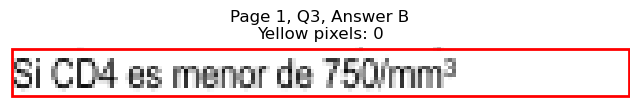

Page 1, Q3 - C: Detected box: x0=82.9, y0=287.1, x1=200.8, y1=299.7
Page 1, Q3, C: Yellow pixels: 0
Page 1, Q3, C: Total non-white pixels: 599
Page 1, Q3, C: Yellow percentage: 0.0%


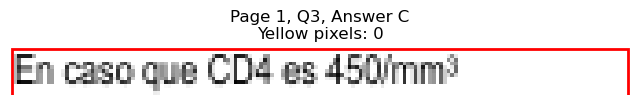

Page 1, Q3 - D: Detected box: x0=334.6, y0=261.7, x1=465.3, y1=274.4
Page 1, Q3, D: Yellow pixels: 0
Page 1, Q3, D: Total non-white pixels: 625
Page 1, Q3, D: Yellow percentage: 0.0%


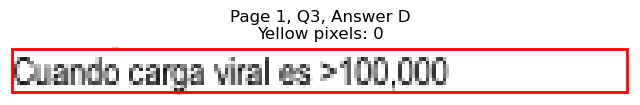

Page 1, Q3 - E: Detected box: x0=334.1, y0=274.5, x1=484.2, y1=287.1
Page 1, Q3, E: Yellow pixels: 0
Page 1, Q3, E: Total non-white pixels: 745
Page 1, Q3, E: Yellow percentage: 0.0%


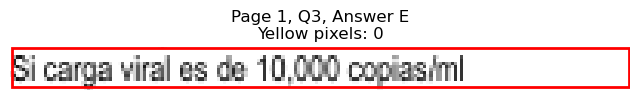


Page 1, Q3 - Selected Answer: A (based on yellow pixel count)




Page 1, Q4 - A: Detected box: x0=82.5, y0=350.2, x1=253.5, y1=362.9
Page 1, Q4, A: Yellow pixels: 0
Page 1, Q4, A: Total non-white pixels: 840
Page 1, Q4, A: Yellow percentage: 0.0%


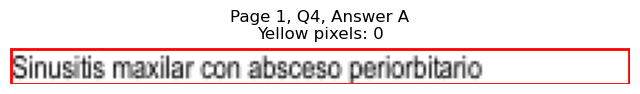

Page 1, Q4 - B: Detected box: x0=82.5, y0=362.8, x1=261.5, y1=375.5
Page 1, Q4, B: Yellow pixels: 0
Page 1, Q4, B: Total non-white pixels: 911
Page 1, Q4, B: Yellow percentage: 0.0%


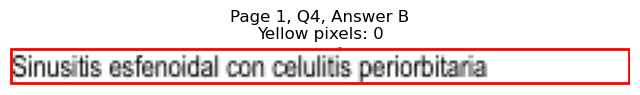

Page 1, Q4 - C: Detected box: x0=82.9, y0=375.4, x1=245.9, y1=388.1
Page 1, Q4, C: Yellow pixels: 0
Page 1, Q4, C: Total non-white pixels: 847
Page 1, Q4, C: Yellow percentage: 0.0%


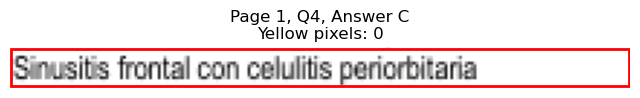

Page 1, Q4 - D: Detected box: x0=334.6, y0=350.2, x1=484.7, y1=362.9
Page 1, Q4, D: Yellow pixels: 0
Page 1, Q4, D: Total non-white pixels: 971
Page 1, Q4, D: Yellow percentage: 0.0%


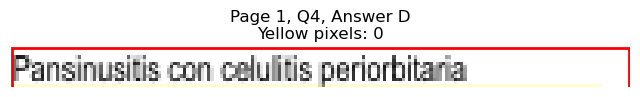

Page 1, Q4 - E: Detected box: x0=334.1, y0=362.8, x1=506.1, y1=375.5
Page 1, Q4, E: Yellow pixels: 1807
Page 1, Q4, E: Total non-white pixels: 2688
Page 1, Q4, E: Yellow percentage: 67.2%


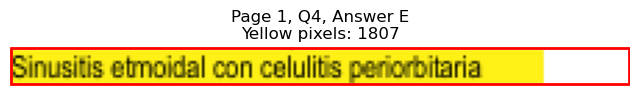


Page 1, Q4 - Selected Answer: E (based on yellow pixel count)




Page 1, Q5 - A: Detected box: x0=82.5, y0=438.5, x1=121.6, y1=451.2
Page 1, Q5, A: Yellow pixels: 0
Page 1, Q5, A: Total non-white pixels: 201
Page 1, Q5, A: Yellow percentage: 0.0%


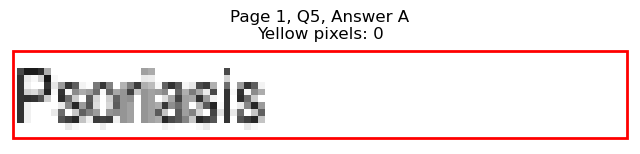

Page 1, Q5 - B: Detected box: x0=82.5, y0=451.1, x1=188.8, y1=463.8
Page 1, Q5, B: Yellow pixels: 0
Page 1, Q5, B: Total non-white pixels: 691
Page 1, Q5, B: Yellow percentage: 0.0%


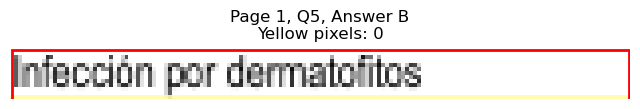

Page 1, Q5 - C: Detected box: x0=82.9, y0=463.7, x1=170.7, y1=476.4
Page 1, Q5, C: Yellow pixels: 1323
Page 1, Q5, C: Total non-white pixels: 1946
Page 1, Q5, C: Yellow percentage: 68.0%


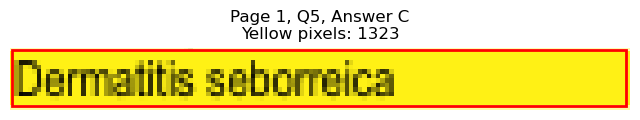

Page 1, Q5 - D: Detected box: x0=334.6, y0=438.5, x1=455.0, y1=451.2
Page 1, Q5, D: Yellow pixels: 0
Page 1, Q5, D: Total non-white pixels: 612
Page 1, Q5, D: Yellow percentage: 0.0%


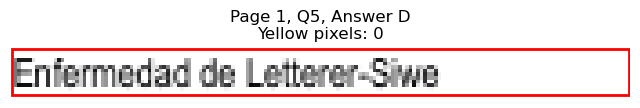

Page 1, Q5 - E: Detected box: x0=334.1, y0=451.1, x1=392.8, y1=463.8
Page 1, Q5, E: Yellow pixels: 0
Page 1, Q5, E: Total non-white pixels: 300
Page 1, Q5, E: Yellow percentage: 0.0%


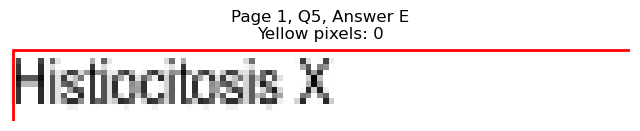


Page 1, Q5 - Selected Answer: C (based on yellow pixel count)




Page 1, Q6 - A: Detected box: x0=82.5, y0=501.7, x1=108.0, y1=514.3
Page 1, Q6, A: Yellow pixels: 77
Page 1, Q6, A: Total non-white pixels: 156
Page 1, Q6, A: Yellow percentage: 49.4%


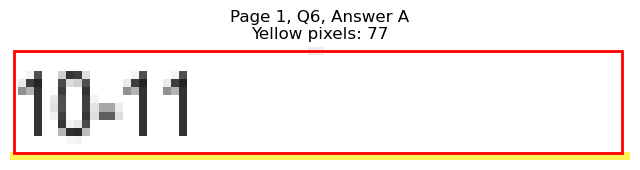

Page 1, Q6 - B: Detected box: x0=82.5, y0=514.3, x1=98.1, y1=526.9
Page 1, Q6, B: Yellow pixels: 831
Page 1, Q6, B: Total non-white pixels: 871
Page 1, Q6, B: Yellow percentage: 95.4%


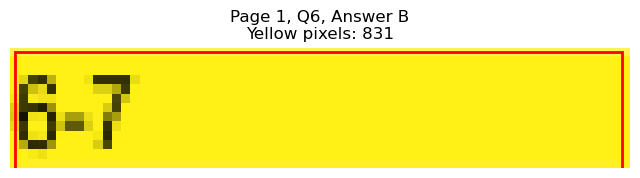

Page 1, Q6 - C: Detected box: x0=82.9, y0=526.9, x1=98.5, y1=539.5
Page 1, Q6, C: Yellow pixels: 67
Page 1, Q6, C: Total non-white pixels: 140
Page 1, Q6, C: Yellow percentage: 47.9%


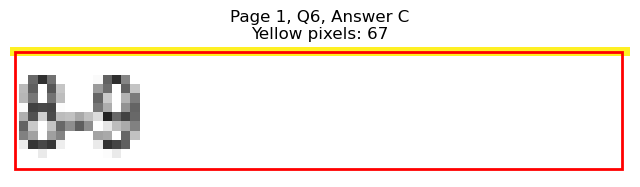

Page 1, Q6 - D: Detected box: x0=334.6, y0=501.7, x1=350.2, y1=514.3
Page 1, Q6, D: Yellow pixels: 0
Page 1, Q6, D: Total non-white pixels: 62
Page 1, Q6, D: Yellow percentage: 0.0%


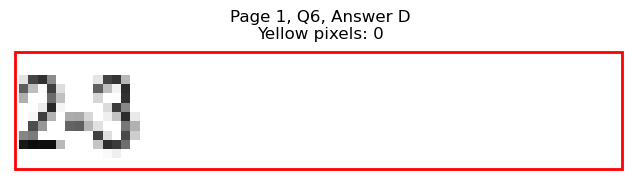

Page 1, Q6 - E: Detected box: x0=334.1, y0=514.3, x1=349.7, y1=526.9
Page 1, Q6, E: Yellow pixels: 0
Page 1, Q6, E: Total non-white pixels: 62
Page 1, Q6, E: Yellow percentage: 0.0%


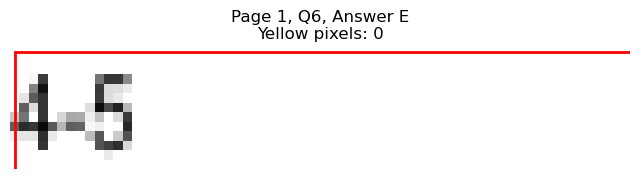


Page 1, Q6 - Selected Answer: B (based on yellow pixel count)




Page 1, Q7 - A: Detected box: x0=82.5, y0=577.4, x1=145.1, y1=590.0
Page 1, Q7, A: Yellow pixels: 114
Page 1, Q7, A: Total non-white pixels: 553
Page 1, Q7, A: Yellow percentage: 20.6%


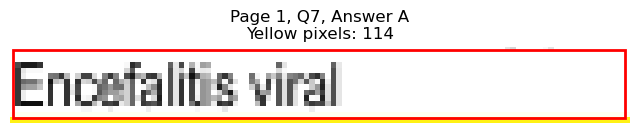

Page 1, Q7 - B: Detected box: x0=82.5, y0=590.0, x1=174.7, y1=602.6
Page 1, Q7, B: Yellow pixels: 1453
Page 1, Q7, B: Total non-white pixels: 2002
Page 1, Q7, B: Yellow percentage: 72.6%


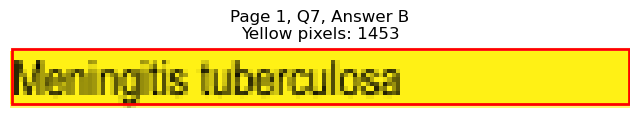

Page 1, Q7 - C: Detected box: x0=82.9, y0=602.6, x1=145.1, y1=615.2
Page 1, Q7, C: Yellow pixels: 113
Page 1, Q7, C: Total non-white pixels: 417
Page 1, Q7, C: Yellow percentage: 27.1%


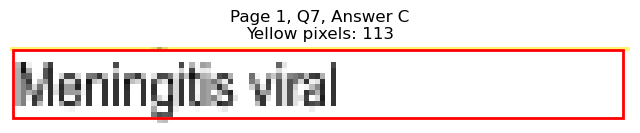

Page 1, Q7 - D: Detected box: x0=334.6, y0=577.4, x1=427.9, y1=590.0
Page 1, Q7, D: Yellow pixels: 0
Page 1, Q7, D: Total non-white pixels: 509
Page 1, Q7, D: Yellow percentage: 0.0%


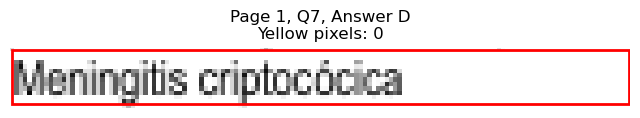

Page 1, Q7 - E: Detected box: x0=334.1, y0=590.0, x1=421.9, y1=602.6
Page 1, Q7, E: Yellow pixels: 0
Page 1, Q7, E: Total non-white pixels: 486
Page 1, Q7, E: Yellow percentage: 0.0%


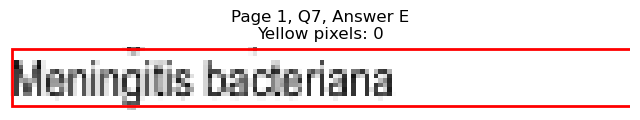


Page 1, Q7 - Selected Answer: B (based on yellow pixel count)




Page 1, Q8 - A: Detected box: x0=82.5, y0=678.3, x1=127.6, y1=691.0
Page 1, Q8, A: Yellow pixels: 0
Page 1, Q8, A: Total non-white pixels: 268
Page 1, Q8, A: Yellow percentage: 0.0%


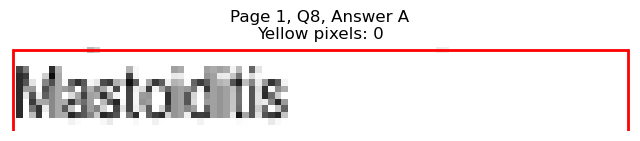

Page 1, Q8 - B: Detected box: x0=82.5, y0=691.1, x1=144.1, y1=703.7
Page 1, Q8, B: Yellow pixels: 2
Page 1, Q8, B: Total non-white pixels: 429
Page 1, Q8, B: Yellow percentage: 0.5%


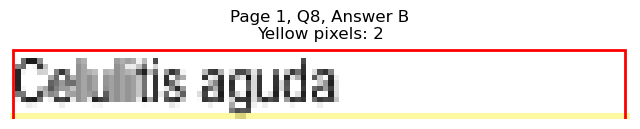

Page 1, Q8 - C: Detected box: x0=82.9, y0=703.7, x1=165.3, y1=716.3
Page 1, Q8, C: Yellow pixels: 1271
Page 1, Q8, C: Total non-white pixels: 1876
Page 1, Q8, C: Yellow percentage: 67.8%


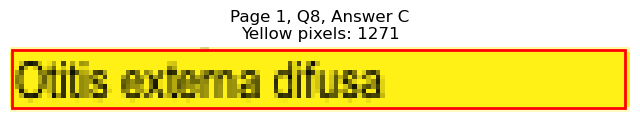

Page 1, Q8 - D: Detected box: x0=334.6, y0=678.3, x1=384.8, y1=691.0
Page 1, Q8, D: Yellow pixels: 0
Page 1, Q8, D: Total non-white pixels: 260
Page 1, Q8, D: Yellow percentage: 0.0%


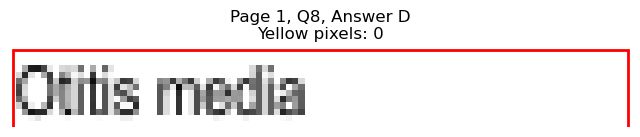

Page 1, Q8 - E: Detected box: x0=334.1, y0=691.1, x1=385.3, y1=703.7
Page 1, Q8, E: Yellow pixels: 0
Page 1, Q8, E: Total non-white pixels: 261
Page 1, Q8, E: Yellow percentage: 0.0%


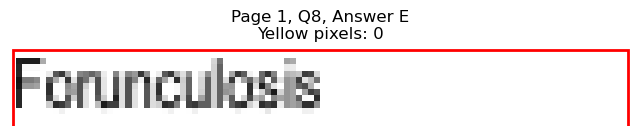


Page 1, Q8 - Selected Answer: C (based on yellow pixel count)





Page 2: Found 9 questions
Page 2, Q1 - A: Detected box: x0=82.5, y0=110.3, x1=159.7, y1=123.0
Page 2, Q1, A: Yellow pixels: 1338
Page 2, Q1, A: Total non-white pixels: 1664
Page 2, Q1, A: Yellow percentage: 80.4%


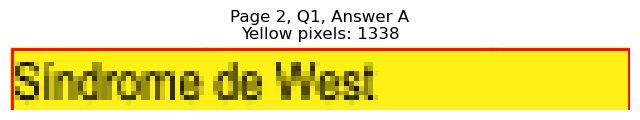

Page 2, Q1 - B: Detected box: x0=82.5, y0=122.9, x1=176.8, y1=135.6
Page 2, Q1, B: Yellow pixels: 145
Page 2, Q1, B: Total non-white pixels: 630
Page 2, Q1, B: Yellow percentage: 23.0%


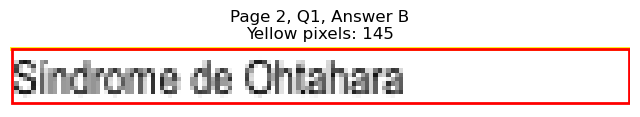

Page 2, Q1 - C: Detected box: x0=82.9, y0=135.5, x1=203.8, y1=148.2
Page 2, Q1, C: Yellow pixels: 0
Page 2, Q1, C: Total non-white pixels: 577
Page 2, Q1, C: Yellow percentage: 0.0%


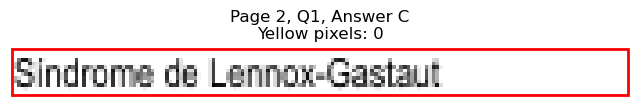

Page 2, Q1 - D: Detected box: x0=334.6, y0=110.3, x1=420.4, y1=123.0
Page 2, Q1, D: Yellow pixels: 0
Page 2, Q1, D: Total non-white pixels: 458
Page 2, Q1, D: Yellow percentage: 0.0%


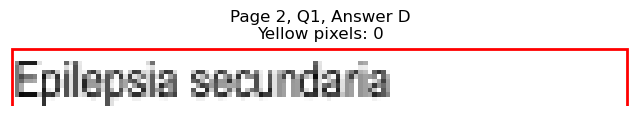

Page 2, Q1 - E: Detected box: x0=334.1, y0=122.9, x1=418.4, y1=135.6
Page 2, Q1, E: Yellow pixels: 0
Page 2, Q1, E: Total non-white pixels: 461
Page 2, Q1, E: Yellow percentage: 0.0%


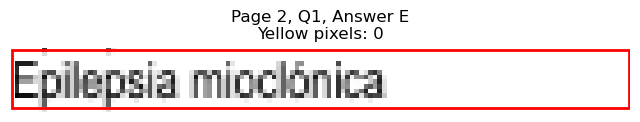


Page 2, Q1 - Selected Answer: A (based on yellow pixel count)




Page 2, Q2 - A: Detected box: x0=82.5, y0=173.4, x1=159.7, y1=186.1
Page 2, Q2, A: Yellow pixels: 0
Page 2, Q2, A: Total non-white pixels: 386
Page 2, Q2, A: Yellow percentage: 0.0%


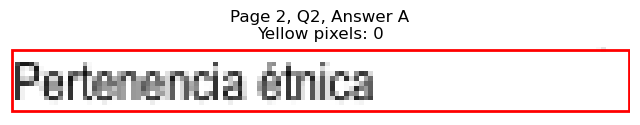

Page 2, Q2 - B: Detected box: x0=82.5, y0=186.0, x1=105.5, y1=198.7
Page 2, Q2, B: Yellow pixels: 0
Page 2, Q2, B: Total non-white pixels: 112
Page 2, Q2, B: Yellow percentage: 0.0%


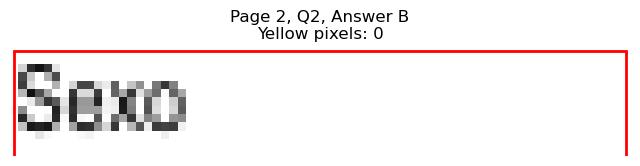

Page 2, Q2 - C: Detected box: x0=82.9, y0=198.6, x1=106.6, y1=211.3
Page 2, Q2, C: Yellow pixels: 0
Page 2, Q2, C: Total non-white pixels: 127
Page 2, Q2, C: Yellow percentage: 0.0%


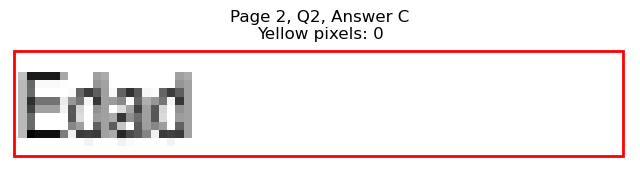

Page 2, Q2 - D: Detected box: x0=334.6, y0=173.4, x1=373.3, y1=186.1
Page 2, Q2, D: Yellow pixels: 90
Page 2, Q2, D: Total non-white pixels: 302
Page 2, Q2, D: Yellow percentage: 29.8%


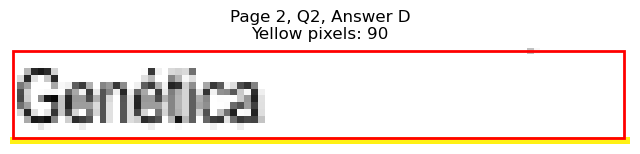

Page 2, Q2 - E: Detected box: x0=334.1, y0=186.0, x1=404.8, y1=198.7
Page 2, Q2, E: Yellow pixels: 1317
Page 2, Q2, E: Total non-white pixels: 1573
Page 2, Q2, E: Yellow percentage: 83.7%


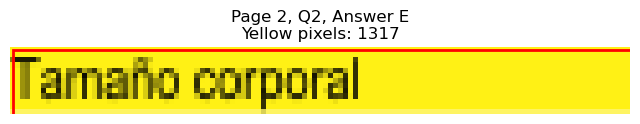


Page 2, Q2 - Selected Answer: E (based on yellow pixel count)




Page 2, Q3 - A: Detected box: x0=82.5, y0=261.7, x1=199.8, y1=274.4
Page 2, Q3, A: Yellow pixels: 0
Page 2, Q3, A: Total non-white pixels: 620
Page 2, Q3, A: Yellow percentage: 0.0%


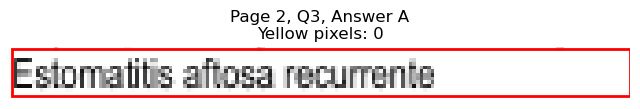

Page 2, Q3 - B: Detected box: x0=82.5, y0=274.5, x1=131.7, y1=287.1
Page 2, Q3, B: Yellow pixels: 0
Page 2, Q3, B: Total non-white pixels: 271
Page 2, Q3, B: Yellow percentage: 0.0%


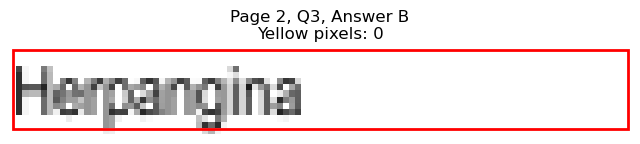

Page 2, Q3 - C: Detected box: x0=82.9, y0=287.1, x1=188.3, y1=299.7
Page 2, Q3, C: Yellow pixels: 0
Page 2, Q3, C: Total non-white pixels: 545
Page 2, Q3, C: Yellow percentage: 0.0%


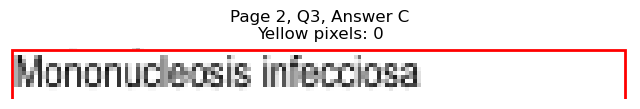

Page 2, Q3 - D: Detected box: x0=334.6, y0=261.7, x1=383.8, y1=274.4
Page 2, Q3, D: Yellow pixels: 0
Page 2, Q3, D: Total non-white pixels: 276
Page 2, Q3, D: Yellow percentage: 0.0%


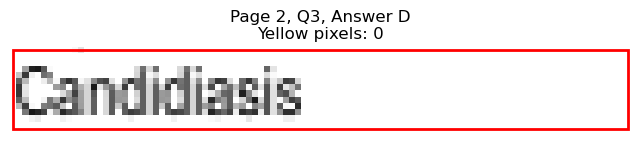

Page 2, Q3 - E: Detected box: x0=334.1, y0=274.5, x1=491.1, y1=287.1
Page 2, Q3, E: Yellow pixels: 1881
Page 2, Q3, E: Total non-white pixels: 2688
Page 2, Q3, E: Yellow percentage: 70.0%


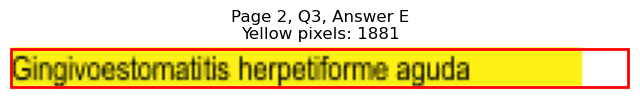


Page 2, Q3 - Selected Answer: E (based on yellow pixel count)




Page 2, Q4 - A: Detected box: x0=82.5, y0=337.5, x1=157.2, y1=350.1
Page 2, Q4, A: Yellow pixels: 0
Page 2, Q4, A: Total non-white pixels: 375
Page 2, Q4, A: Yellow percentage: 0.0%


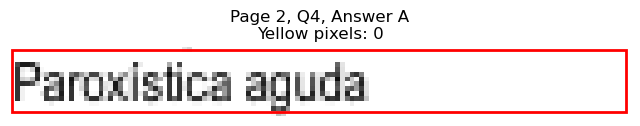

Page 2, Q4 - B: Detected box: x0=82.5, y0=350.2, x1=137.2, y1=362.9
Page 2, Q4, B: Yellow pixels: 0
Page 2, Q4, B: Total non-white pixels: 282
Page 2, Q4, B: Yellow percentage: 0.0%


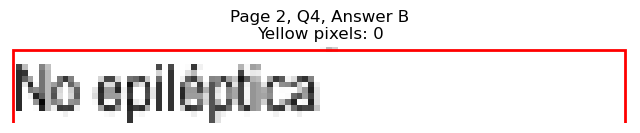

Page 2, Q4 - C: Detected box: x0=82.9, y0=362.8, x1=141.6, y1=375.5
Page 2, Q4, C: Yellow pixels: 0
Page 2, Q4, C: Total non-white pixels: 290
Page 2, Q4, C: Yellow percentage: 0.0%


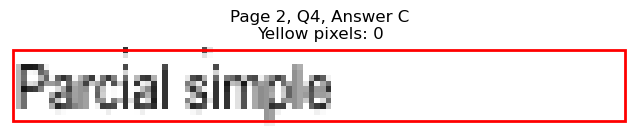

Page 2, Q4 - D: Detected box: x0=334.6, y0=337.5, x1=403.4, y1=350.1
Page 2, Q4, D: Yellow pixels: 0
Page 2, Q4, D: Total non-white pixels: 372
Page 2, Q4, D: Yellow percentage: 0.0%


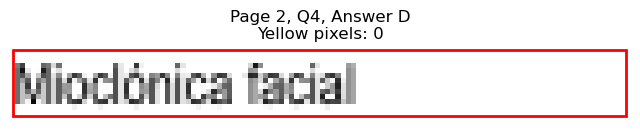

Page 2, Q4 - E: Detected box: x0=334.1, y0=350.2, x1=402.9, y1=362.9
Page 2, Q4, E: Yellow pixels: 1281
Page 2, Q4, E: Total non-white pixels: 1547
Page 2, Q4, E: Yellow percentage: 82.8%


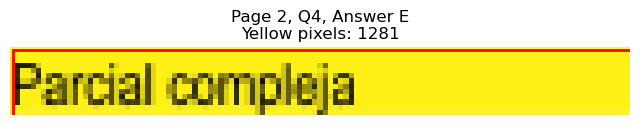


Page 2, Q4 - Selected Answer: E (based on yellow pixel count)




Page 2, Q5 - A: Detected box: x0=82.5, y0=400.6, x1=236.4, y1=413.3
Page 2, Q5, A: Yellow pixels: 0
Page 2, Q5, A: Total non-white pixels: 788
Page 2, Q5, A: Yellow percentage: 0.0%


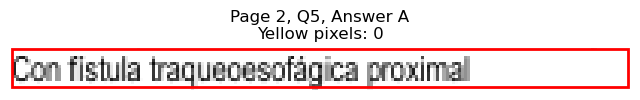

Page 2, Q5 - B: Detected box: x0=82.5, y0=413.3, x1=149.7, y1=426.0
Page 2, Q5, B: Yellow pixels: 0
Page 2, Q5, B: Total non-white pixels: 317
Page 2, Q5, B: Yellow percentage: 0.0%


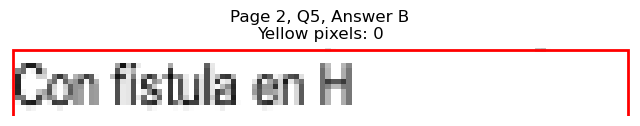

Page 2, Q5 - C: Detected box: x0=82.9, y0=425.9, x1=196.8, y1=438.6
Page 2, Q5, C: Yellow pixels: 0
Page 2, Q5, C: Total non-white pixels: 589
Page 2, Q5, C: Yellow percentage: 0.0%


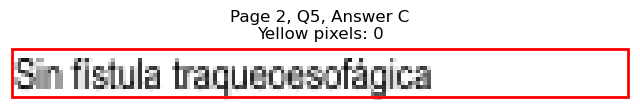

Page 2, Q5 - D: Detected box: x0=334.6, y0=400.6, x1=475.7, y1=413.3
Page 2, Q5, D: Yellow pixels: 1720
Page 2, Q5, D: Total non-white pixels: 2688
Page 2, Q5, D: Yellow percentage: 64.0%


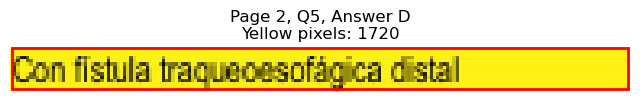

Page 2, Q5 - E: Detected box: x0=334.1, y0=413.3, x1=382.7, y1=426.0
Page 2, Q5, E: Yellow pixels: 0
Page 2, Q5, E: Total non-white pixels: 342
Page 2, Q5, E: Yellow percentage: 0.0%


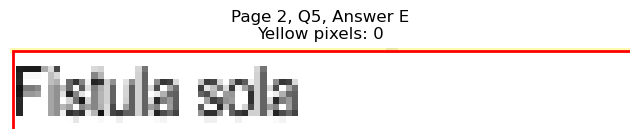


Page 2, Q5 - Selected Answer: D (based on yellow pixel count)




Page 2, Q6 - A: Detected box: x0=82.5, y0=489.1, x1=178.7, y1=501.7
Page 2, Q6, A: Yellow pixels: 0
Page 2, Q6, A: Total non-white pixels: 629
Page 2, Q6, A: Yellow percentage: 0.0%


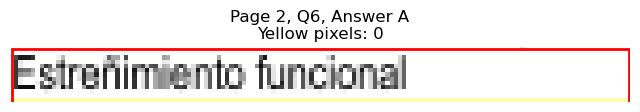

Page 2, Q6 - B: Detected box: x0=82.5, y0=501.7, x1=224.0, y1=514.3
Page 2, Q6, B: Yellow pixels: 1718
Page 2, Q6, B: Total non-white pixels: 2688
Page 2, Q6, B: Yellow percentage: 63.9%


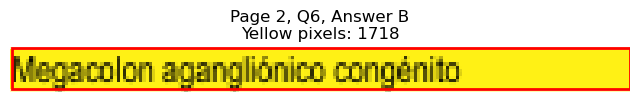

Page 2, Q6 - C: Detected box: x0=82.9, y0=514.3, x1=237.5, y1=526.9
Page 2, Q6, C: Yellow pixels: 0
Page 2, Q6, C: Total non-white pixels: 1028
Page 2, Q6, C: Yellow percentage: 0.0%


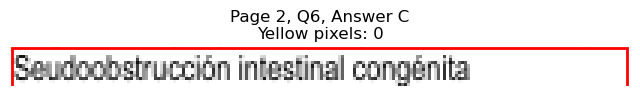

Page 2, Q6 - D: Detected box: x0=334.6, y0=489.1, x1=449.5, y1=501.7
Page 2, Q6, D: Yellow pixels: 0
Page 2, Q6, D: Total non-white pixels: 615
Page 2, Q6, D: Yellow percentage: 0.0%


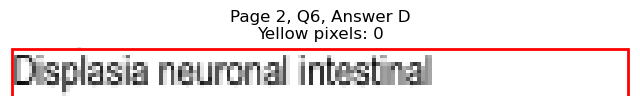

Page 2, Q6 - E: Detected box: x0=334.1, y0=501.7, x1=393.8, y1=514.3
Page 2, Q6, E: Yellow pixels: 0
Page 2, Q6, E: Total non-white pixels: 329
Page 2, Q6, E: Yellow percentage: 0.0%


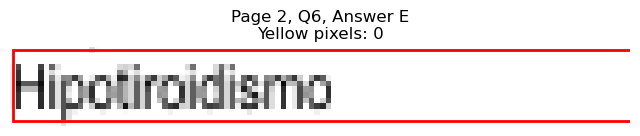


Page 2, Q6 - Selected Answer: B (based on yellow pixel count)




Page 2, Q7 - A: Detected box: x0=82.5, y0=552.2, x1=142.1, y1=564.8
Page 2, Q7, A: Yellow pixels: 0
Page 2, Q7, A: Total non-white pixels: 308
Page 2, Q7, A: Yellow percentage: 0.0%


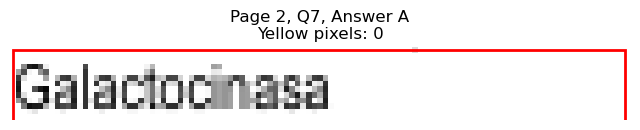

Page 2, Q7 - B: Detected box: x0=82.5, y0=564.8, x1=208.8, y1=577.4
Page 2, Q7, B: Yellow pixels: 0
Page 2, Q7, B: Total non-white pixels: 642
Page 2, Q7, B: Yellow percentage: 0.0%


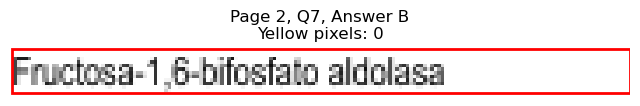

Page 2, Q7 - C: Detected box: x0=82.9, y0=577.4, x1=152.2, y1=590.0
Page 2, Q7, C: Yellow pixels: 0
Page 2, Q7, C: Total non-white pixels: 374
Page 2, Q7, C: Yellow percentage: 0.0%


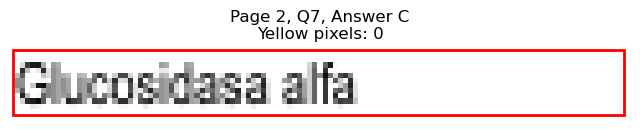

Page 2, Q7 - D: Detected box: x0=334.6, y0=552.2, x1=485.1, y1=564.8
Page 2, Q7, D: Yellow pixels: 1877
Page 2, Q7, D: Total non-white pixels: 2496
Page 2, Q7, D: Yellow percentage: 75.2%


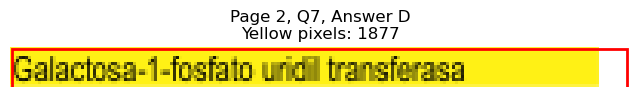

Page 2, Q7 - E: Detected box: x0=334.1, y0=564.8, x1=421.9, y1=577.4
Page 2, Q7, E: Yellow pixels: 138
Page 2, Q7, E: Total non-white pixels: 604
Page 2, Q7, E: Yellow percentage: 22.8%


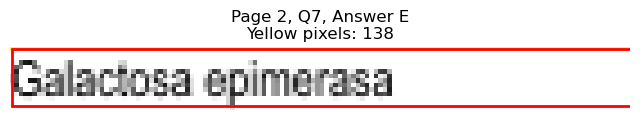


Page 2, Q7 - Selected Answer: D (based on yellow pixel count)




Page 2, Q8 - A: Detected box: x0=82.5, y0=640.5, x1=144.6, y1=653.2
Page 2, Q8, A: Yellow pixels: 113
Page 2, Q8, A: Total non-white pixels: 453
Page 2, Q8, A: Yellow percentage: 24.9%


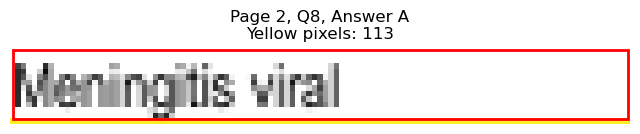

Page 2, Q8 - B: Detected box: x0=82.5, y0=653.1, x1=174.7, y1=665.8
Page 2, Q8, B: Yellow pixels: 1453
Page 2, Q8, B: Total non-white pixels: 1859
Page 2, Q8, B: Yellow percentage: 78.2%


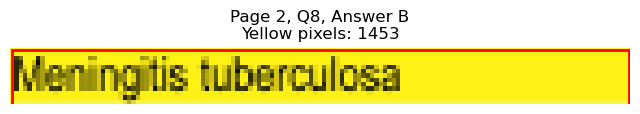

Page 2, Q8 - C: Detected box: x0=82.9, y0=665.7, x1=165.7, y1=678.4
Page 2, Q8, C: Yellow pixels: 133
Page 2, Q8, C: Total non-white pixels: 563
Page 2, Q8, C: Yellow percentage: 23.6%


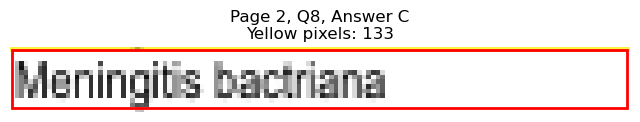

Page 2, Q8 - D: Detected box: x0=334.6, y0=640.5, x1=446.5, y1=653.2
Page 2, Q8, D: Yellow pixels: 0
Page 2, Q8, D: Total non-white pixels: 592
Page 2, Q8, D: Yellow percentage: 0.0%


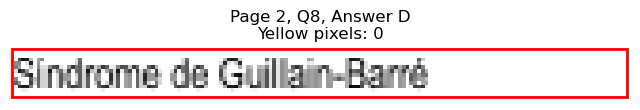

Page 2, Q8 - E: Detected box: x0=334.1, y0=653.1, x1=443.9, y1=665.8
Page 2, Q8, E: Yellow pixels: 0
Page 2, Q8, E: Total non-white pixels: 529
Page 2, Q8, E: Yellow percentage: 0.0%


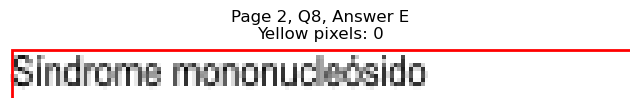


Page 2, Q8 - Selected Answer: B (based on yellow pixel count)




Page 2, Q9 - A: Detected box: x0=82.5, y0=703.7, x1=263.9, y1=716.3
Page 2, Q9, A: Yellow pixels: 0
Page 2, Q9, A: Total non-white pixels: 880
Page 2, Q9, A: Yellow percentage: 0.0%


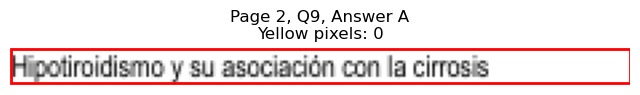

Page 2, Q9 - B: Detected box: x0=131.2, y0=716.3, x1=179.4, y1=728.9
Page 2, Q9, B: Yellow pixels: 0
Page 2, Q9, B: Total non-white pixels: 515
Page 2, Q9, B: Yellow percentage: 0.0%


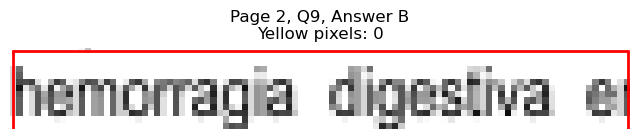

Page 2, Q9 - C: Detected box: x0=82.9, y0=741.4, x1=266.9, y1=754.1
Page 2, Q9, C: Yellow pixels: 0
Page 2, Q9, C: Total non-white pixels: 901
Page 2, Q9, C: Yellow percentage: 0.0%


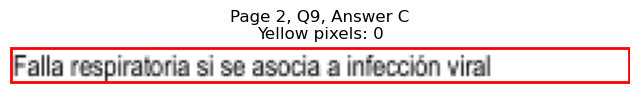

Page 2, Q9 - D: Detected box: x0=334.6, y0=703.7, x1=526.9, y1=716.3
Page 2, Q9, D: Yellow pixels: 0
Page 2, Q9, D: Total non-white pixels: 869
Page 2, Q9, D: Yellow percentage: 0.0%


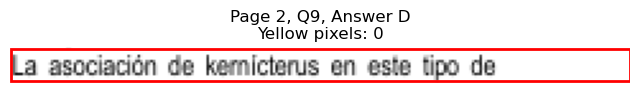

Page 2, Q9 - E: Detected box: x0=334.1, y0=728.9, x1=526.9, y1=741.5
Page 2, Q9, E: Yellow pixels: 1769
Page 2, Q9, E: Total non-white pixels: 2688
Page 2, Q9, E: Yellow percentage: 65.8%


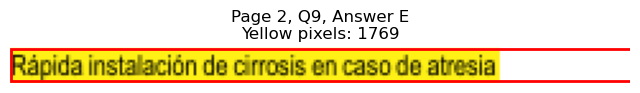


Page 2, Q9 - Selected Answer: E (based on yellow pixel count)





Page 3: Found 8 questions
Page 3, Q1 - A: Detected box: x0=82.5, y0=97.7, x1=215.8, y1=110.4
Page 3, Q1, A: Yellow pixels: 1729
Page 3, Q1, A: Total non-white pixels: 2576
Page 3, Q1, A: Yellow percentage: 67.1%


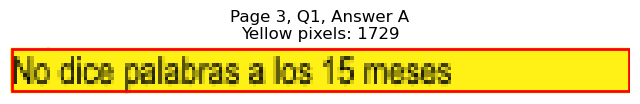

Page 3, Q1 - B: Detected box: x0=82.5, y0=110.3, x1=281.5, y1=123.0
Page 3, Q1, B: Yellow pixels: 0
Page 3, Q1, B: Total non-white pixels: 1155
Page 3, Q1, B: Yellow percentage: 0.0%


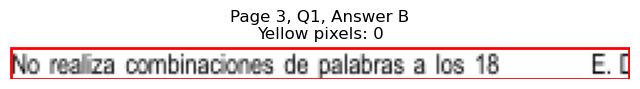

Page 3, Q1 - C: Detected box: x0=82.9, y0=135.5, x1=281.6, y1=148.2
Page 3, Q1, C: Yellow pixels: 0
Page 3, Q1, C: Total non-white pixels: 961
Page 3, Q1, C: Yellow percentage: 0.0%


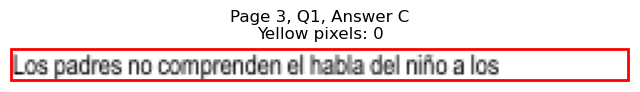

Page 3, Q1 - D: Detected box: x0=328.2, y0=97.7, x1=527.0, y1=110.4
Page 3, Q1, D: Yellow pixels: 0
Page 3, Q1, D: Total non-white pixels: 1013
Page 3, Q1, D: Yellow percentage: 0.0%


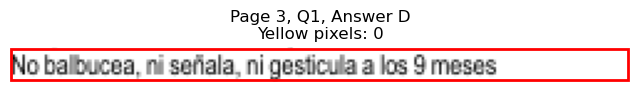

Page 3, Q1 - E: Detected box: x0=327.8, y0=110.3, x1=376.9, y1=123.0
Page 3, Q1, E: Yellow pixels: 0
Page 3, Q1, E: Total non-white pixels: 465
Page 3, Q1, E: Yellow percentage: 0.0%


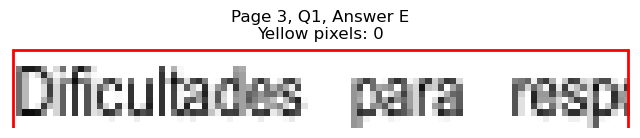


Page 3, Q1 - Selected Answer: A (based on yellow pixel count)




Page 3, Q2 - A: Detected box: x0=82.5, y0=186.0, x1=141.7, y1=198.7
Page 3, Q2, A: Yellow pixels: 0
Page 3, Q2, A: Total non-white pixels: 515
Page 3, Q2, A: Yellow percentage: 0.0%


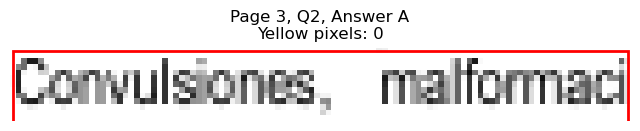

Page 3, Q2 - B: Detected box: x0=82.5, y0=211.3, x1=127.2, y1=224.0
Page 3, Q2, B: Yellow pixels: 0
Page 3, Q2, B: Total non-white pixels: 426
Page 3, Q2, B: Yellow percentage: 0.0%


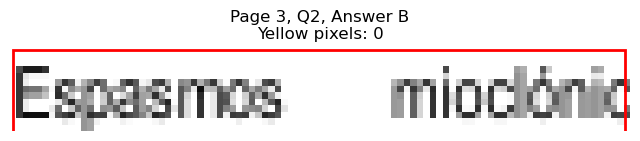

Page 3, Q2 - C: Detected box: x0=82.9, y0=236.5, x1=254.4, y1=249.2
Page 3, Q2, C: Yellow pixels: 0
Page 3, Q2, C: Total non-white pixels: 841
Page 3, Q2, C: Yellow percentage: 0.0%


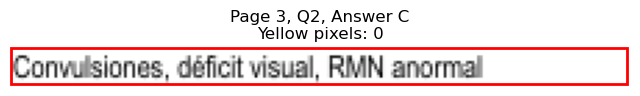

Page 3, Q2 - D: Detected box: x0=334.6, y0=186.0, x1=526.8, y1=198.7
Page 3, Q2, D: Yellow pixels: 1779
Page 3, Q2, D: Total non-white pixels: 2496
Page 3, Q2, D: Yellow percentage: 71.3%


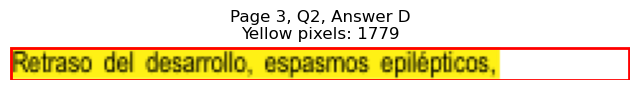

Page 3, Q2 - E: Detected box: x0=334.1, y0=211.3, x1=511.2, y1=224.0
Page 3, Q2, E: Yellow pixels: 0
Page 3, Q2, E: Total non-white pixels: 1046
Page 3, Q2, E: Yellow percentage: 0.0%


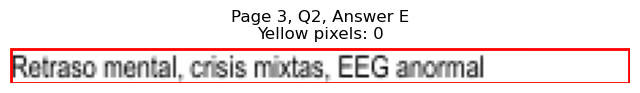


Page 3, Q2 - Selected Answer: D (based on yellow pixel count)




Page 3, Q3 - A: Detected box: x0=82.5, y0=274.5, x1=164.2, y1=287.1
Page 3, Q3, A: Yellow pixels: 0
Page 3, Q3, A: Total non-white pixels: 420
Page 3, Q3, A: Yellow percentage: 0.0%


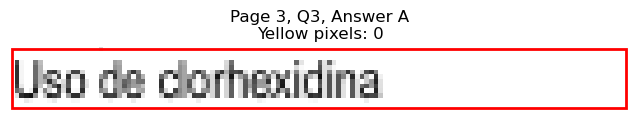

Page 3, Q3 - B: Detected box: x0=82.5, y0=287.1, x1=169.7, y1=299.7
Page 3, Q3, B: Yellow pixels: 0
Page 3, Q3, B: Total non-white pixels: 431
Page 3, Q3, B: Yellow percentage: 0.0%


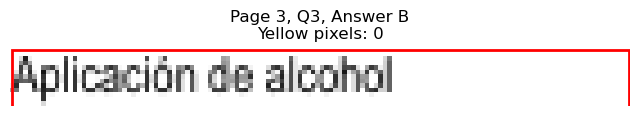

Page 3, Q3 - C: Detected box: x0=82.9, y0=299.7, x1=170.2, y1=312.3
Page 3, Q3, C: Yellow pixels: 0
Page 3, Q3, C: Total non-white pixels: 439
Page 3, Q3, C: Yellow percentage: 0.0%


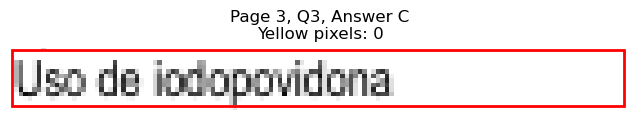

Page 3, Q3 - D: Detected box: x0=334.6, y0=274.5, x1=421.4, y1=287.1
Page 3, Q3, D: Yellow pixels: 1478
Page 3, Q3, D: Total non-white pixels: 1932
Page 3, Q3, D: Yellow percentage: 76.5%


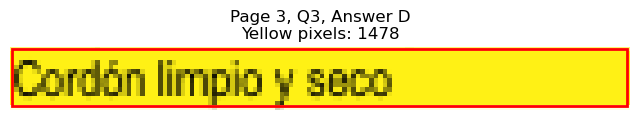

Page 3, Q3 - E: Detected box: x0=334.1, y0=287.1, x1=433.5, y1=299.7
Page 3, Q3, E: Yellow pixels: 0
Page 3, Q3, E: Total non-white pixels: 671
Page 3, Q3, E: Yellow percentage: 0.0%


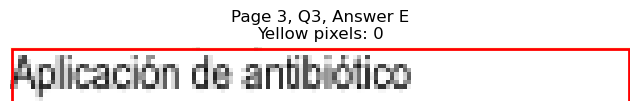


Page 3, Q3 - Selected Answer: D (based on yellow pixel count)




Page 3, Q4 - A: Detected box: x0=82.5, y0=350.2, x1=219.4, y1=362.9
Page 3, Q4, A: Yellow pixels: 0
Page 3, Q4, A: Total non-white pixels: 906
Page 3, Q4, A: Yellow percentage: 0.0%


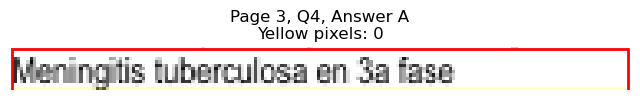

Page 3, Q4 - B: Detected box: x0=82.5, y0=362.8, x1=219.4, y1=375.5
Page 3, Q4, B: Yellow pixels: 1878
Page 3, Q4, B: Total non-white pixels: 2632
Page 3, Q4, B: Yellow percentage: 71.4%


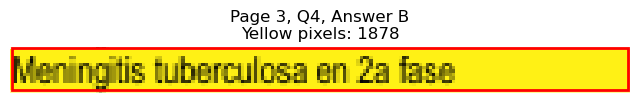

Page 3, Q4 - C: Detected box: x0=82.9, y0=375.4, x1=218.8, y1=388.1
Page 3, Q4, C: Yellow pixels: 186
Page 3, Q4, C: Total non-white pixels: 899
Page 3, Q4, C: Yellow percentage: 20.7%


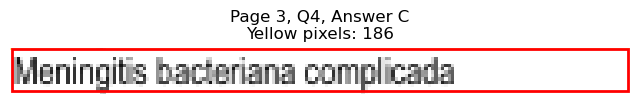

Page 3, Q4 - D: Detected box: x0=334.6, y0=350.2, x1=441.4, y1=362.9
Page 3, Q4, D: Yellow pixels: 0
Page 3, Q4, D: Total non-white pixels: 537
Page 3, Q4, D: Yellow percentage: 0.0%


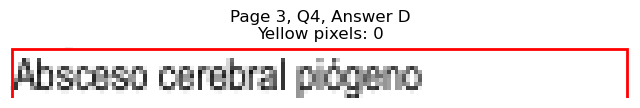

Page 3, Q4 - E: Detected box: x0=334.1, y0=362.8, x1=430.4, y1=375.5
Page 3, Q4, E: Yellow pixels: 0
Page 3, Q4, E: Total non-white pixels: 546
Page 3, Q4, E: Yellow percentage: 0.0%


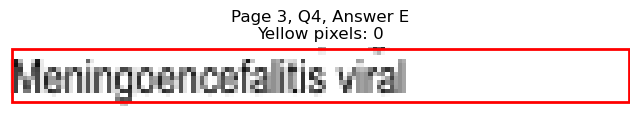


Page 3, Q4 - Selected Answer: B (based on yellow pixel count)




Page 3, Q5 - A: Detected box: x0=82.5, y0=438.5, x1=192.3, y1=451.2
Page 3, Q5, A: Yellow pixels: 0
Page 3, Q5, A: Total non-white pixels: 571
Page 3, Q5, A: Yellow percentage: 0.0%


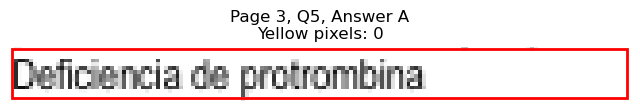

Page 3, Q5 - B: Detected box: x0=82.5, y0=451.1, x1=188.8, y1=463.8
Page 3, Q5, B: Yellow pixels: 0
Page 3, Q5, B: Total non-white pixels: 563
Page 3, Q5, B: Yellow percentage: 0.0%


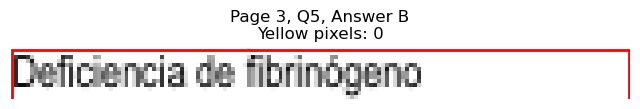

Page 3, Q5 - C: Detected box: x0=82.9, y0=463.7, x1=213.3, y1=476.4
Page 3, Q5, C: Yellow pixels: 0
Page 3, Q5, C: Total non-white pixels: 697
Page 3, Q5, C: Yellow percentage: 0.0%


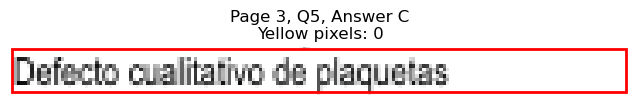

Page 3, Q5 - D: Detected box: x0=334.6, y0=438.5, x1=438.4, y1=451.2
Page 3, Q5, D: Yellow pixels: 155
Page 3, Q5, D: Total non-white pixels: 656
Page 3, Q5, D: Yellow percentage: 23.6%


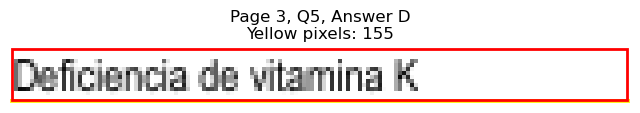

Page 3, Q5 - E: Detected box: x0=334.1, y0=451.1, x1=484.2, y1=463.8
Page 3, Q5, E: Yellow pixels: 1963
Page 3, Q5, E: Total non-white pixels: 2496
Page 3, Q5, E: Yellow percentage: 78.6%


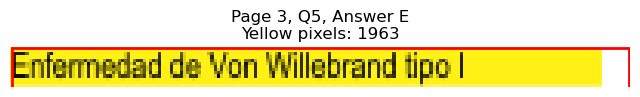


Page 3, Q5 - Selected Answer: E (based on yellow pixel count)




Page 3, Q6 - A: Detected box: x0=82.5, y0=539.5, x1=224.0, y1=552.1
Page 3, Q6, A: Yellow pixels: 0
Page 3, Q6, A: Total non-white pixels: 717
Page 3, Q6, A: Yellow percentage: 0.0%


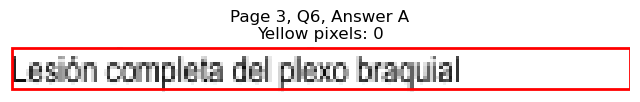

Page 3, Q6 - B: Detected box: x0=82.5, y0=552.2, x1=203.8, y1=564.8
Page 3, Q6, B: Yellow pixels: 0
Page 3, Q6, B: Total non-white pixels: 634
Page 3, Q6, B: Yellow percentage: 0.0%


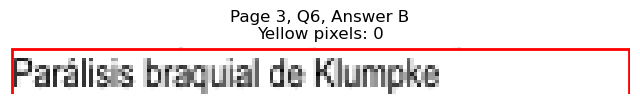

Page 3, Q6 - C: Detected box: x0=82.9, y0=564.8, x1=225.9, y1=577.4
Page 3, Q6, C: Yellow pixels: 0
Page 3, Q6, C: Total non-white pixels: 697
Page 3, Q6, C: Yellow percentage: 0.0%


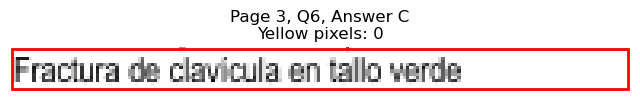

Page 3, Q6 - D: Detected box: x0=334.6, y0=539.5, x1=418.9, y1=552.1
Page 3, Q6, D: Yellow pixels: 0
Page 3, Q6, D: Total non-white pixels: 406
Page 3, Q6, D: Yellow percentage: 0.0%


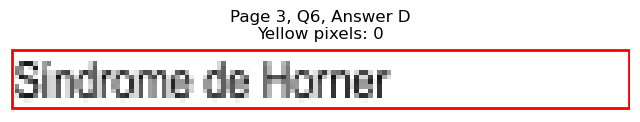

Page 3, Q6 - E: Detected box: x0=334.1, y0=552.2, x1=443.9, y1=564.8
Page 3, Q6, E: Yellow pixels: 1690
Page 3, Q6, E: Total non-white pixels: 2080
Page 3, Q6, E: Yellow percentage: 81.2%


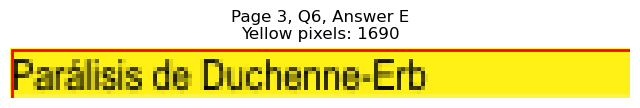


Page 3, Q6 - Selected Answer: E (based on yellow pixel count)




Page 3, Q7 - A: Detected box: x0=82.5, y0=615.2, x1=183.3, y1=627.8
Page 3, Q7, A: Yellow pixels: 1580
Page 3, Q7, A: Total non-white pixels: 1976
Page 3, Q7, A: Yellow percentage: 80.0%


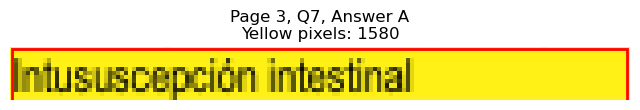

Page 3, Q7 - B: Detected box: x0=132.7, y0=627.9, x1=181.9, y1=640.6
Page 3, Q7, B: Yellow pixels: 100
Page 3, Q7, B: Total non-white pixels: 574
Page 3, Q7, B: Yellow percentage: 17.4%


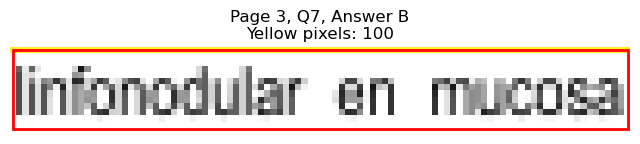

Page 3, Q7 - C: Detected box: x0=334.6, y0=615.2, x1=428.9, y1=627.8
Page 3, Q7, C: Yellow pixels: 0
Page 3, Q7, C: Total non-white pixels: 497
Page 3, Q7, C: Yellow percentage: 0.0%


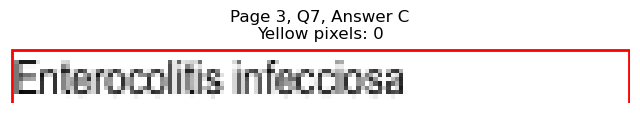

Page 3, Q7 - D: Detected box: x0=334.6, y0=627.9, x1=458.0, y1=640.6
Page 3, Q7, D: Yellow pixels: 0
Page 3, Q7, D: Total non-white pixels: 582
Page 3, Q7, D: Yellow percentage: 0.0%


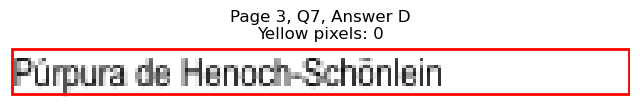

Page 3, Q7 - E: Detected box: x0=334.1, y0=640.5, x1=440.9, y1=653.2
Page 3, Q7, E: Yellow pixels: 0
Page 3, Q7, E: Total non-white pixels: 559
Page 3, Q7, E: Yellow percentage: 0.0%


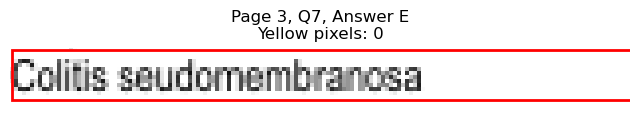


Page 3, Q7 - Selected Answer: A (based on yellow pixel count)




Page 3, Q8 - A: Detected box: x0=70.8, y0=691.1, x1=79.3, y1=703.7
Page 3, Q8, A: Yellow pixels: 0
Page 3, Q8, A: Total non-white pixels: 49
Page 3, Q8, A: Yellow percentage: 0.0%


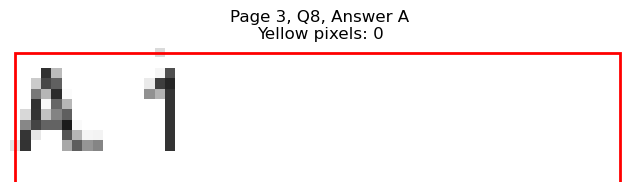

Page 3, Q8 - B: Detected box: x0=70.8, y0=703.7, x1=79.3, y1=716.3
Page 3, Q8, B: Yellow pixels: 60
Page 3, Q8, B: Total non-white pixels: 132
Page 3, Q8, B: Yellow percentage: 45.5%


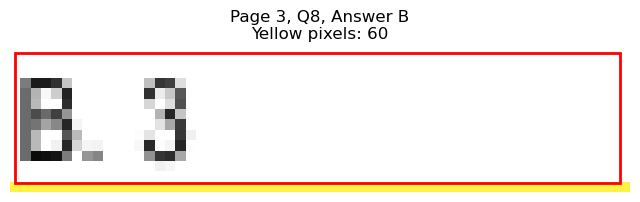

Page 3, Q8 - C: Detected box: x0=70.8, y0=716.3, x1=79.8, y1=728.9
Page 3, Q8, C: Yellow pixels: 732
Page 3, Q8, C: Total non-white pixels: 780
Page 3, Q8, C: Yellow percentage: 93.8%


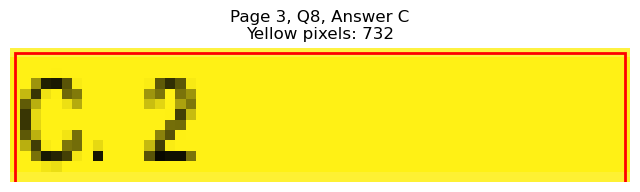

Page 3, Q8 - D: Detected box: x0=322.5, y0=691.1, x1=331.5, y1=703.7
Page 3, Q8, D: Yellow pixels: 0
Page 3, Q8, D: Total non-white pixels: 69
Page 3, Q8, D: Yellow percentage: 0.0%


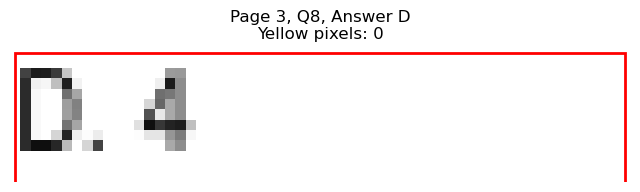

Page 3, Q8 - E: Detected box: x0=322.5, y0=703.7, x1=331.0, y1=716.3
Page 3, Q8, E: Yellow pixels: 0
Page 3, Q8, E: Total non-white pixels: 72
Page 3, Q8, E: Yellow percentage: 0.0%


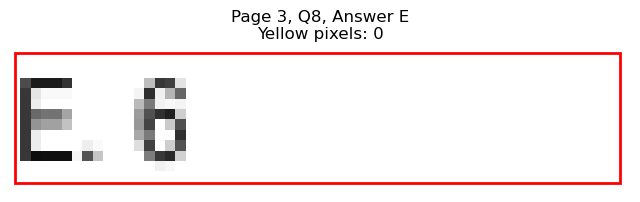


Page 3, Q8 - Selected Answer: C (based on yellow pixel count)





Page 4: Found 9 questions
Page 4, Q1 - A: Detected box: x0=82.5, y0=110.3, x1=164.8, y1=123.0
Page 4, Q1, A: Yellow pixels: 1408
Page 4, Q1, A: Total non-white pixels: 1729
Page 4, Q1, A: Yellow percentage: 81.4%


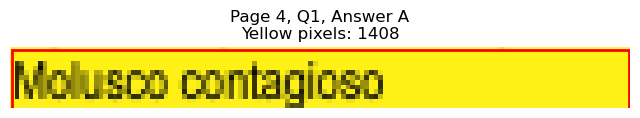

Page 4, Q1 - B: Detected box: x0=82.5, y0=122.9, x1=137.7, y1=135.6
Page 4, Q1, B: Yellow pixels: 102
Page 4, Q1, B: Total non-white pixels: 397
Page 4, Q1, B: Yellow percentage: 25.7%


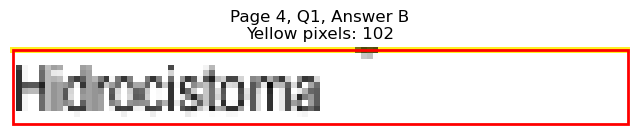

Page 4, Q1 - C: Detected box: x0=82.9, y0=135.5, x1=144.6, y1=148.2
Page 4, Q1, C: Yellow pixels: 0
Page 4, Q1, C: Total non-white pixels: 319
Page 4, Q1, C: Yellow percentage: 0.0%


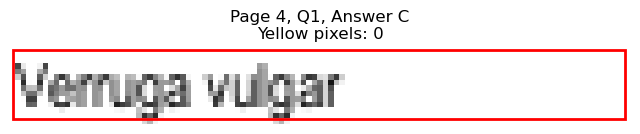

Page 4, Q1 - D: Detected box: x0=334.6, y0=110.3, x1=377.7, y1=123.0
Page 4, Q1, D: Yellow pixels: 0
Page 4, Q1, D: Total non-white pixels: 219
Page 4, Q1, D: Yellow percentage: 0.0%


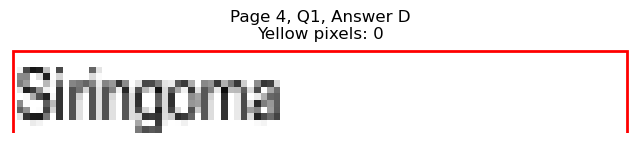

Page 4, Q1 - E: Detected box: x0=334.1, y0=122.9, x1=371.2, y1=135.6
Page 4, Q1, E: Yellow pixels: 0
Page 4, Q1, E: Total non-white pixels: 199
Page 4, Q1, E: Yellow percentage: 0.0%


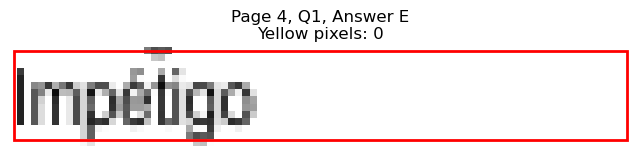


Page 4, Q1 - Selected Answer: A (based on yellow pixel count)




Page 4, Q2 - A: Detected box: x0=82.5, y0=186.0, x1=191.8, y1=198.7
Page 4, Q2, A: Yellow pixels: 0
Page 4, Q2, A: Total non-white pixels: 543
Page 4, Q2, A: Yellow percentage: 0.0%


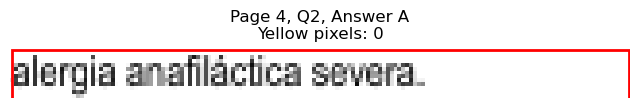

Page 4, Q2 - B: Detected box: x0=82.5, y0=198.6, x1=141.6, y1=211.3
Page 4, Q2, B: Yellow pixels: 0
Page 4, Q2, B: Total non-white pixels: 297
Page 4, Q2, B: Yellow percentage: 0.0%


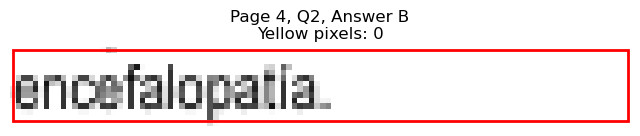

Page 4, Q2 - C: Detected box: x0=82.9, y0=211.3, x1=205.4, y1=224.0
Page 4, Q2, C: Yellow pixels: 0
Page 4, Q2, C: Total non-white pixels: 624
Page 4, Q2, C: Yellow percentage: 0.0%


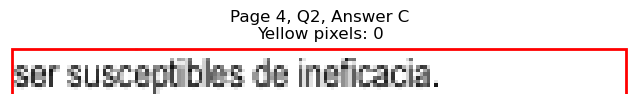

Page 4, Q2 - D: Detected box: x0=334.6, y0=186.0, x1=522.7, y1=198.7
Page 4, Q2, D: Yellow pixels: 1805
Page 4, Q2, D: Total non-white pixels: 2496
Page 4, Q2, D: Yellow percentage: 72.3%


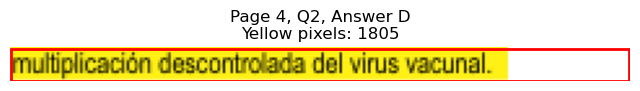

Page 4, Q2 - E: Detected box: x0=334.1, y0=198.6, x1=457.5, y1=211.3
Page 4, Q2, E: Yellow pixels: 174
Page 4, Q2, E: Total non-white pixels: 749
Page 4, Q2, E: Yellow percentage: 23.2%


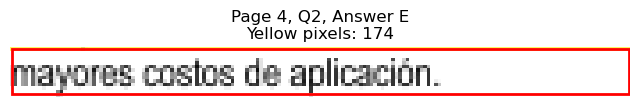


Page 4, Q2 - Selected Answer: D (based on yellow pixel count)




Page 4, Q3 - A: Detected box: x0=82.5, y0=261.7, x1=275.3, y1=274.4
Page 4, Q3, A: Yellow pixels: 0
Page 4, Q3, A: Total non-white pixels: 976
Page 4, Q3, A: Yellow percentage: 0.0%


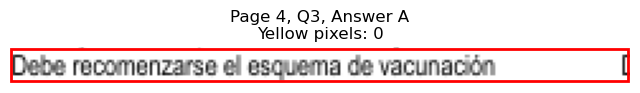

Page 4, Q3 - B: Detected box: x0=82.5, y0=274.5, x1=226.8, y1=287.1
Page 4, Q3, B: Yellow pixels: 0
Page 4, Q3, B: Total non-white pixels: 697
Page 4, Q3, B: Yellow percentage: 0.0%


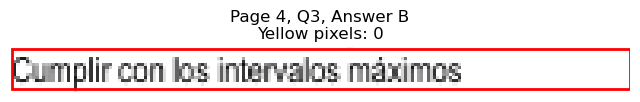

Page 4, Q3 - C: Detected box: x0=82.9, y0=287.1, x1=220.4, y1=299.7
Page 4, Q3, C: Yellow pixels: 0
Page 4, Q3, C: Total non-white pixels: 704
Page 4, Q3, C: Yellow percentage: 0.0%


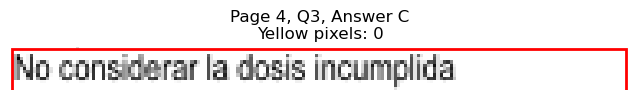

Page 4, Q3 - D: Detected box: x0=334.6, y0=261.7, x1=449.9, y1=274.4
Page 4, Q3, D: Yellow pixels: 0
Page 4, Q3, D: Total non-white pixels: 576
Page 4, Q3, D: Yellow percentage: 0.0%


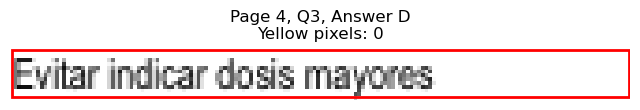

Page 4, Q3 - E: Detected box: x0=334.1, y0=274.5, x1=480.6, y1=287.1
Page 4, Q3, E: Yellow pixels: 1958
Page 4, Q3, E: Total non-white pixels: 2688
Page 4, Q3, E: Yellow percentage: 72.8%


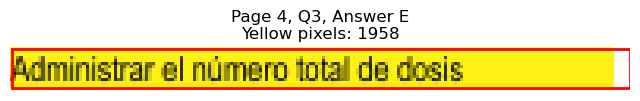


Page 4, Q3 - Selected Answer: E (based on yellow pixel count)




Page 4, Q4 - A: Detected box: x0=82.5, y0=337.5, x1=193.8, y1=350.1
Page 4, Q4, A: Yellow pixels: 0
Page 4, Q4, A: Total non-white pixels: 581
Page 4, Q4, A: Yellow percentage: 0.0%


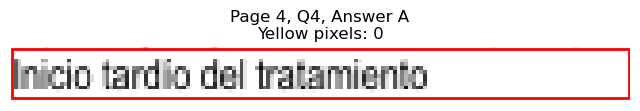

Page 4, Q4 - B: Detected box: x0=82.5, y0=350.2, x1=232.4, y1=362.9
Page 4, Q4, B: Yellow pixels: 0
Page 4, Q4, B: Total non-white pixels: 954
Page 4, Q4, B: Yellow percentage: 0.0%


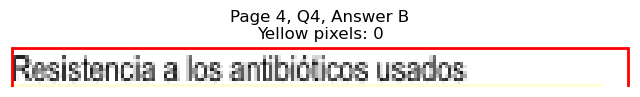

Page 4, Q4 - C: Detected box: x0=82.9, y0=362.8, x1=208.4, y1=375.5
Page 4, Q4, C: Yellow pixels: 1846
Page 4, Q4, C: Total non-white pixels: 2478
Page 4, Q4, C: Yellow percentage: 74.5%


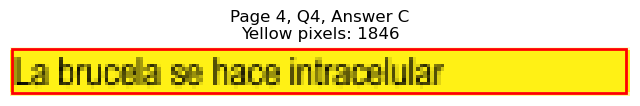

Page 4, Q4 - D: Detected box: x0=334.6, y0=337.5, x1=469.1, y1=350.1
Page 4, Q4, D: Yellow pixels: 0
Page 4, Q4, D: Total non-white pixels: 691
Page 4, Q4, D: Yellow percentage: 0.0%


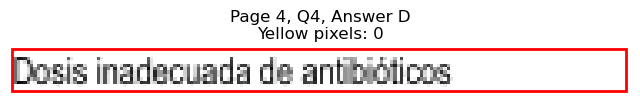

Page 4, Q4 - E: Detected box: x0=334.1, y0=350.2, x1=498.6, y1=362.9
Page 4, Q4, E: Yellow pixels: 0
Page 4, Q4, E: Total non-white pixels: 781
Page 4, Q4, E: Yellow percentage: 0.0%


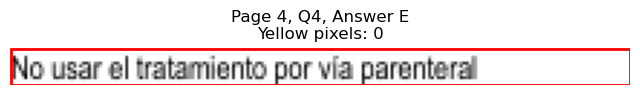


Page 4, Q4 - Selected Answer: C (based on yellow pixel count)




Page 4, Q5 - A: Detected box: x0=82.5, y0=413.3, x1=242.4, y1=426.0
Page 4, Q5, A: Yellow pixels: 0
Page 4, Q5, A: Total non-white pixels: 841
Page 4, Q5, A: Yellow percentage: 0.0%


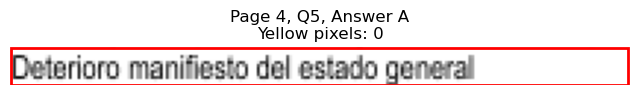

Page 4, Q5 - B: Detected box: x0=82.5, y0=425.9, x1=160.2, y1=438.6
Page 4, Q5, B: Yellow pixels: 0
Page 4, Q5, B: Total non-white pixels: 400
Page 4, Q5, B: Yellow percentage: 0.0%


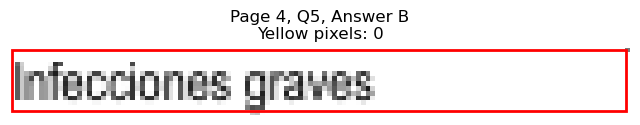

Page 4, Q5 - C: Detected box: x0=82.9, y0=438.5, x1=156.1, y1=451.2
Page 4, Q5, C: Yellow pixels: 0
Page 4, Q5, C: Total non-white pixels: 364
Page 4, Q5, C: Yellow percentage: 0.0%


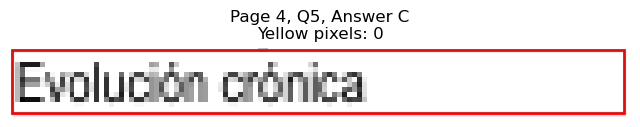

Page 4, Q5 - D: Detected box: x0=334.6, y0=413.3, x1=433.4, y1=426.0
Page 4, Q5, D: Yellow pixels: 0
Page 4, Q5, D: Total non-white pixels: 666
Page 4, Q5, D: Yellow percentage: 0.0%


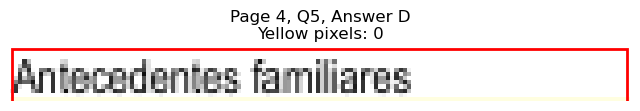

Page 4, Q5 - E: Detected box: x0=334.1, y0=425.9, x1=524.7, y1=438.6
Page 4, Q5, E: Yellow pixels: 1783
Page 4, Q5, E: Total non-white pixels: 2688
Page 4, Q5, E: Yellow percentage: 66.3%


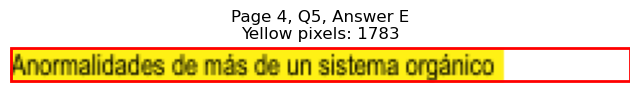


Page 4, Q5 - Selected Answer: E (based on yellow pixel count)




Page 4, Q6 - A: Detected box: x0=82.5, y0=476.3, x1=103.0, y1=489.0
Page 4, Q6, A: Yellow pixels: 0
Page 4, Q6, A: Total non-white pixels: 103
Page 4, Q6, A: Yellow percentage: 0.0%


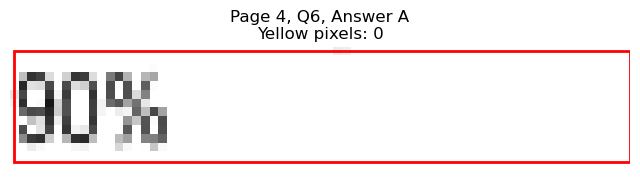

Page 4, Q6 - B: Detected box: x0=82.5, y0=489.1, x1=103.0, y1=501.7
Page 4, Q6, B: Yellow pixels: 0
Page 4, Q6, B: Total non-white pixels: 103
Page 4, Q6, B: Yellow percentage: 0.0%


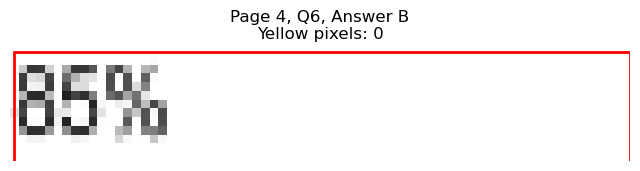

Page 4, Q6 - C: Detected box: x0=82.9, y0=501.7, x1=103.5, y1=514.3
Page 4, Q6, C: Yellow pixels: 0
Page 4, Q6, C: Total non-white pixels: 112
Page 4, Q6, C: Yellow percentage: 0.0%


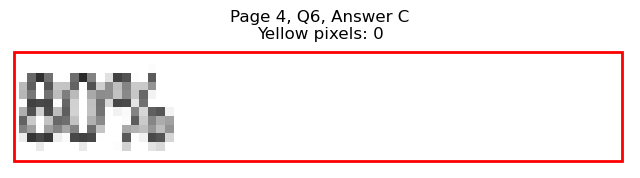

Page 4, Q6 - D: Detected box: x0=334.6, y0=476.3, x1=355.1, y1=489.0
Page 4, Q6, D: Yellow pixels: 0
Page 4, Q6, D: Total non-white pixels: 102
Page 4, Q6, D: Yellow percentage: 0.0%


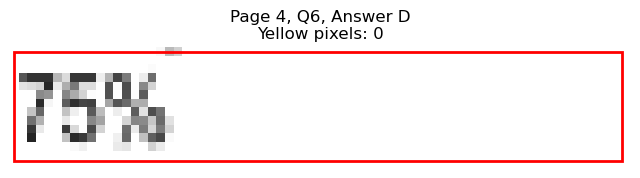

Page 4, Q6 - E: Detected box: x0=334.1, y0=489.1, x1=354.7, y1=501.7
Page 4, Q6, E: Yellow pixels: 844
Page 4, Q6, E: Total non-white pixels: 923
Page 4, Q6, E: Yellow percentage: 91.4%


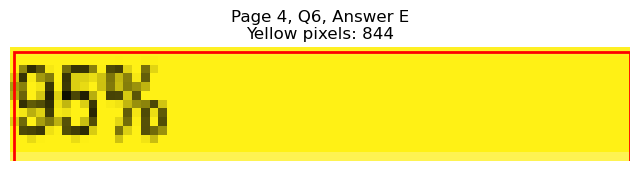


Page 4, Q6 - Selected Answer: E (based on yellow pixel count)




Page 4, Q7 - A: Detected box: x0=82.5, y0=552.2, x1=159.3, y1=564.8
Page 4, Q7, A: Yellow pixels: 0
Page 4, Q7, A: Total non-white pixels: 497
Page 4, Q7, A: Yellow percentage: 0.0%


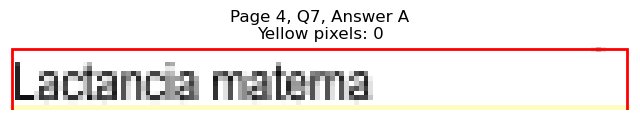

Page 4, Q7 - B: Detected box: x0=82.5, y0=564.8, x1=175.7, y1=577.4
Page 4, Q7, B: Yellow pixels: 1382
Page 4, Q7, B: Total non-white pixels: 2016
Page 4, Q7, B: Yellow percentage: 68.6%


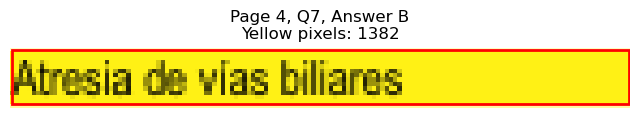

Page 4, Q7 - C: Detected box: x0=82.9, y0=577.4, x1=176.2, y1=590.0
Page 4, Q7, C: Yellow pixels: 0
Page 4, Q7, C: Total non-white pixels: 628
Page 4, Q7, C: Yellow percentage: 0.0%


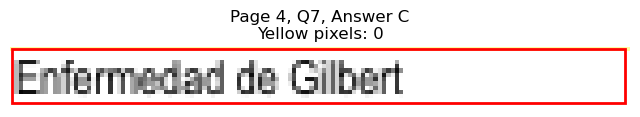

Page 4, Q7 - D: Detected box: x0=334.6, y0=552.2, x1=433.4, y1=564.8
Page 4, Q7, D: Yellow pixels: 0
Page 4, Q7, D: Total non-white pixels: 515
Page 4, Q7, D: Yellow percentage: 0.0%


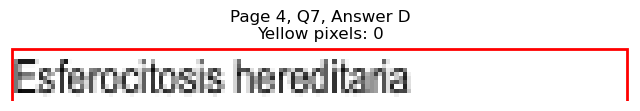

Page 4, Q7 - E: Detected box: x0=334.1, y0=564.8, x1=445.5, y1=577.4
Page 4, Q7, E: Yellow pixels: 0
Page 4, Q7, E: Total non-white pixels: 542
Page 4, Q7, E: Yellow percentage: 0.0%


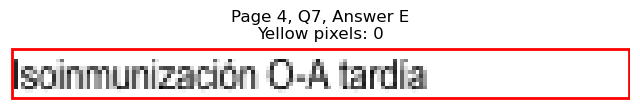


Page 4, Q7 - Selected Answer: B (based on yellow pixel count)




Page 4, Q8 - A: Detected box: x0=82.5, y0=627.9, x1=428.0, y1=640.6
Page 4, Q8, A: Yellow pixels: 396
Page 4, Q8, A: Total non-white pixels: 2050
Page 4, Q8, A: Yellow percentage: 19.3%


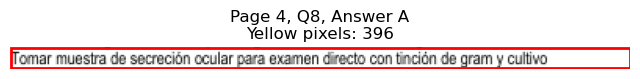

Page 4, Q8 - B: Detected box: x0=82.5, y0=640.5, x1=410.5, y1=653.2
Page 4, Q8, B: Yellow pixels: 3652
Page 4, Q8, B: Total non-white pixels: 5306
Page 4, Q8, B: Yellow percentage: 68.8%


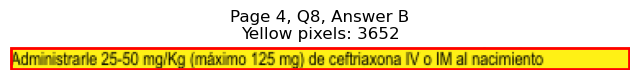

Page 4, Q8 - C: Detected box: x0=82.9, y0=653.1, x1=457.7, y1=665.8
Page 4, Q8, C: Yellow pixels: 0
Page 4, Q8, C: Total non-white pixels: 1739
Page 4, Q8, C: Yellow percentage: 0.0%


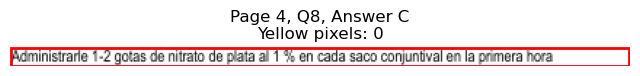

Page 4, Q8 - D: Detected box: x0=82.9, y0=665.7, x1=443.1, y1=678.4
Page 4, Q8, D: Yellow pixels: 0
Page 4, Q8, D: Total non-white pixels: 1783
Page 4, Q8, D: Yellow percentage: 0.0%


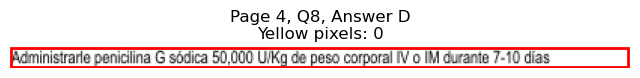

Page 4, Q8 - E: Detected box: x0=82.5, y0=678.3, x1=321.8, y1=691.0
Page 4, Q8, E: Yellow pixels: 0
Page 4, Q8, E: Total non-white pixels: 1177
Page 4, Q8, E: Yellow percentage: 0.0%


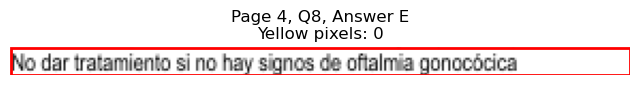


Page 4, Q8 - Selected Answer: B (based on yellow pixel count)




Page 4, Q9 - A: Detected box: x0=82.5, y0=741.4, x1=141.1, y1=754.1
Page 4, Q9, A: Yellow pixels: 0
Page 4, Q9, A: Total non-white pixels: 286
Page 4, Q9, A: Yellow percentage: 0.0%


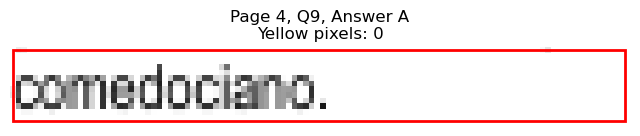

Page 4, Q9 - B: Detected box: x0=82.5, y0=754.0, x1=166.7, y1=766.7
Page 4, Q9, B: Yellow pixels: 0
Page 4, Q9, B: Total non-white pixels: 425
Page 4, Q9, B: Yellow percentage: 0.0%


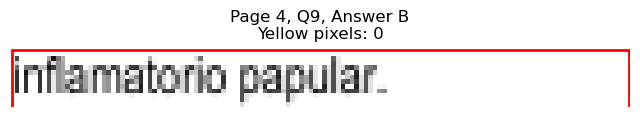

Page 4, Q9 - C: Detected box: x0=82.9, y0=766.8, x1=175.7, y1=779.4
Page 4, Q9, C: Yellow pixels: 0
Page 4, Q9, C: Total non-white pixels: 478
Page 4, Q9, C: Yellow percentage: 0.0%


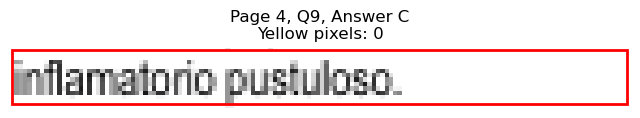

Page 4, Q9 - D: Detected box: x0=334.6, y0=741.4, x1=428.5, y1=754.1
Page 4, Q9, D: Yellow pixels: 145
Page 4, Q9, D: Total non-white pixels: 602
Page 4, Q9, D: Yellow percentage: 24.1%


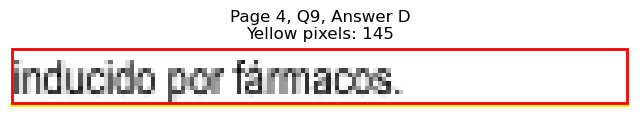

Page 4, Q9 - E: Detected box: x0=334.1, y0=754.0, x1=400.4, y1=766.7
Page 4, Q9, E: Yellow pixels: 1273
Page 4, Q9, E: Total non-white pixels: 1521
Page 4, Q9, E: Yellow percentage: 83.7%


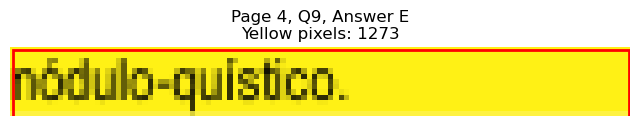


Page 4, Q9 - Selected Answer: E (based on yellow pixel count)





Page 5: Found 8 questions
Page 5, Q1 - A: Detected box: x0=82.5, y0=110.3, x1=209.0, y1=123.0
Page 5, Q1, A: Yellow pixels: 0
Page 5, Q1, A: Total non-white pixels: 610
Page 5, Q1, A: Yellow percentage: 0.0%


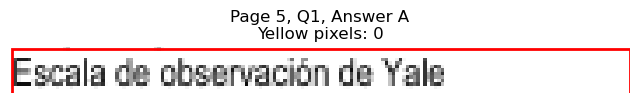

Page 5, Q1 - B: Detected box: x0=82.5, y0=122.9, x1=262.1, y1=135.6
Page 5, Q1, B: Yellow pixels: 0
Page 5, Q1, B: Total non-white pixels: 887
Page 5, Q1, B: Yellow percentage: 0.0%


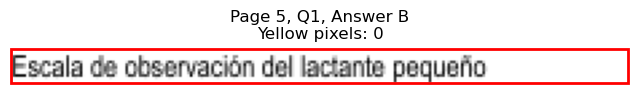

Page 5, Q1 - C: Detected box: x0=82.9, y0=135.5, x1=162.3, y1=148.2
Page 5, Q1, C: Yellow pixels: 0
Page 5, Q1, C: Total non-white pixels: 391
Page 5, Q1, C: Yellow percentage: 0.0%


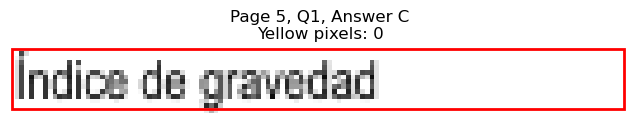

Page 5, Q1 - D: Detected box: x0=334.6, y0=110.3, x1=428.3, y1=123.0
Page 5, Q1, D: Yellow pixels: 0
Page 5, Q1, D: Total non-white pixels: 618
Page 5, Q1, D: Yellow percentage: 0.0%


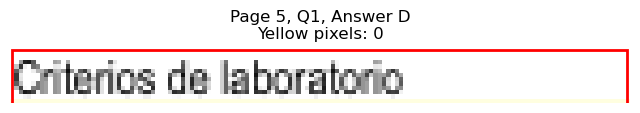

Page 5, Q1 - E: Detected box: x0=334.1, y0=122.9, x1=426.4, y1=135.6
Page 5, Q1, E: Yellow pixels: 1474
Page 5, Q1, E: Total non-white pixels: 2002
Page 5, Q1, E: Yellow percentage: 73.6%


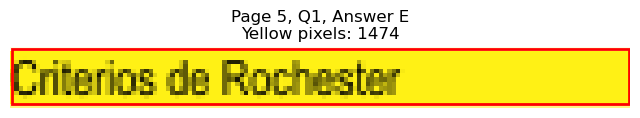


Page 5, Q1 - Selected Answer: E (based on yellow pixel count)




Page 5, Q2 - A: Detected box: x0=82.5, y0=173.4, x1=168.7, y1=186.1
Page 5, Q2, A: Yellow pixels: 0
Page 5, Q2, A: Total non-white pixels: 427
Page 5, Q2, A: Yellow percentage: 0.0%


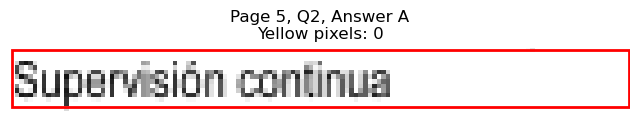

Page 5, Q2 - B: Detected box: x0=82.5, y0=186.0, x1=249.5, y1=198.7
Page 5, Q2, B: Yellow pixels: 0
Page 5, Q2, B: Total non-white pixels: 840
Page 5, Q2, B: Yellow percentage: 0.0%


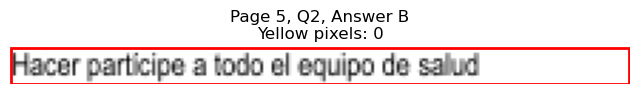

Page 5, Q2 - C: Detected box: x0=82.9, y0=198.6, x1=222.3, y1=211.3
Page 5, Q2, C: Yellow pixels: 0
Page 5, Q2, C: Total non-white pixels: 742
Page 5, Q2, C: Yellow percentage: 0.0%


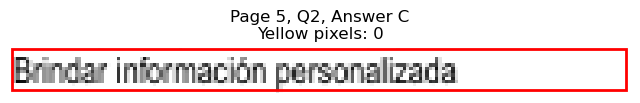

Page 5, Q2 - D: Detected box: x0=334.6, y0=173.4, x1=515.7, y1=186.1
Page 5, Q2, D: Yellow pixels: 192
Page 5, Q2, D: Total non-white pixels: 1085
Page 5, Q2, D: Yellow percentage: 17.7%


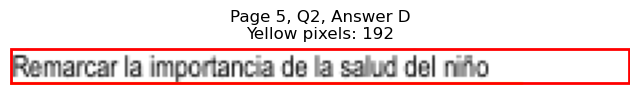

Page 5, Q2 - E: Detected box: x0=334.1, y0=186.0, x1=526.9, y1=198.7
Page 5, Q2, E: Yellow pixels: 1775
Page 5, Q2, E: Total non-white pixels: 2496
Page 5, Q2, E: Yellow percentage: 71.1%


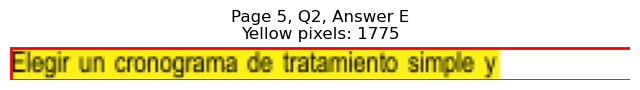


Page 5, Q2 - Selected Answer: E (based on yellow pixel count)




Page 5, Q3 - A: Detected box: x0=82.5, y0=261.7, x1=141.1, y1=274.4
Page 5, Q3, A: Yellow pixels: 0
Page 5, Q3, A: Total non-white pixels: 292
Page 5, Q3, A: Yellow percentage: 0.0%


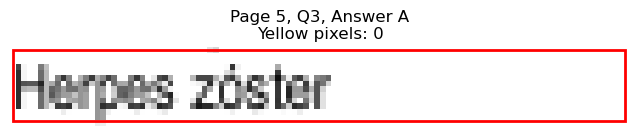

Page 5, Q3 - B: Detected box: x0=82.5, y0=274.5, x1=128.7, y1=287.1
Page 5, Q3, B: Yellow pixels: 0
Page 5, Q3, B: Total non-white pixels: 234
Page 5, Q3, B: Yellow percentage: 0.0%


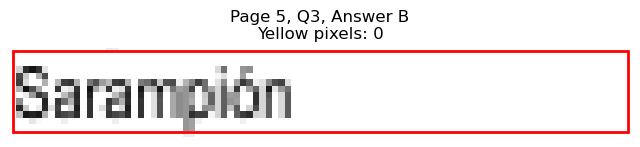

Page 5, Q3 - C: Detected box: x0=82.9, y0=287.1, x1=119.1, y1=299.7
Page 5, Q3, C: Yellow pixels: 0
Page 5, Q3, C: Total non-white pixels: 175
Page 5, Q3, C: Yellow percentage: 0.0%


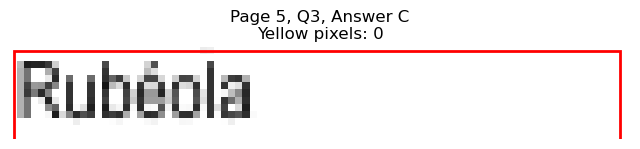

Page 5, Q3 - D: Detected box: x0=334.6, y0=261.7, x1=369.8, y1=274.4
Page 5, Q3, D: Yellow pixels: 0
Page 5, Q3, D: Total non-white pixels: 177
Page 5, Q3, D: Yellow percentage: 0.0%


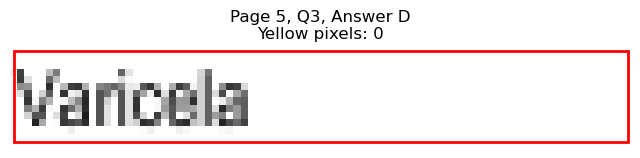

Page 5, Q3 - E: Detected box: x0=334.1, y0=274.5, x1=403.9, y1=287.1
Page 5, Q3, E: Yellow pixels: 1281
Page 5, Q3, E: Total non-white pixels: 1680
Page 5, Q3, E: Yellow percentage: 76.2%


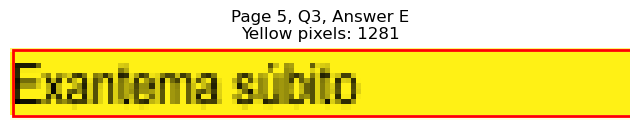


Page 5, Q3 - Selected Answer: E (based on yellow pixel count)




Page 5, Q4 - A: Detected box: x0=82.5, y0=337.5, x1=132.6, y1=350.1
Page 5, Q4, A: Yellow pixels: 0
Page 5, Q4, A: Total non-white pixels: 262
Page 5, Q4, A: Yellow percentage: 0.0%


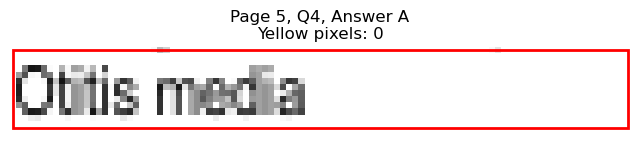

Page 5, Q4 - B: Detected box: x0=82.5, y0=350.2, x1=140.7, y1=362.9
Page 5, Q4, B: Yellow pixels: 1155
Page 5, Q4, B: Total non-white pixels: 1417
Page 5, Q4, B: Yellow percentage: 81.5%


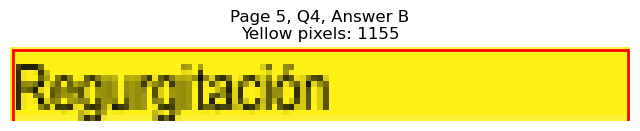

Page 5, Q4 - C: Detected box: x0=82.9, y0=362.8, x1=155.7, y1=375.5
Page 5, Q4, C: Yellow pixels: 116
Page 5, Q4, C: Total non-white pixels: 500
Page 5, Q4, C: Yellow percentage: 23.2%


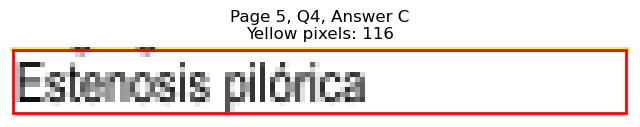

Page 5, Q4 - D: Detected box: x0=334.6, y0=337.5, x1=411.9, y1=350.1
Page 5, Q4, D: Yellow pixels: 0
Page 5, Q4, D: Total non-white pixels: 402
Page 5, Q4, D: Yellow percentage: 0.0%


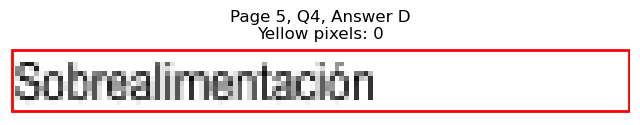

Page 5, Q4 - E: Detected box: x0=334.1, y0=350.2, x1=395.3, y1=362.9
Page 5, Q4, E: Yellow pixels: 0
Page 5, Q4, E: Total non-white pixels: 332
Page 5, Q4, E: Yellow percentage: 0.0%


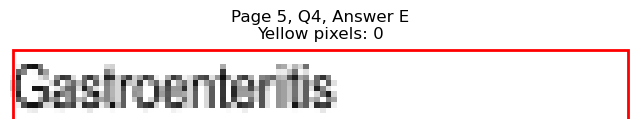


Page 5, Q4 - Selected Answer: B (based on yellow pixel count)




Page 5, Q5 - A: Detected box: x0=82.5, y0=400.6, x1=390.3, y1=413.3
Page 5, Q5, A: Yellow pixels: 3173
Page 5, Q5, A: Total non-white pixels: 5026
Page 5, Q5, A: Yellow percentage: 63.1%


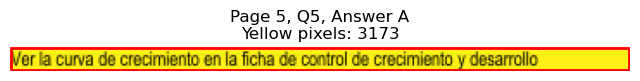

Page 5, Q5 - B: Detected box: x0=82.5, y0=413.3, x1=265.0, y1=426.0
Page 5, Q5, B: Yellow pixels: 0
Page 5, Q5, B: Total non-white pixels: 1165
Page 5, Q5, B: Yellow percentage: 0.0%


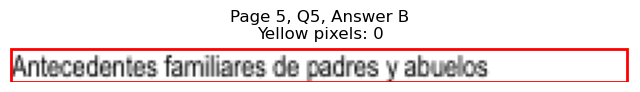

Page 5, Q5 - C: Detected box: x0=82.9, y0=425.9, x1=369.9, y1=438.6
Page 5, Q5, C: Yellow pixels: 0
Page 5, Q5, C: Total non-white pixels: 1330
Page 5, Q5, C: Yellow percentage: 0.0%


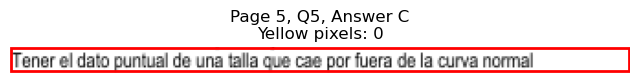

Page 5, Q5 - D: Detected box: x0=82.9, y0=438.5, x1=215.8, y1=451.2
Page 5, Q5, D: Yellow pixels: 0
Page 5, Q5, D: Total non-white pixels: 648
Page 5, Q5, D: Yellow percentage: 0.0%


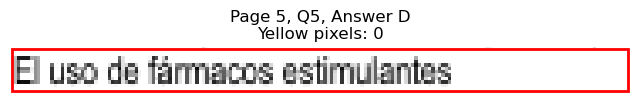

Page 5, Q5 - E: Detected box: x0=82.5, y0=451.1, x1=297.2, y1=463.8
Page 5, Q5, E: Yellow pixels: 0
Page 5, Q5, E: Total non-white pixels: 1082
Page 5, Q5, E: Yellow percentage: 0.0%


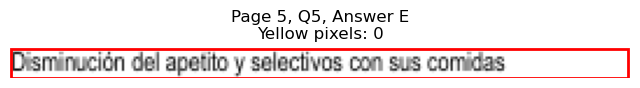


Page 5, Q5 - Selected Answer: A (based on yellow pixel count)




Page 5, Q6 - A: Detected box: x0=82.5, y0=514.3, x1=156.7, y1=526.9
Page 5, Q6, A: Yellow pixels: 0
Page 5, Q6, A: Total non-white pixels: 396
Page 5, Q6, A: Yellow percentage: 0.0%


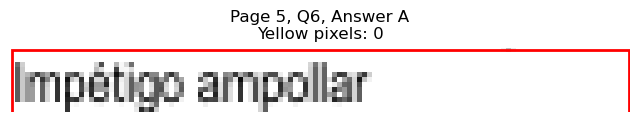

Page 5, Q6 - B: Detected box: x0=82.5, y0=526.9, x1=136.1, y1=539.5
Page 5, Q6, B: Yellow pixels: 0
Page 5, Q6, B: Total non-white pixels: 283
Page 5, Q6, B: Yellow percentage: 0.0%


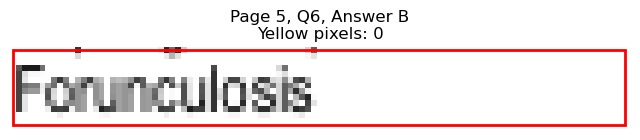

Page 5, Q6 - C: Detected box: x0=82.9, y0=539.5, x1=167.7, y1=552.1
Page 5, Q6, C: Yellow pixels: 0
Page 5, Q6, C: Total non-white pixels: 457
Page 5, Q6, C: Yellow percentage: 0.0%


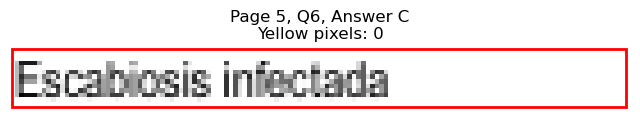

Page 5, Q6 - D: Detected box: x0=334.6, y0=514.3, x1=364.7, y1=526.9
Page 5, Q6, D: Yellow pixels: 945
Page 5, Q6, D: Total non-white pixels: 1053
Page 5, Q6, D: Yellow percentage: 89.7%


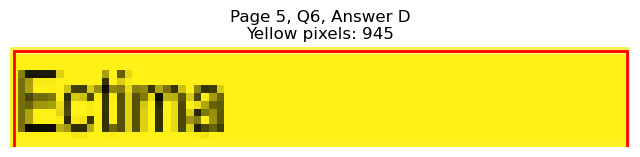

Page 5, Q6 - E: Detected box: x0=334.1, y0=526.9, x1=423.9, y1=539.5
Page 5, Q6, E: Yellow pixels: 140
Page 5, Q6, E: Total non-white pixels: 587
Page 5, Q6, E: Yellow percentage: 23.9%


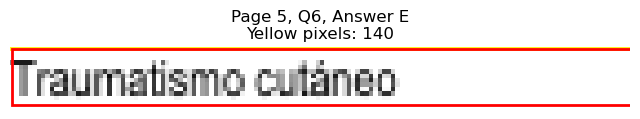


Page 5, Q6 - Selected Answer: D (based on yellow pixel count)




Page 5, Q7 - A: Detected box: x0=82.5, y0=602.6, x1=320.8, y1=615.2
Page 5, Q7, A: Yellow pixels: 2784
Page 5, Q7, A: Total non-white pixels: 4046
Page 5, Q7, A: Yellow percentage: 68.8%


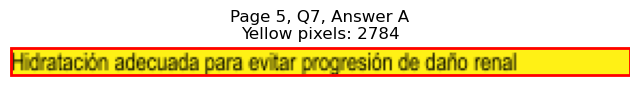

Page 5, Q7 - B: Detected box: x0=82.5, y0=615.2, x1=329.7, y1=627.8
Page 5, Q7, B: Yellow pixels: 0
Page 5, Q7, B: Total non-white pixels: 1602
Page 5, Q7, B: Yellow percentage: 0.0%


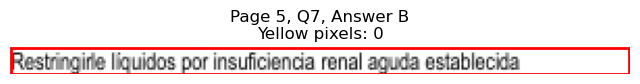

Page 5, Q7 - C: Detected box: x0=82.9, y0=627.9, x1=290.1, y1=640.6
Page 5, Q7, C: Yellow pixels: 0
Page 5, Q7, C: Total non-white pixels: 1017
Page 5, Q7, C: Yellow percentage: 0.0%


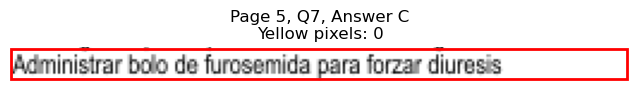

Page 5, Q7 - D: Detected box: x0=82.9, y0=640.5, x1=265.5, y1=653.2
Page 5, Q7, D: Yellow pixels: 0
Page 5, Q7, D: Total non-white pixels: 917
Page 5, Q7, D: Yellow percentage: 0.0%


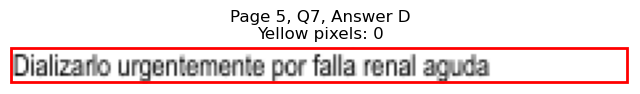

Page 5, Q7 - E: Detected box: x0=82.5, y0=653.1, x1=273.0, y1=665.8
Page 5, Q7, E: Yellow pixels: 0
Page 5, Q7, E: Total non-white pixels: 976
Page 5, Q7, E: Yellow percentage: 0.0%


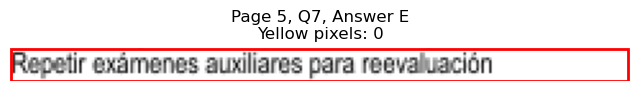


Page 5, Q7 - Selected Answer: A (based on yellow pixel count)




Page 5, Q8 - A: Detected box: x0=82.5, y0=716.3, x1=195.7, y1=728.9
Page 5, Q8, A: Yellow pixels: 0
Page 5, Q8, A: Total non-white pixels: 581
Page 5, Q8, A: Yellow percentage: 0.0%


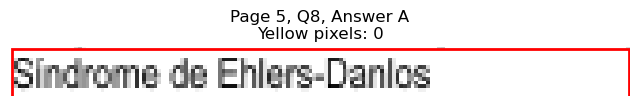

Page 5, Q8 - B: Detected box: x0=82.5, y0=728.9, x1=125.5, y1=741.5
Page 5, Q8, B: Yellow pixels: 94
Page 5, Q8, B: Total non-white pixels: 306
Page 5, Q8, B: Yellow percentage: 30.7%


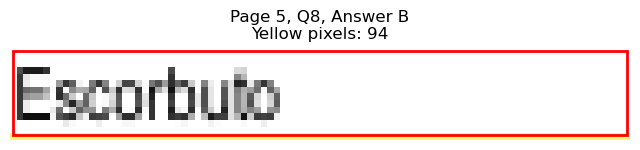

Page 5, Q8 - C: Detected box: x0=82.9, y0=741.4, x1=206.3, y1=754.1
Page 5, Q8, C: Yellow pixels: 1801
Page 5, Q8, C: Total non-white pixels: 2450
Page 5, Q8, C: Yellow percentage: 73.5%


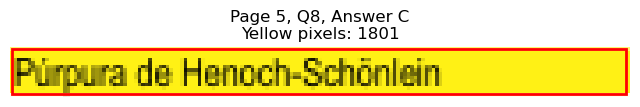

Page 5, Q8 - D: Detected box: x0=334.6, y0=716.3, x1=479.6, y1=728.9
Page 5, Q8, D: Yellow pixels: 0
Page 5, Q8, D: Total non-white pixels: 686
Page 5, Q8, D: Yellow percentage: 0.0%


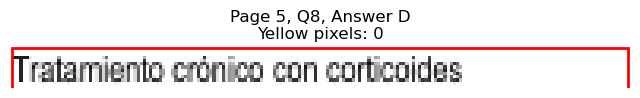

Page 5, Q8 - E: Detected box: x0=334.1, y0=728.9, x1=410.3, y1=741.5
Page 5, Q8, E: Yellow pixels: 0
Page 5, Q8, E: Total non-white pixels: 408
Page 5, Q8, E: Yellow percentage: 0.0%


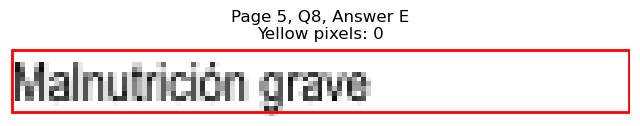


Page 5, Q8 - Selected Answer: C (based on yellow pixel count)





Page 6: Found 8 questions
Page 6, Q1 - A: Detected box: x0=82.5, y0=110.3, x1=288.5, y1=123.0
Page 6, Q1, A: Yellow pixels: 0
Page 6, Q1, A: Total non-white pixels: 1091
Page 6, Q1, A: Yellow percentage: 0.0%


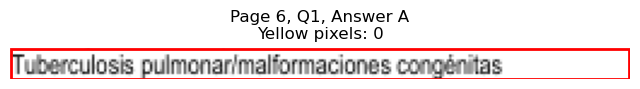

Page 6, Q1 - B: Detected box: x0=82.5, y0=122.9, x1=284.1, y1=135.6
Page 6, Q1, B: Yellow pixels: 0
Page 6, Q1, B: Total non-white pixels: 1054
Page 6, Q1, B: Yellow percentage: 0.0%


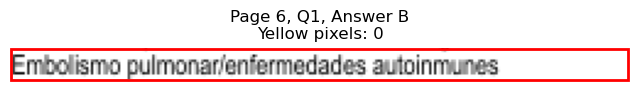

Page 6, Q1 - C: Detected box: x0=82.9, y0=135.5, x1=295.5, y1=148.2
Page 6, Q1, C: Yellow pixels: 0
Page 6, Q1, C: Total non-white pixels: 1147
Page 6, Q1, C: Yellow percentage: 0.0%


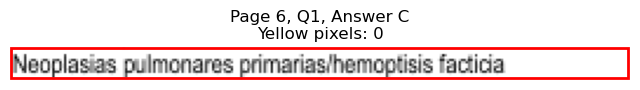

Page 6, Q1 - D: Detected box: x0=82.9, y0=148.2, x1=351.8, y1=160.9
Page 6, Q1, D: Yellow pixels: 0
Page 6, Q1, D: Total non-white pixels: 1694
Page 6, Q1, D: Yellow percentage: 0.0%


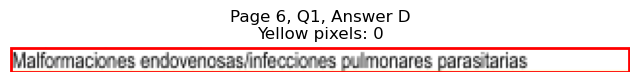

Page 6, Q1 - E: Detected box: x0=82.5, y0=160.8, x1=245.4, y1=173.5
Page 6, Q1, E: Yellow pixels: 2119
Page 6, Q1, E: Total non-white pixels: 2996
Page 6, Q1, E: Yellow percentage: 70.7%


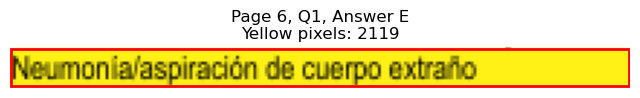


Page 6, Q1 - Selected Answer: E (based on yellow pixel count)




Page 6, Q2 - A: Detected box: x0=82.5, y0=223.9, x1=125.5, y1=236.6
Page 6, Q2, A: Yellow pixels: 1040
Page 6, Q2, A: Total non-white pixels: 1316
Page 6, Q2, A: Yellow percentage: 79.0%


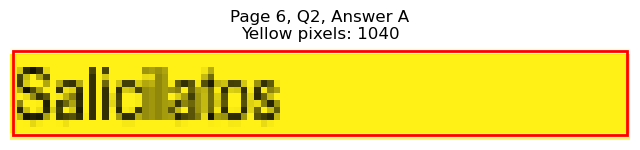

Page 6, Q2 - B: Detected box: x0=82.5, y0=236.5, x1=130.6, y1=249.2
Page 6, Q2, B: Yellow pixels: 99
Page 6, Q2, B: Total non-white pixels: 320
Page 6, Q2, B: Yellow percentage: 30.9%


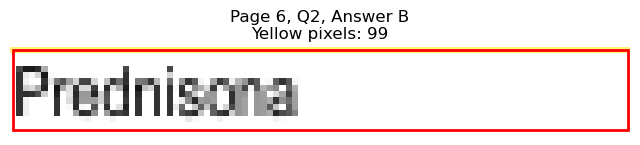

Page 6, Q2 - C: Detected box: x0=82.9, y0=249.1, x1=129.6, y1=261.8
Page 6, Q2, C: Yellow pixels: 0
Page 6, Q2, C: Total non-white pixels: 228
Page 6, Q2, C: Yellow percentage: 0.0%


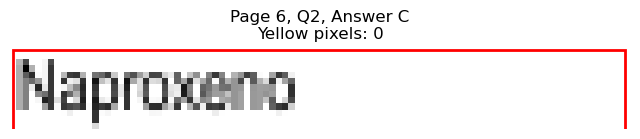

Page 6, Q2 - D: Detected box: x0=334.6, y0=223.9, x1=387.8, y1=236.6
Page 6, Q2, D: Yellow pixels: 0
Page 6, Q2, D: Total non-white pixels: 263
Page 6, Q2, D: Yellow percentage: 0.0%


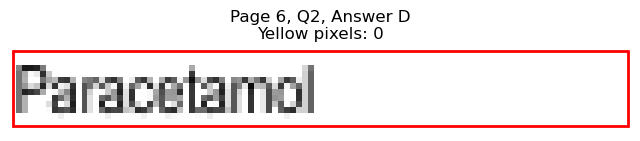

Page 6, Q2 - E: Detected box: x0=334.1, y0=236.5, x1=379.7, y1=249.2
Page 6, Q2, E: Yellow pixels: 0
Page 6, Q2, E: Total non-white pixels: 231
Page 6, Q2, E: Yellow percentage: 0.0%


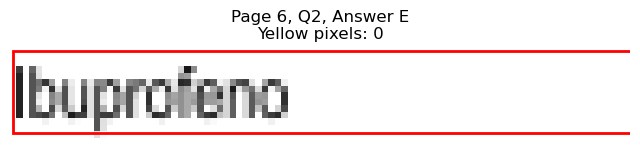


Page 6, Q2 - Selected Answer: A (based on yellow pixel count)




Page 6, Q3 - A: Detected box: x0=82.5, y0=312.3, x1=208.8, y1=324.9
Page 6, Q3, A: Yellow pixels: 0
Page 6, Q3, A: Total non-white pixels: 652
Page 6, Q3, A: Yellow percentage: 0.0%


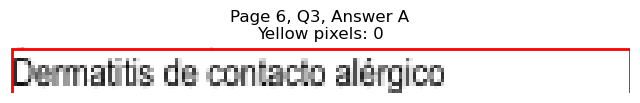

Page 6, Q3 - B: Detected box: x0=82.5, y0=324.9, x1=157.2, y1=337.5
Page 6, Q3, B: Yellow pixels: 0
Page 6, Q3, B: Total non-white pixels: 403
Page 6, Q3, B: Yellow percentage: 0.0%


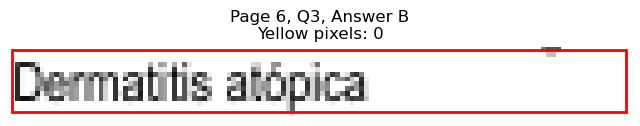

Page 6, Q3 - C: Detected box: x0=82.9, y0=337.5, x1=170.7, y1=350.1
Page 6, Q3, C: Yellow pixels: 0
Page 6, Q3, C: Total non-white pixels: 449
Page 6, Q3, C: Yellow percentage: 0.0%


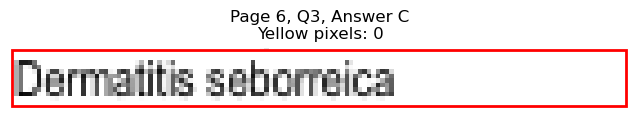

Page 6, Q3 - D: Detected box: x0=334.6, y0=312.3, x1=459.5, y1=324.9
Page 6, Q3, D: Yellow pixels: 1775
Page 6, Q3, D: Total non-white pixels: 2288
Page 6, Q3, D: Yellow percentage: 77.6%


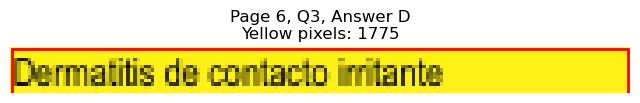

Page 6, Q3 - E: Detected box: x0=334.1, y0=324.9, x1=382.3, y1=337.5
Page 6, Q3, E: Yellow pixels: 99
Page 6, Q3, E: Total non-white pixels: 353
Page 6, Q3, E: Yellow percentage: 28.0%


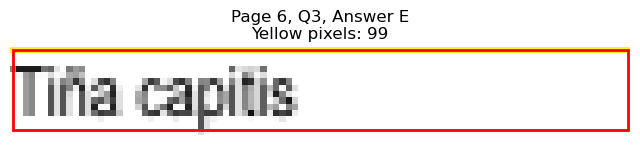


Page 6, Q3 - Selected Answer: D (based on yellow pixel count)




Page 6, Q4 - A: Detected box: x0=82.5, y0=375.4, x1=214.8, y1=388.1
Page 6, Q4, A: Yellow pixels: 183
Page 6, Q4, A: Total non-white pixels: 862
Page 6, Q4, A: Yellow percentage: 21.2%


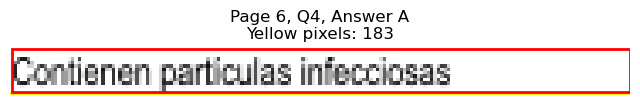

Page 6, Q4 - B: Detected box: x0=82.5, y0=388.0, x1=227.0, y1=400.7
Page 6, Q4, B: Yellow pixels: 1978
Page 6, Q4, B: Total non-white pixels: 2535
Page 6, Q4, B: Yellow percentage: 78.0%


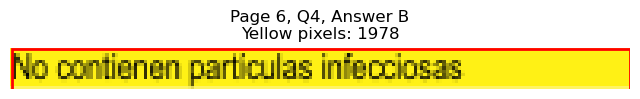

Page 6, Q4 - C: Detected box: x0=82.9, y0=400.6, x1=299.6, y1=413.3
Page 6, Q4, C: Yellow pixels: 268
Page 6, Q4, C: Total non-white pixels: 1315
Page 6, Q4, C: Yellow percentage: 20.4%


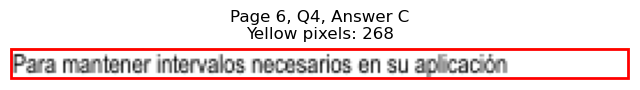

Page 6, Q4 - D: Detected box: x0=82.9, y0=413.3, x1=221.4, y1=426.0
Page 6, Q4, D: Yellow pixels: 0
Page 6, Q4, D: Total non-white pixels: 707
Page 6, Q4, D: Yellow percentage: 0.0%


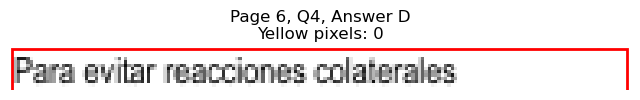

Page 6, Q4 - E: Detected box: x0=82.5, y0=425.9, x1=311.7, y1=438.6
Page 6, Q4, E: Yellow pixels: 0
Page 6, Q4, E: Total non-white pixels: 1138
Page 6, Q4, E: Yellow percentage: 0.0%


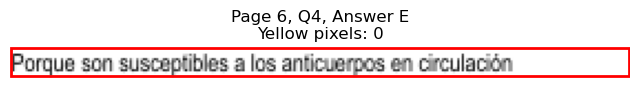


Page 6, Q4 - Selected Answer: B (based on yellow pixel count)




Page 6, Q5 - A: Detected box: x0=70.8, y0=476.3, x1=79.3, y1=489.0
Page 6, Q5, A: Yellow pixels: 728
Page 6, Q5, A: Total non-white pixels: 840
Page 6, Q5, A: Yellow percentage: 86.7%


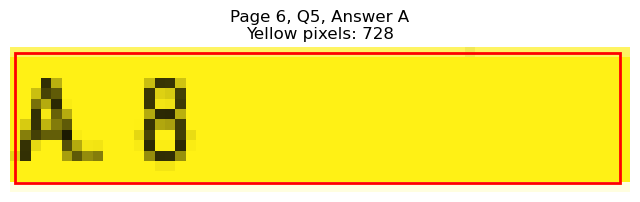

Page 6, Q5 - B: Detected box: x0=82.5, y0=489.1, x1=95.1, y1=501.7
Page 6, Q5, B: Yellow pixels: 0
Page 6, Q5, B: Total non-white pixels: 110
Page 6, Q5, B: Yellow percentage: 0.0%


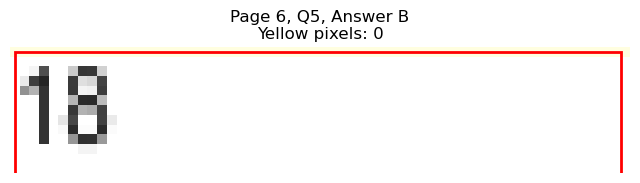

Page 6, Q5 - C: Detected box: x0=82.9, y0=501.7, x1=95.5, y1=514.3
Page 6, Q5, C: Yellow pixels: 0
Page 6, Q5, C: Total non-white pixels: 57
Page 6, Q5, C: Yellow percentage: 0.0%


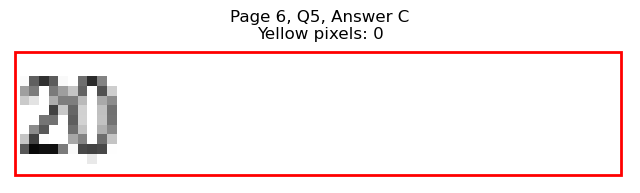

Page 6, Q5 - D: Detected box: x0=334.6, y0=476.3, x1=347.2, y1=489.0
Page 6, Q5, D: Yellow pixels: 0
Page 6, Q5, D: Total non-white pixels: 59
Page 6, Q5, D: Yellow percentage: 0.0%


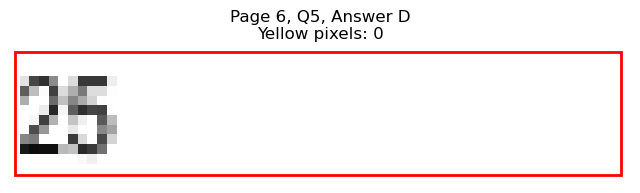

Page 6, Q5 - E: Detected box: x0=334.1, y0=489.1, x1=346.7, y1=501.7
Page 6, Q5, E: Yellow pixels: 0
Page 6, Q5, E: Total non-white pixels: 64
Page 6, Q5, E: Yellow percentage: 0.0%


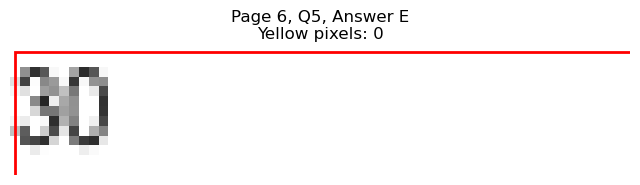


Page 6, Q5 - Selected Answer: A (based on yellow pixel count)




Page 6, Q6 - A: Detected box: x0=82.5, y0=577.4, x1=117.0, y1=590.0
Page 6, Q6, A: Yellow pixels: 86
Page 6, Q6, A: Total non-white pixels: 331
Page 6, Q6, A: Yellow percentage: 26.0%


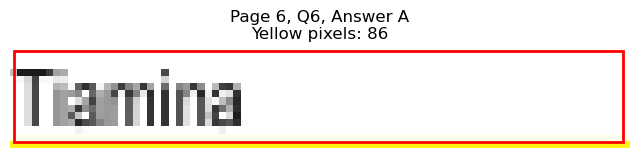

Page 6, Q6 - B: Detected box: x0=82.5, y0=590.0, x1=128.7, y1=602.6
Page 6, Q6, B: Yellow pixels: 1094
Page 6, Q6, B: Total non-white pixels: 1358
Page 6, Q6, B: Yellow percentage: 80.6%


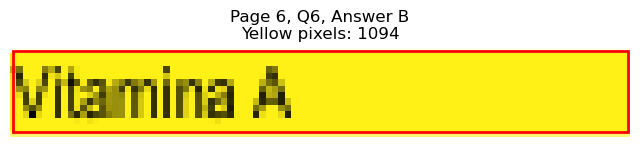

Page 6, Q6 - C: Detected box: x0=82.9, y0=602.6, x1=130.1, y1=615.2
Page 6, Q6, C: Yellow pixels: 99
Page 6, Q6, C: Total non-white pixels: 330
Page 6, Q6, C: Yellow percentage: 30.0%


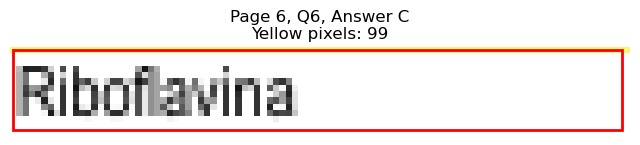

Page 6, Q6 - D: Detected box: x0=334.6, y0=577.4, x1=376.7, y1=590.0
Page 6, Q6, D: Yellow pixels: 0
Page 6, Q6, D: Total non-white pixels: 223
Page 6, Q6, D: Yellow percentage: 0.0%


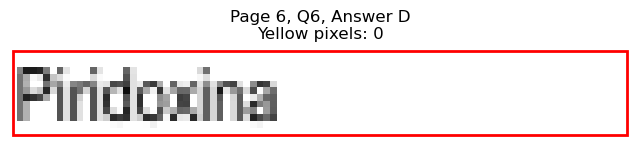

Page 6, Q6 - E: Detected box: x0=334.1, y0=590.0, x1=366.8, y1=602.6
Page 6, Q6, E: Yellow pixels: 0
Page 6, Q6, E: Total non-white pixels: 178
Page 6, Q6, E: Yellow percentage: 0.0%


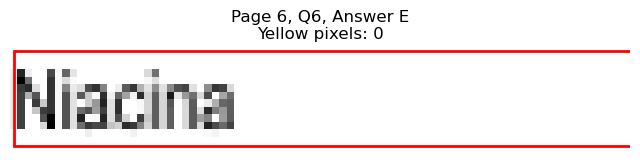


Page 6, Q6 - Selected Answer: B (based on yellow pixel count)




Page 6, Q7 - A: Detected box: x0=82.5, y0=653.1, x1=202.4, y1=665.8
Page 6, Q7, A: Yellow pixels: 0
Page 6, Q7, A: Total non-white pixels: 766
Page 6, Q7, A: Yellow percentage: 0.0%


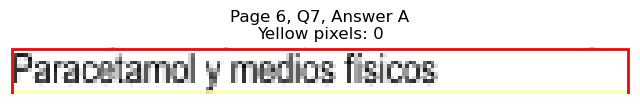

Page 6, Q7 - B: Detected box: x0=82.5, y0=665.7, x1=255.5, y1=678.4
Page 6, Q7, B: Yellow pixels: 1633
Page 6, Q7, B: Total non-white pixels: 2702
Page 6, Q7, B: Yellow percentage: 60.4%


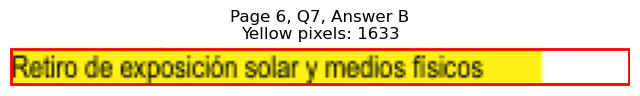

Page 6, Q7 - C: Detected box: x0=82.9, y0=678.3, x1=193.2, y1=691.0
Page 6, Q7, C: Yellow pixels: 3
Page 6, Q7, C: Total non-white pixels: 711
Page 6, Q7, C: Yellow percentage: 0.4%


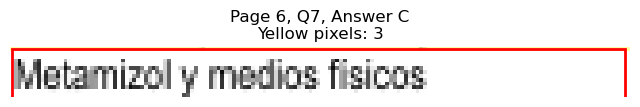

Page 6, Q7 - D: Detected box: x0=334.6, y0=653.1, x1=487.2, y1=665.8
Page 6, Q7, D: Yellow pixels: 0
Page 6, Q7, D: Total non-white pixels: 773
Page 6, Q7, D: Yellow percentage: 0.0%


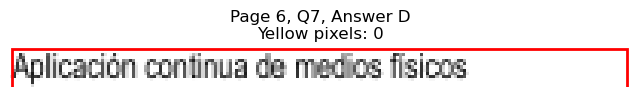

Page 6, Q7 - E: Detected box: x0=334.1, y0=665.7, x1=450.5, y1=678.4
Page 6, Q7, E: Yellow pixels: 0
Page 6, Q7, E: Total non-white pixels: 584
Page 6, Q7, E: Yellow percentage: 0.0%


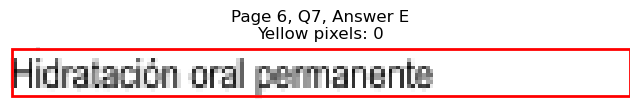


Page 6, Q7 - Selected Answer: B (based on yellow pixel count)




Page 6, Q8 - A: Detected box: x0=82.5, y0=741.4, x1=120.4, y1=754.1
Page 6, Q8, A: Yellow pixels: 0
Page 6, Q8, A: Total non-white pixels: 173
Page 6, Q8, A: Yellow percentage: 0.0%


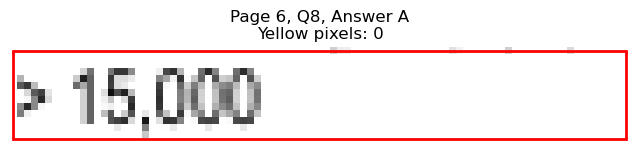

Page 6, Q8 - B: Detected box: x0=82.5, y0=754.0, x1=112.6, y1=766.7
Page 6, Q8, B: Yellow pixels: 0
Page 6, Q8, B: Total non-white pixels: 146
Page 6, Q8, B: Yellow percentage: 0.0%


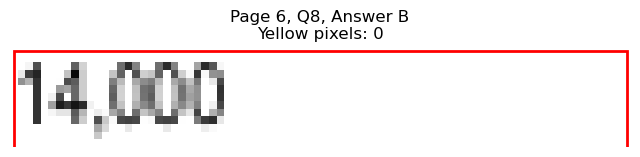

Page 6, Q8 - C: Detected box: x0=82.9, y0=766.8, x1=113.1, y1=779.4
Page 6, Q8, C: Yellow pixels: 0
Page 6, Q8, C: Total non-white pixels: 140
Page 6, Q8, C: Yellow percentage: 0.0%


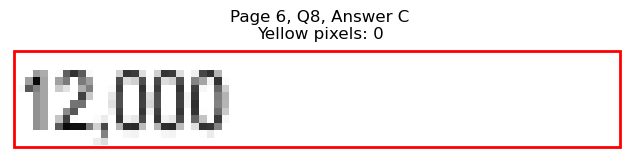

Page 6, Q8 - D: Detected box: x0=334.6, y0=741.4, x1=367.5, y1=754.1
Page 6, Q8, D: Yellow pixels: 963
Page 6, Q8, D: Total non-white pixels: 1176
Page 6, Q8, D: Yellow percentage: 81.9%


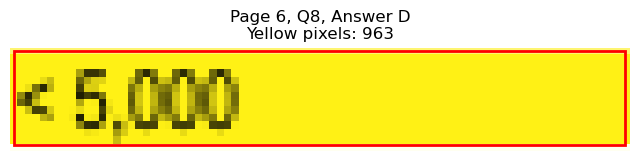

Page 6, Q8 - E: Detected box: x0=334.1, y0=754.0, x1=372.1, y1=766.7
Page 6, Q8, E: Yellow pixels: 0
Page 6, Q8, E: Total non-white pixels: 253
Page 6, Q8, E: Yellow percentage: 0.0%


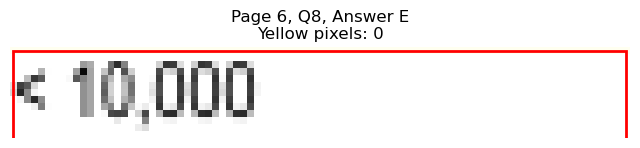


Page 6, Q8 - Selected Answer: D (based on yellow pixel count)





Page 7: Found 8 questions
Page 7, Q1 - A: Detected box: x0=82.5, y0=122.9, x1=205.4, y1=135.6
Page 7, Q1, A: Yellow pixels: 0
Page 7, Q1, A: Total non-white pixels: 657
Page 7, Q1, A: Yellow percentage: 0.0%


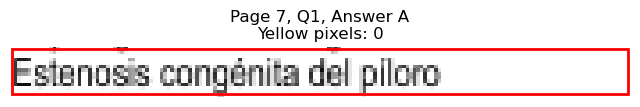

Page 7, Q1 - B: Detected box: x0=82.5, y0=135.5, x1=172.7, y1=148.2
Page 7, Q1, B: Yellow pixels: 0
Page 7, Q1, B: Total non-white pixels: 460
Page 7, Q1, B: Yellow percentage: 0.0%


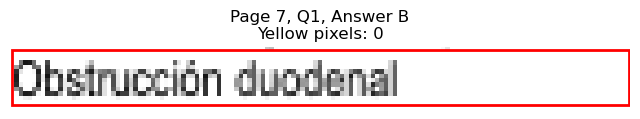

Page 7, Q1 - C: Detected box: x0=82.9, y0=148.2, x1=138.6, y1=160.9
Page 7, Q1, C: Yellow pixels: 1175
Page 7, Q1, C: Total non-white pixels: 1391
Page 7, Q1, C: Yellow percentage: 84.5%


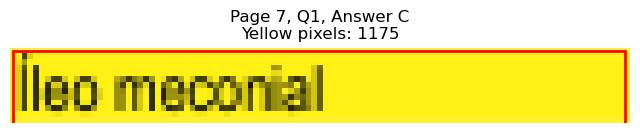

Page 7, Q1 - D: Detected box: x0=334.6, y0=122.9, x1=449.9, y1=135.6
Page 7, Q1, D: Yellow pixels: 0
Page 7, Q1, D: Total non-white pixels: 548
Page 7, Q1, D: Yellow percentage: 0.0%


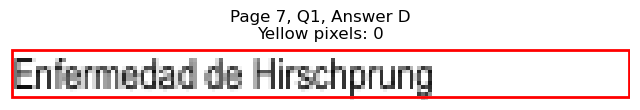

Page 7, Q1 - E: Detected box: x0=334.1, y0=135.5, x1=433.4, y1=148.2
Page 7, Q1, E: Yellow pixels: 0
Page 7, Q1, E: Total non-white pixels: 525
Page 7, Q1, E: Yellow percentage: 0.0%


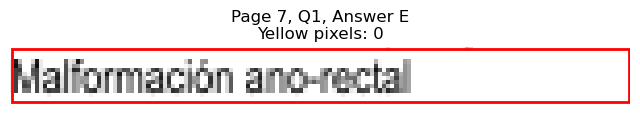


Page 7, Q1 - Selected Answer: C (based on yellow pixel count)




Page 7, Q2 - A: Detected box: x0=82.5, y0=211.3, x1=153.1, y1=224.0
Page 7, Q2, A: Yellow pixels: 0
Page 7, Q2, A: Total non-white pixels: 337
Page 7, Q2, A: Yellow percentage: 0.0%


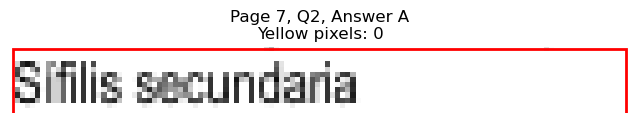

Page 7, Q2 - B: Detected box: x0=82.5, y0=223.9, x1=160.7, y1=236.6
Page 7, Q2, B: Yellow pixels: 0
Page 7, Q2, B: Total non-white pixels: 394
Page 7, Q2, B: Yellow percentage: 0.0%


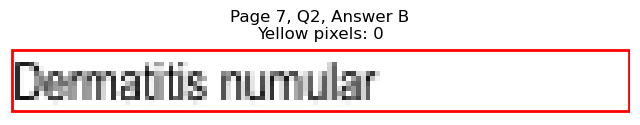

Page 7, Q2 - C: Detected box: x0=82.9, y0=236.5, x1=192.3, y1=249.2
Page 7, Q2, C: Yellow pixels: 0
Page 7, Q2, C: Total non-white pixels: 546
Page 7, Q2, C: Yellow percentage: 0.0%


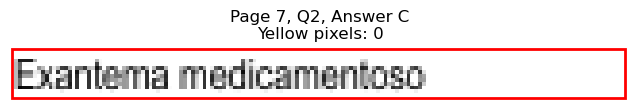

Page 7, Q2 - D: Detected box: x0=334.6, y0=211.3, x1=400.9, y1=224.0
Page 7, Q2, D: Yellow pixels: 1251
Page 7, Q2, D: Total non-white pixels: 1521
Page 7, Q2, D: Yellow percentage: 82.2%


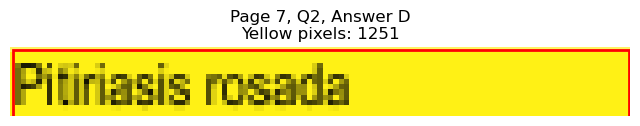

Page 7, Q2 - E: Detected box: x0=334.1, y0=223.9, x1=389.3, y1=236.6
Page 7, Q2, E: Yellow pixels: 106
Page 7, Q2, E: Total non-white pixels: 377
Page 7, Q2, E: Yellow percentage: 28.1%


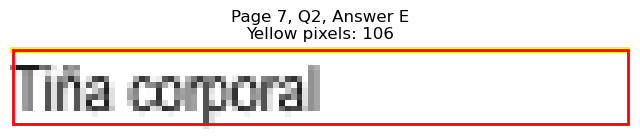


Page 7, Q2 - Selected Answer: D (based on yellow pixel count)




Page 7, Q3 - A: Detected box: x0=82.5, y0=299.7, x1=220.8, y1=312.3
Page 7, Q3, A: Yellow pixels: 0
Page 7, Q3, A: Total non-white pixels: 730
Page 7, Q3, A: Yellow percentage: 0.0%


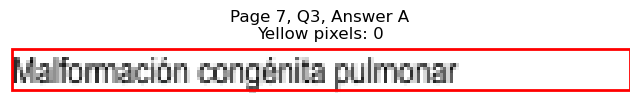

Page 7, Q3 - B: Detected box: x0=82.5, y0=312.3, x1=186.7, y1=324.9
Page 7, Q3, B: Yellow pixels: 0
Page 7, Q3, B: Total non-white pixels: 532
Page 7, Q3, B: Yellow percentage: 0.0%


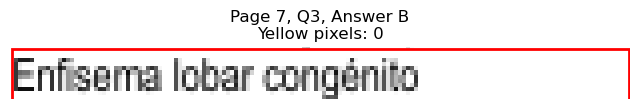

Page 7, Q3 - C: Detected box: x0=82.9, y0=324.9, x1=210.4, y1=337.5
Page 7, Q3, C: Yellow pixels: 0
Page 7, Q3, C: Total non-white pixels: 658
Page 7, Q3, C: Yellow percentage: 0.0%


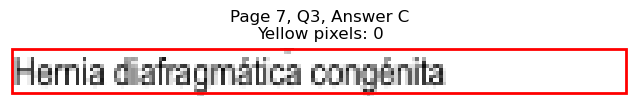

Page 7, Q3 - D: Detected box: x0=334.6, y0=299.7, x1=453.4, y1=312.3
Page 7, Q3, D: Yellow pixels: 1533
Page 7, Q3, D: Total non-white pixels: 2380
Page 7, Q3, D: Yellow percentage: 64.4%


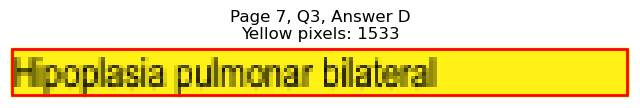

Page 7, Q3 - E: Detected box: x0=334.1, y0=312.3, x1=417.4, y1=324.9
Page 7, Q3, E: Yellow pixels: 0
Page 7, Q3, E: Total non-white pixels: 543
Page 7, Q3, E: Yellow percentage: 0.0%


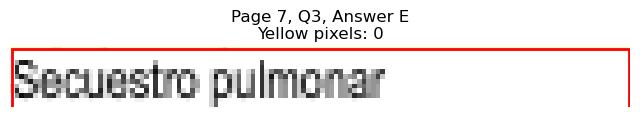


Page 7, Q3 - Selected Answer: D (based on yellow pixel count)




Page 7, Q4 - A: Detected box: x0=82.5, y0=388.0, x1=124.1, y1=400.7
Page 7, Q4, A: Yellow pixels: 0
Page 7, Q4, A: Total non-white pixels: 186
Page 7, Q4, A: Yellow percentage: 0.0%


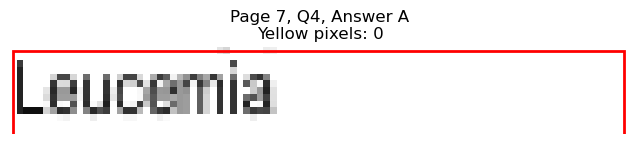

Page 7, Q4 - B: Detected box: x0=82.5, y0=400.6, x1=202.4, y1=413.3
Page 7, Q4, B: Yellow pixels: 0
Page 7, Q4, B: Total non-white pixels: 607
Page 7, Q4, B: Yellow percentage: 0.0%


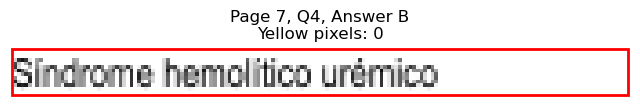

Page 7, Q4 - C: Detected box: x0=82.9, y0=413.3, x1=199.8, y1=426.0
Page 7, Q4, C: Yellow pixels: 0
Page 7, Q4, C: Total non-white pixels: 597
Page 7, Q4, C: Yellow percentage: 0.0%


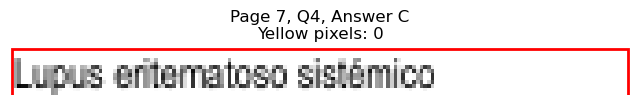

Page 7, Q4 - D: Detected box: x0=334.6, y0=388.0, x1=451.5, y1=400.7
Page 7, Q4, D: Yellow pixels: 0
Page 7, Q4, D: Total non-white pixels: 759
Page 7, Q4, D: Yellow percentage: 0.0%


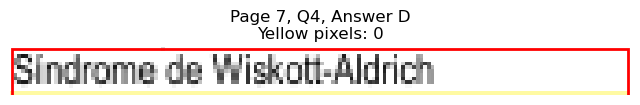

Page 7, Q4 - E: Detected box: x0=334.1, y0=400.6, x1=480.7, y1=413.3
Page 7, Q4, E: Yellow pixels: 1670
Page 7, Q4, E: Total non-white pixels: 2688
Page 7, Q4, E: Yellow percentage: 62.1%


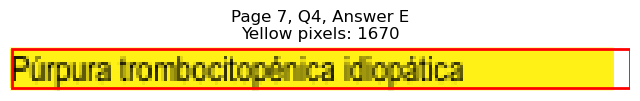


Page 7, Q4 - Selected Answer: E (based on yellow pixel count)




Page 7, Q5 - A: Detected box: x0=82.5, y0=489.1, x1=169.7, y1=501.7
Page 7, Q5, A: Yellow pixels: 0
Page 7, Q5, A: Total non-white pixels: 462
Page 7, Q5, A: Yellow percentage: 0.0%


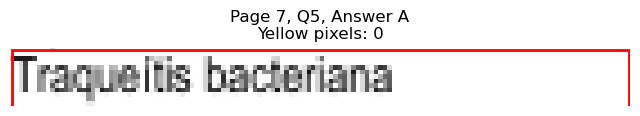

Page 7, Q5 - B: Detected box: x0=82.5, y0=501.7, x1=202.4, y1=514.3
Page 7, Q5, B: Yellow pixels: 171
Page 7, Q5, B: Total non-white pixels: 756
Page 7, Q5, B: Yellow percentage: 22.6%


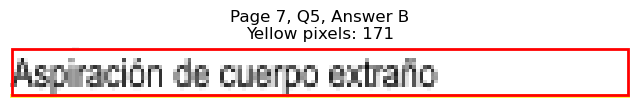

Page 7, Q5 - C: Detected box: x0=82.9, y0=514.3, x1=160.7, y1=526.9
Page 7, Q5, C: Yellow pixels: 1394
Page 7, Q5, C: Total non-white pixels: 1677
Page 7, Q5, C: Yellow percentage: 83.1%


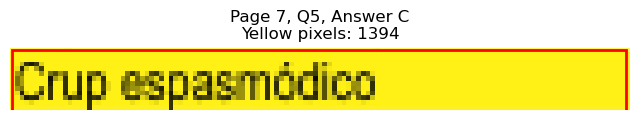

Page 7, Q5 - D: Detected box: x0=334.6, y0=489.1, x1=437.9, y1=501.7
Page 7, Q5, D: Yellow pixels: 0
Page 7, Q5, D: Total non-white pixels: 512
Page 7, Q5, D: Yellow percentage: 0.0%


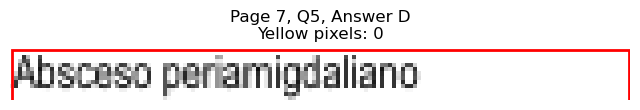

Page 7, Q5 - E: Detected box: x0=334.1, y0=501.7, x1=387.3, y1=514.3
Page 7, Q5, E: Yellow pixels: 0
Page 7, Q5, E: Total non-white pixels: 293
Page 7, Q5, E: Yellow percentage: 0.0%


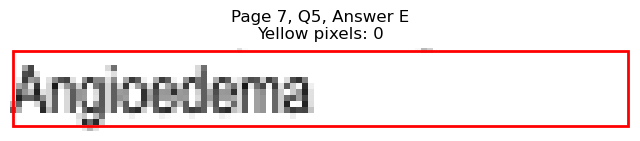


Page 7, Q5 - Selected Answer: C (based on yellow pixel count)




Page 7, Q6 - A: Detected box: x0=82.5, y0=577.4, x1=183.3, y1=590.0
Page 7, Q6, A: Yellow pixels: 0
Page 7, Q6, A: Total non-white pixels: 540
Page 7, Q6, A: Yellow percentage: 0.0%


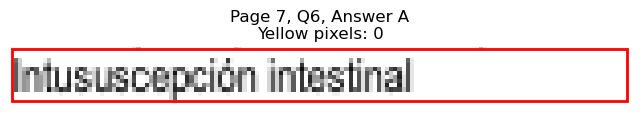

Page 7, Q6 - B: Detected box: x0=82.5, y0=590.0, x1=156.3, y1=602.6
Page 7, Q6, B: Yellow pixels: 0
Page 7, Q6, B: Total non-white pixels: 379
Page 7, Q6, B: Yellow percentage: 0.0%


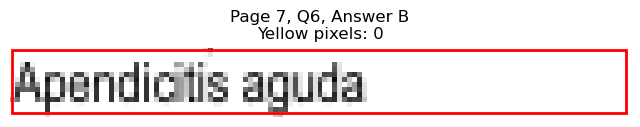

Page 7, Q6 - C: Detected box: x0=82.9, y0=602.6, x1=244.5, y1=615.2
Page 7, Q6, C: Yellow pixels: 0
Page 7, Q6, C: Total non-white pixels: 831
Page 7, Q6, C: Yellow percentage: 0.0%


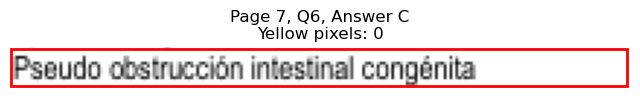

Page 7, Q6 - D: Detected box: x0=334.6, y0=577.4, x1=421.9, y1=590.0
Page 7, Q6, D: Yellow pixels: 138
Page 7, Q6, D: Total non-white pixels: 746
Page 7, Q6, D: Yellow percentage: 18.5%


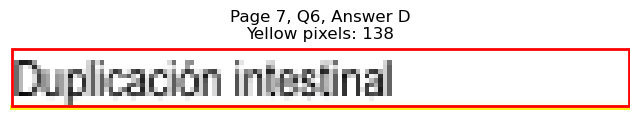

Page 7, Q6 - E: Detected box: x0=334.1, y0=590.0, x1=422.9, y1=602.6
Page 7, Q6, E: Yellow pixels: 1468
Page 7, Q6, E: Total non-white pixels: 1946
Page 7, Q6, E: Yellow percentage: 75.4%


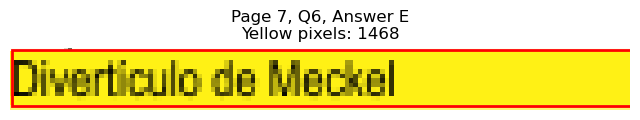


Page 7, Q6 - Selected Answer: E (based on yellow pixel count)




Page 7, Q7 - A: Detected box: x0=82.5, y0=653.1, x1=148.7, y1=665.8
Page 7, Q7, A: Yellow pixels: 1283
Page 7, Q7, A: Total non-white pixels: 1521
Page 7, Q7, A: Yellow percentage: 84.4%


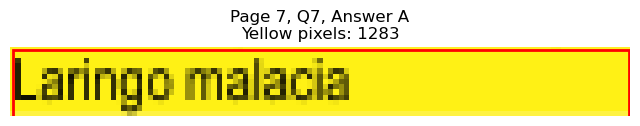

Page 7, Q7 - B: Detected box: x0=82.5, y0=665.7, x1=209.0, y1=678.4
Page 7, Q7, B: Yellow pixels: 175
Page 7, Q7, B: Total non-white pixels: 853
Page 7, Q7, B: Yellow percentage: 20.5%


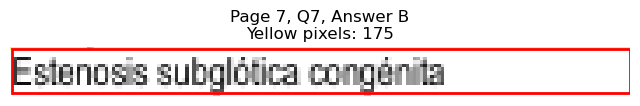

Page 7, Q7 - C: Detected box: x0=82.9, y0=678.3, x1=124.1, y1=691.0
Page 7, Q7, C: Yellow pixels: 0
Page 7, Q7, C: Total non-white pixels: 247
Page 7, Q7, C: Yellow percentage: 0.0%


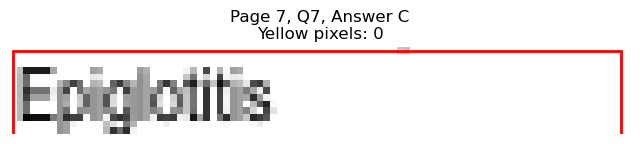

Page 7, Q7 - D: Detected box: x0=334.6, y0=653.1, x1=465.4, y1=665.8
Page 7, Q7, D: Yellow pixels: 0
Page 7, Q7, D: Total non-white pixels: 642
Page 7, Q7, D: Yellow percentage: 0.0%


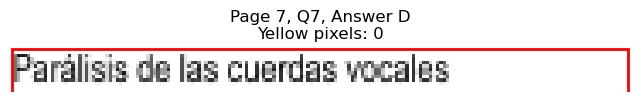

Page 7, Q7 - E: Detected box: x0=334.1, y0=665.7, x1=439.0, y1=678.4
Page 7, Q7, E: Yellow pixels: 0
Page 7, Q7, E: Total non-white pixels: 522
Page 7, Q7, E: Yellow percentage: 0.0%


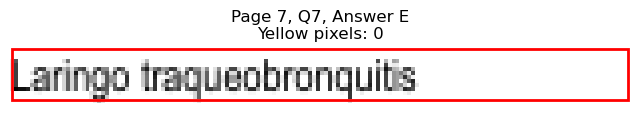


Page 7, Q7 - Selected Answer: A (based on yellow pixel count)




Page 7, Q8 - A: Detected box: x0=82.5, y0=741.4, x1=170.2, y1=754.1
Page 7, Q8, A: Yellow pixels: 0
Page 7, Q8, A: Total non-white pixels: 463
Page 7, Q8, A: Yellow percentage: 0.0%


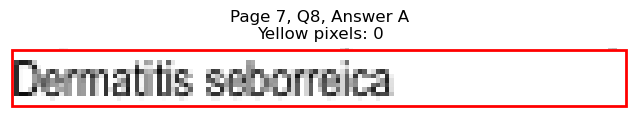

Page 7, Q8 - B: Detected box: x0=82.5, y0=754.0, x1=138.1, y1=766.7
Page 7, Q8, B: Yellow pixels: 0
Page 7, Q8, B: Total non-white pixels: 280
Page 7, Q8, B: Yellow percentage: 0.0%


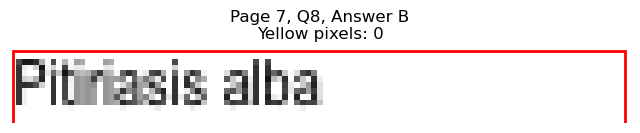

Page 7, Q8 - C: Detected box: x0=82.9, y0=766.8, x1=144.1, y1=779.4
Page 7, Q8, C: Yellow pixels: 1131
Page 7, Q8, C: Total non-white pixels: 1582
Page 7, Q8, C: Yellow percentage: 71.5%


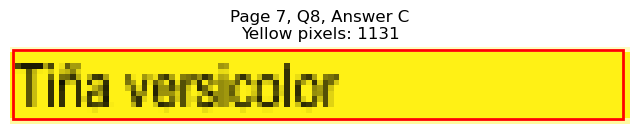

Page 7, Q8 - D: Detected box: x0=334.6, y0=741.4, x1=405.3, y1=754.1
Page 7, Q8, D: Yellow pixels: 0
Page 7, Q8, D: Total non-white pixels: 379
Page 7, Q8, D: Yellow percentage: 0.0%


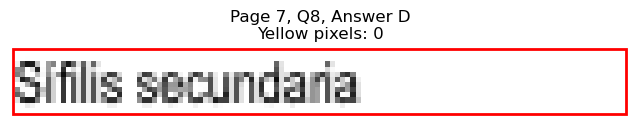

Page 7, Q8 - E: Detected box: x0=334.1, y0=754.0, x1=400.4, y1=766.7
Page 7, Q8, E: Yellow pixels: 0
Page 7, Q8, E: Total non-white pixels: 352
Page 7, Q8, E: Yellow percentage: 0.0%


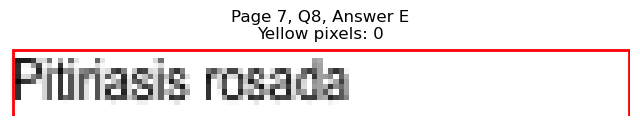


Page 7, Q8 - Selected Answer: C (based on yellow pixel count)





Page 8: Found 9 questions
Page 8, Q1 - A: Detected box: x0=82.5, y0=110.3, x1=170.7, y1=123.0
Page 8, Q1, A: Yellow pixels: 0
Page 8, Q1, A: Total non-white pixels: 595
Page 8, Q1, A: Yellow percentage: 0.0%


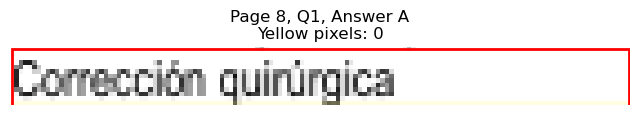

Page 8, Q1 - B: Detected box: x0=82.5, y0=122.9, x1=162.1, y1=135.6
Page 8, Q1, B: Yellow pixels: 1404
Page 8, Q1, B: Total non-white pixels: 1834
Page 8, Q1, B: Yellow percentage: 76.6%


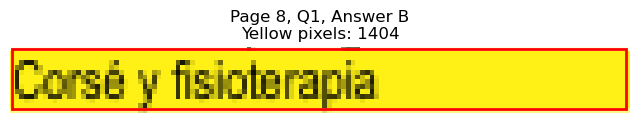

Page 8, Q1 - C: Detected box: x0=82.9, y0=135.5, x1=182.8, y1=148.2
Page 8, Q1, C: Yellow pixels: 151
Page 8, Q1, C: Total non-white pixels: 658
Page 8, Q1, C: Yellow percentage: 22.9%


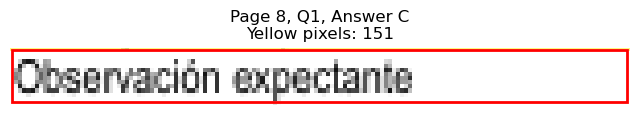

Page 8, Q1 - D: Detected box: x0=334.6, y0=110.3, x1=440.9, y1=123.0
Page 8, Q1, D: Yellow pixels: 0
Page 8, Q1, D: Total non-white pixels: 533
Page 8, Q1, D: Yellow percentage: 0.0%


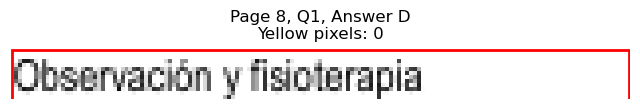

Page 8, Q1 - E: Detected box: x0=334.1, y0=122.9, x1=454.0, y1=135.6
Page 8, Q1, E: Yellow pixels: 0
Page 8, Q1, E: Total non-white pixels: 599
Page 8, Q1, E: Yellow percentage: 0.0%



Page 8, Q1 - Selected Answer: B (based on yellow pixel count)




Page 8, Q2 - A: Detected box: x0=82.5, y0=186.0, x1=239.4, y1=198.7
Page 8, Q2, A: Yellow pixels: 0
Page 8, Q2, A: Total non-white pixels: 829
Page 8, Q2, A: Yellow percentage: 0.0%


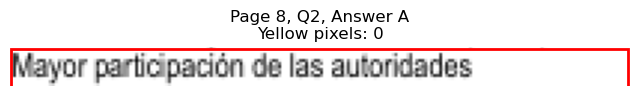

Page 8, Q2 - B: Detected box: x0=82.5, y0=198.6, x1=205.4, y1=211.3
Page 8, Q2, B: Yellow pixels: 0
Page 8, Q2, B: Total non-white pixels: 620
Page 8, Q2, B: Yellow percentage: 0.0%


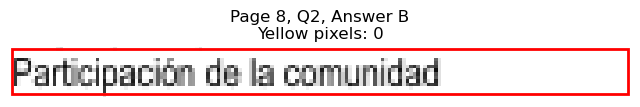

Page 8, Q2 - C: Detected box: x0=82.9, y0=211.3, x1=226.0, y1=224.0
Page 8, Q2, C: Yellow pixels: 0
Page 8, Q2, C: Total non-white pixels: 716
Page 8, Q2, C: Yellow percentage: 0.0%


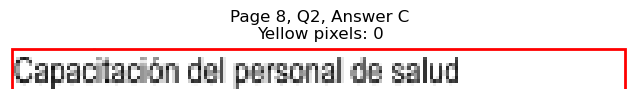

Page 8, Q2 - D: Detected box: x0=334.6, y0=186.0, x1=417.4, y1=198.7
Page 8, Q2, D: Yellow pixels: 1
Page 8, Q2, D: Total non-white pixels: 568
Page 8, Q2, D: Yellow percentage: 0.2%


Page 8, Q2 - E: Detected box: x0=474.2, y0=198.6, x1=526.9, y1=211.3
Page 8, Q2, E: Yellow pixels: 409
Page 8, Q2, E: Total non-white pixels: 728
Page 8, Q2, E: Yellow percentage: 56.2%


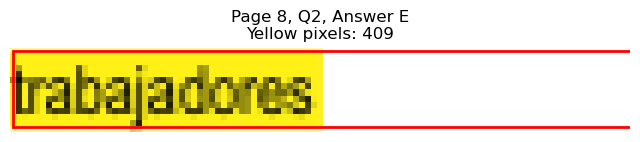


Page 8, Q2 - Selected Answer: E (based on yellow pixel count)




Page 8, Q3 - A: Detected box: x0=82.5, y0=261.7, x1=255.0, y1=274.4
Page 8, Q3, A: Yellow pixels: 0
Page 8, Q3, A: Total non-white pixels: 839
Page 8, Q3, A: Yellow percentage: 0.0%


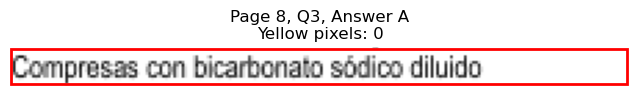

Page 8, Q3 - B: Detected box: x0=82.5, y0=274.5, x1=157.2, y1=287.1
Page 8, Q3, B: Yellow pixels: 0
Page 8, Q3, B: Total non-white pixels: 387
Page 8, Q3, B: Yellow percentage: 0.0%


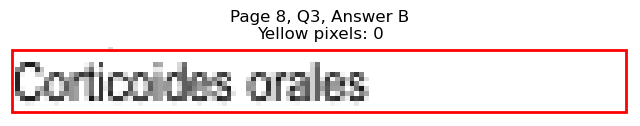

Page 8, Q3 - C: Detected box: x0=82.9, y0=287.1, x1=161.7, y1=299.7
Page 8, Q3, C: Yellow pixels: 0
Page 8, Q3, C: Total non-white pixels: 408
Page 8, Q3, C: Yellow percentage: 0.0%


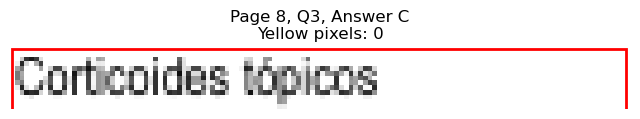

Page 8, Q3 - D: Detected box: x0=334.6, y0=261.7, x1=375.8, y1=274.4
Page 8, Q3, D: Yellow pixels: 0
Page 8, Q3, D: Total non-white pixels: 211
Page 8, Q3, D: Yellow percentage: 0.0%


Page 8, Q3 - E: Detected box: x0=334.1, y0=274.5, x1=434.0, y1=287.1
Page 8, Q3, E: Yellow pixels: 1551
Page 8, Q3, E: Total non-white pixels: 2100
Page 8, Q3, E: Yellow percentage: 73.9%


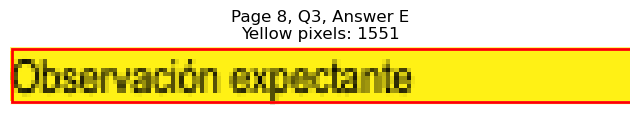


Page 8, Q3 - Selected Answer: E (based on yellow pixel count)




Page 8, Q4 - A: Detected box: x0=82.5, y0=324.9, x1=120.6, y1=337.5
Page 8, Q4, A: Yellow pixels: 0
Page 8, Q4, A: Total non-white pixels: 161
Page 8, Q4, A: Yellow percentage: 0.0%


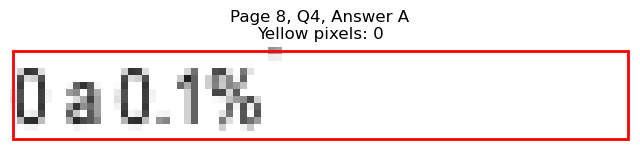

Page 8, Q4 - B: Detected box: x0=82.5, y0=337.5, x1=105.5, y1=350.1
Page 8, Q4, B: Yellow pixels: 0
Page 8, Q4, B: Total non-white pixels: 118
Page 8, Q4, B: Yellow percentage: 0.0%


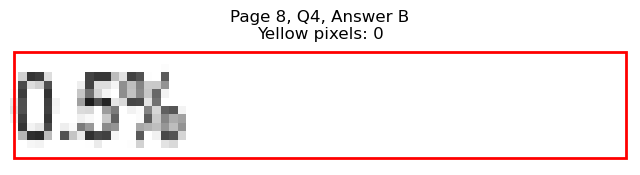

Page 8, Q4 - C: Detected box: x0=82.9, y0=350.2, x1=98.5, y1=362.9
Page 8, Q4, C: Yellow pixels: 0
Page 8, Q4, C: Total non-white pixels: 77
Page 8, Q4, C: Yellow percentage: 0.0%


Page 8, Q4 - D: Detected box: x0=334.6, y0=324.9, x1=357.7, y1=337.5
Page 8, Q4, D: Yellow pixels: 74
Page 8, Q4, D: Total non-white pixels: 181
Page 8, Q4, D: Yellow percentage: 40.9%


Page 8, Q4 - E: Detected box: x0=334.1, y0=337.5, x1=362.2, y1=350.1
Page 8, Q4, E: Yellow pixels: 934
Page 8, Q4, E: Total non-white pixels: 1106
Page 8, Q4, E: Yellow percentage: 84.4%



Page 8, Q4 - Selected Answer: E (based on yellow pixel count)




Page 8, Q5 - A: Detected box: x0=82.5, y0=388.0, x1=194.3, y1=400.7
Page 8, Q5, A: Yellow pixels: 0
Page 8, Q5, A: Total non-white pixels: 588
Page 8, Q5, A: Yellow percentage: 0.0%


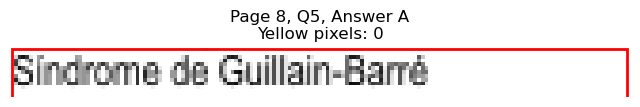

Page 8, Q5 - B: Detected box: x0=82.5, y0=400.6, x1=157.2, y1=413.3
Page 8, Q5, B: Yellow pixels: 0
Page 8, Q5, B: Total non-white pixels: 398
Page 8, Q5, B: Yellow percentage: 0.0%


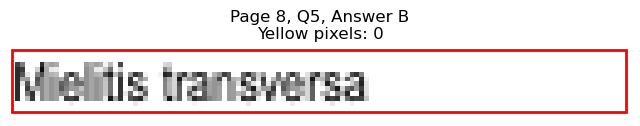

Page 8, Q5 - C: Detected box: x0=82.9, y0=413.3, x1=133.1, y1=426.0
Page 8, Q5, C: Yellow pixels: 0
Page 8, Q5, C: Total non-white pixels: 265
Page 8, Q5, C: Yellow percentage: 0.0%


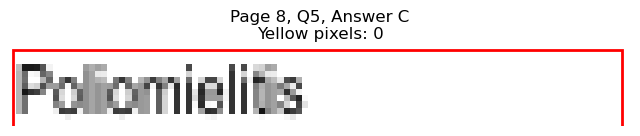

Page 8, Q5 - D: Detected box: x0=334.6, y0=388.0, x1=440.9, y1=400.7
Page 8, Q5, D: Yellow pixels: 1609
Page 8, Q5, D: Total non-white pixels: 2041
Page 8, Q5, D: Yellow percentage: 78.8%


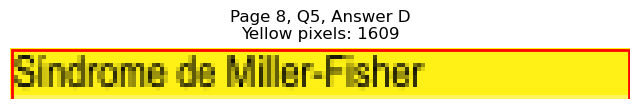

Page 8, Q5 - E: Detected box: x0=334.1, y0=400.6, x1=376.3, y1=413.3
Page 8, Q5, E: Yellow pixels: 93
Page 8, Q5, E: Total non-white pixels: 315
Page 8, Q5, E: Yellow percentage: 29.5%


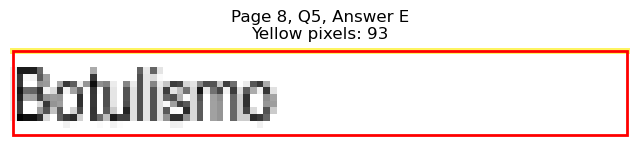


Page 8, Q5 - Selected Answer: D (based on yellow pixel count)




Page 8, Q6 - A: Detected box: x0=82.5, y0=489.1, x1=106.6, y1=501.7
Page 8, Q6, A: Yellow pixels: 0
Page 8, Q6, A: Total non-white pixels: 194
Page 8, Q6, A: Yellow percentage: 0.0%


Page 8, Q6 - B: Detected box: x0=82.5, y0=501.7, x1=118.6, y1=514.3
Page 8, Q6, B: Yellow pixels: 881
Page 8, Q6, B: Total non-white pixels: 1218
Page 8, Q6, B: Yellow percentage: 72.3%


Page 8, Q6 - C: Detected box: x0=82.9, y0=514.3, x1=143.1, y1=526.9
Page 8, Q6, C: Yellow pixels: 0
Page 8, Q6, C: Total non-white pixels: 411
Page 8, Q6, C: Yellow percentage: 0.0%


Page 8, Q6 - D: Detected box: x0=334.6, y0=489.1, x1=401.8, y1=501.7
Page 8, Q6, D: Yellow pixels: 0
Page 8, Q6, D: Total non-white pixels: 360
Page 8, Q6, D: Yellow percentage: 0.0%


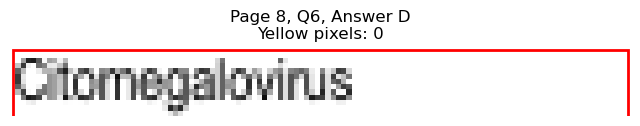

Page 8, Q6 - E: Detected box: x0=334.1, y0=501.7, x1=396.8, y1=514.3
Page 8, Q6, E: Yellow pixels: 0
Page 8, Q6, E: Total non-white pixels: 321
Page 8, Q6, E: Yellow percentage: 0.0%



Page 8, Q6 - Selected Answer: B (based on yellow pixel count)




Page 8, Q7 - A: Detected box: x0=82.5, y0=577.4, x1=142.6, y1=590.0
Page 8, Q7, A: Yellow pixels: 111
Page 8, Q7, A: Total non-white pixels: 533
Page 8, Q7, A: Yellow percentage: 20.8%


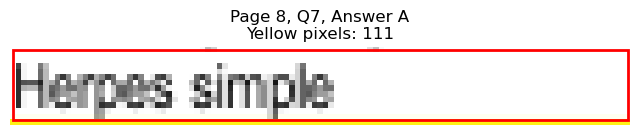

Page 8, Q7 - B: Detected box: x0=82.5, y0=590.0, x1=181.7, y1=602.6
Page 8, Q7, B: Yellow pixels: 1537
Page 8, Q7, B: Total non-white pixels: 2100
Page 8, Q7, B: Yellow percentage: 73.2%


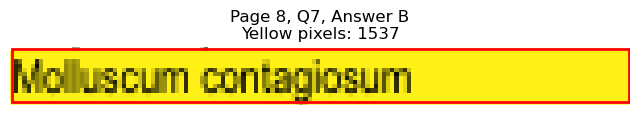

Page 8, Q7 - C: Detected box: x0=82.9, y0=602.6, x1=175.2, y1=615.2
Page 8, Q7, C: Yellow pixels: 143
Page 8, Q7, C: Total non-white pixels: 588
Page 8, Q7, C: Yellow percentage: 24.3%


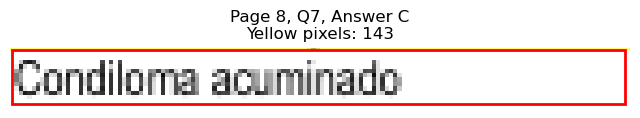

Page 8, Q7 - D: Detected box: x0=334.6, y0=577.4, x1=421.9, y1=590.0
Page 8, Q7, D: Yellow pixels: 0
Page 8, Q7, D: Total non-white pixels: 471
Page 8, Q7, D: Yellow percentage: 0.0%


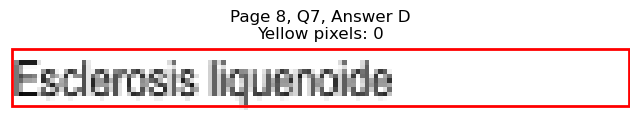

Page 8, Q7 - E: Detected box: x0=334.1, y0=590.0, x1=408.9, y1=602.6
Page 8, Q7, E: Yellow pixels: 0
Page 8, Q7, E: Total non-white pixels: 396
Page 8, Q7, E: Yellow percentage: 0.0%


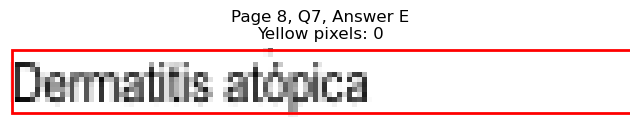


Page 8, Q7 - Selected Answer: B (based on yellow pixel count)




Page 8, Q8 - A: Detected box: x0=70.8, y0=653.1, x1=79.3, y1=665.8
Page 8, Q8, A: Yellow pixels: 0
Page 8, Q8, A: Total non-white pixels: 64
Page 8, Q8, A: Yellow percentage: 0.0%


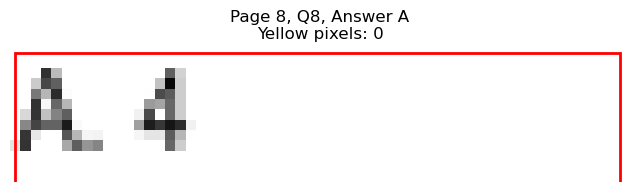

Page 8, Q8 - B: Detected box: x0=70.8, y0=665.7, x1=79.3, y1=678.4
Page 8, Q8, B: Yellow pixels: 0
Page 8, Q8, B: Total non-white pixels: 68
Page 8, Q8, B: Yellow percentage: 0.0%


Page 8, Q8 - C: Detected box: x0=70.8, y0=678.3, x1=79.8, y1=691.0
Page 8, Q8, C: Yellow pixels: 0
Page 8, Q8, C: Total non-white pixels: 55
Page 8, Q8, C: Yellow percentage: 0.0%


Page 8, Q8 - D: Detected box: x0=322.5, y0=653.1, x1=331.5, y1=665.8
Page 8, Q8, D: Yellow pixels: 730
Page 8, Q8, D: Total non-white pixels: 780
Page 8, Q8, D: Yellow percentage: 93.6%


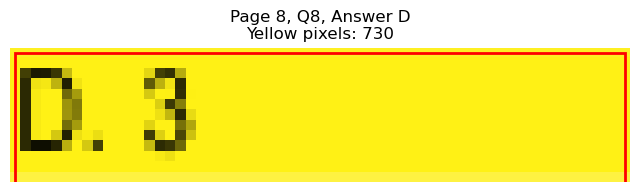

Page 8, Q8 - E: Detected box: x0=322.5, y0=665.7, x1=331.0, y1=678.4
Page 8, Q8, E: Yellow pixels: 60
Page 8, Q8, E: Total non-white pixels: 128
Page 8, Q8, E: Yellow percentage: 46.9%


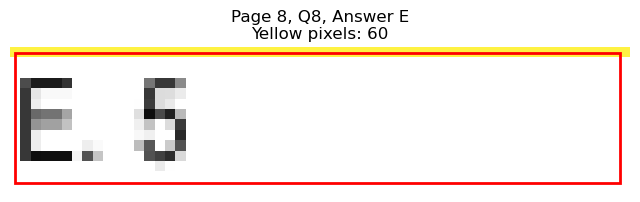


Page 8, Q8 - Selected Answer: D (based on yellow pixel count)




Page 8, Q9 - A: Detected box: x0=82.5, y0=728.9, x1=199.8, y1=741.5
Page 8, Q9, A: Yellow pixels: 0
Page 8, Q9, A: Total non-white pixels: 603
Page 8, Q9, A: Yellow percentage: 0.0%


Page 8, Q9 - B: Detected box: x0=82.5, y0=741.4, x1=220.8, y1=754.1
Page 8, Q9, B: Yellow pixels: 0
Page 8, Q9, B: Total non-white pixels: 722
Page 8, Q9, B: Yellow percentage: 0.0%


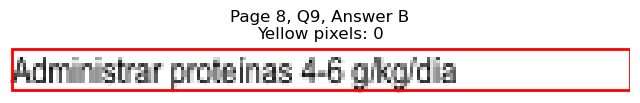

Page 8, Q9 - C: Detected box: x0=82.9, y0=754.0, x1=255.4, y1=766.7
Page 8, Q9, C: Yellow pixels: 0
Page 8, Q9, C: Total non-white pixels: 900
Page 8, Q9, C: Yellow percentage: 0.0%


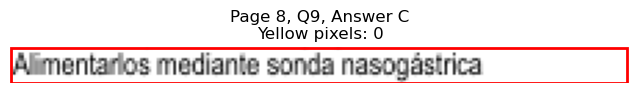

Page 8, Q9 - D: Detected box: x0=334.6, y0=728.9, x1=443.5, y1=741.5
Page 8, Q9, D: Yellow pixels: 160
Page 8, Q9, D: Total non-white pixels: 700
Page 8, Q9, D: Yellow percentage: 22.9%


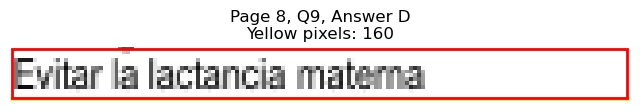

Page 8, Q9 - E: Detected box: x0=334.1, y0=741.4, x1=489.5, y1=754.1
Page 8, Q9, E: Yellow pixels: 1926
Page 8, Q9, E: Total non-white pixels: 2688
Page 8, Q9, E: Yellow percentage: 71.7%


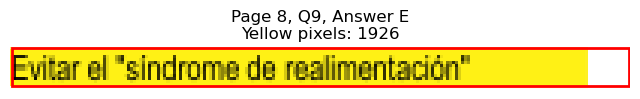


Page 8, Q9 - Selected Answer: E (based on yellow pixel count)





Page 9: Found 8 questions
Page 9, Q1 - A: Detected box: x0=82.5, y0=110.3, x1=208.4, y1=123.0
Page 9, Q1, A: Yellow pixels: 0
Page 9, Q1, A: Total non-white pixels: 644
Page 9, Q1, A: Yellow percentage: 0.0%


Page 9, Q1 - B: Detected box: x0=82.5, y0=122.9, x1=209.9, y1=135.6
Page 9, Q1, B: Yellow pixels: 0
Page 9, Q1, B: Total non-white pixels: 623
Page 9, Q1, B: Yellow percentage: 0.0%


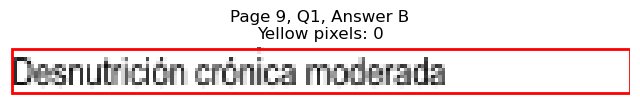

Page 9, Q1 - C: Detected box: x0=82.9, y0=135.5, x1=137.2, y1=148.2
Page 9, Q1, C: Yellow pixels: 0
Page 9, Q1, C: Total non-white pixels: 393
Page 9, Q1, C: Yellow percentage: 0.0%


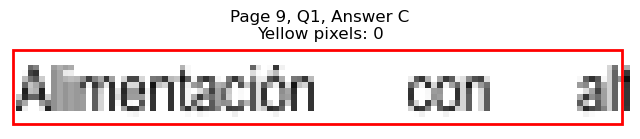

Page 9, Q1 - D: Detected box: x0=334.6, y0=110.3, x1=481.1, y1=123.0
Page 9, Q1, D: Yellow pixels: 1917
Page 9, Q1, D: Total non-white pixels: 2496
Page 9, Q1, D: Yellow percentage: 76.8%


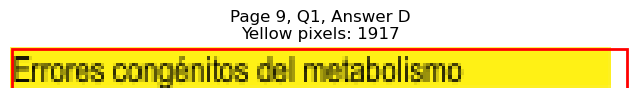

Page 9, Q1 - E: Detected box: x0=334.1, y0=122.9, x1=369.3, y1=135.6
Page 9, Q1, E: Yellow pixels: 82
Page 9, Q1, E: Total non-white pixels: 261
Page 9, Q1, E: Yellow percentage: 31.4%


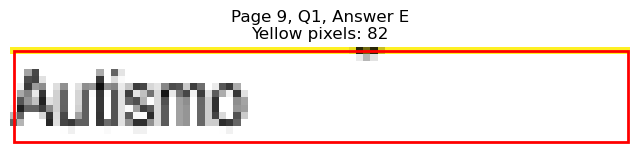


Page 9, Q1 - Selected Answer: D (based on yellow pixel count)




Page 9, Q2 - A: Detected box: x0=70.8, y0=198.6, x1=79.3, y1=211.3
Page 9, Q2, A: Yellow pixels: 0
Page 9, Q2, A: Total non-white pixels: 75
Page 9, Q2, A: Yellow percentage: 0.0%


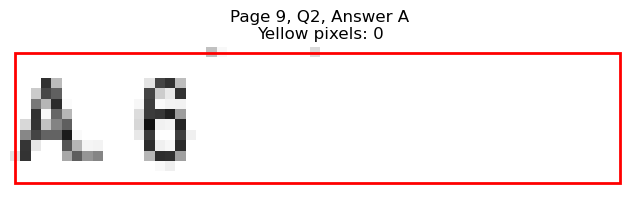

Page 9, Q2 - B: Detected box: x0=70.8, y0=211.3, x1=79.3, y1=224.0
Page 9, Q2, B: Yellow pixels: 719
Page 9, Q2, B: Total non-white pixels: 780
Page 9, Q2, B: Yellow percentage: 92.2%


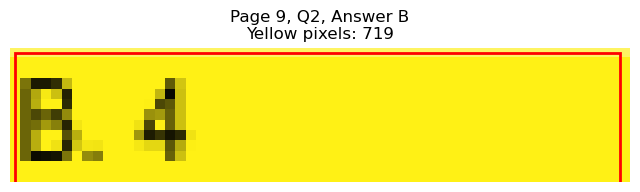

Page 9, Q2 - C: Detected box: x0=70.8, y0=223.9, x1=79.8, y1=236.6
Page 9, Q2, C: Yellow pixels: 60
Page 9, Q2, C: Total non-white pixels: 126
Page 9, Q2, C: Yellow percentage: 47.6%


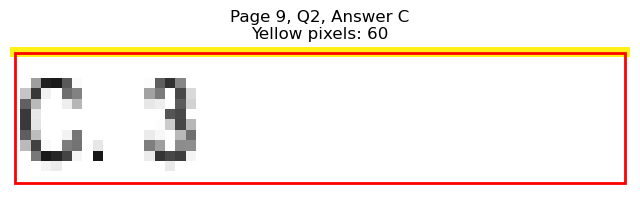

Page 9, Q2 - D: Detected box: x0=322.5, y0=198.6, x1=331.5, y1=211.3
Page 9, Q2, D: Yellow pixels: 0
Page 9, Q2, D: Total non-white pixels: 66
Page 9, Q2, D: Yellow percentage: 0.0%


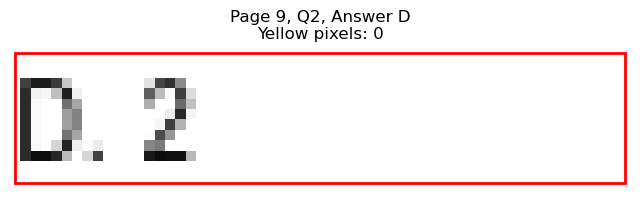

Page 9, Q2 - E: Detected box: x0=322.5, y0=211.3, x1=331.0, y1=224.0
Page 9, Q2, E: Yellow pixels: 0
Page 9, Q2, E: Total non-white pixels: 54
Page 9, Q2, E: Yellow percentage: 0.0%


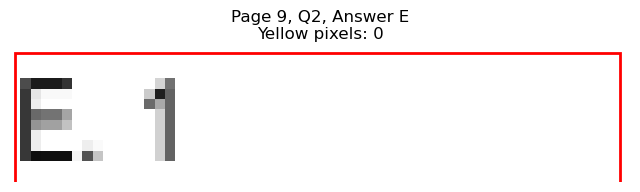


Page 9, Q2 - Selected Answer: B (based on yellow pixel count)




Page 9, Q3 - A: Detected box: x0=82.5, y0=274.5, x1=168.3, y1=287.1
Page 9, Q3, A: Yellow pixels: 0
Page 9, Q3, A: Total non-white pixels: 421
Page 9, Q3, A: Yellow percentage: 0.0%


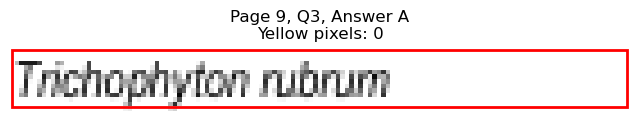

Page 9, Q3 - B: Detected box: x0=82.5, y0=287.1, x1=160.7, y1=299.7
Page 9, Q3, B: Yellow pixels: 0
Page 9, Q3, B: Total non-white pixels: 516
Page 9, Q3, B: Yellow percentage: 0.0%


Page 9, Q3 - C: Detected box: x0=82.9, y0=299.7, x1=179.8, y1=312.3
Page 9, Q3, C: Yellow pixels: 1410
Page 9, Q3, C: Total non-white pixels: 2072
Page 9, Q3, C: Yellow percentage: 68.1%


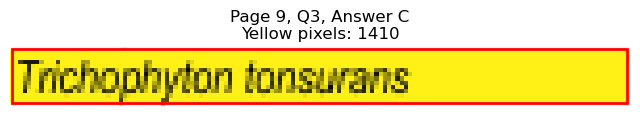

Page 9, Q3 - D: Detected box: x0=334.6, y0=274.5, x1=419.9, y1=287.1
Page 9, Q3, D: Yellow pixels: 0
Page 9, Q3, D: Total non-white pixels: 445
Page 9, Q3, D: Yellow percentage: 0.0%


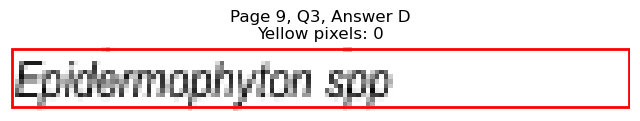

Page 9, Q3 - E: Detected box: x0=334.1, y0=287.1, x1=411.9, y1=299.7
Page 9, Q3, E: Yellow pixels: 0
Page 9, Q3, E: Total non-white pixels: 392
Page 9, Q3, E: Yellow percentage: 0.0%



Page 9, Q3 - Selected Answer: C (based on yellow pixel count)




Page 9, Q4 - A: Detected box: x0=70.8, y0=350.2, x1=79.3, y1=362.9
Page 9, Q4, A: Yellow pixels: 0
Page 9, Q4, A: Total non-white pixels: 69
Page 9, Q4, A: Yellow percentage: 0.0%


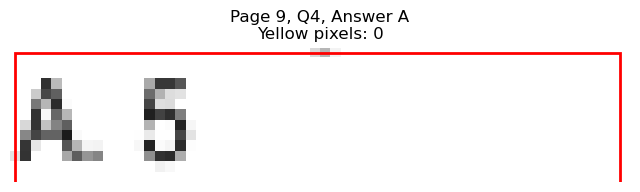

Page 9, Q4 - B: Detected box: x0=82.5, y0=362.8, x1=95.1, y1=375.5
Page 9, Q4, B: Yellow pixels: 0
Page 9, Q4, B: Total non-white pixels: 44
Page 9, Q4, B: Yellow percentage: 0.0%


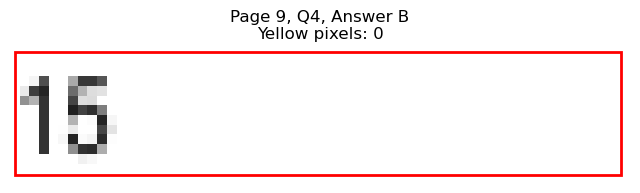

Page 9, Q4 - C: Detected box: x0=82.9, y0=375.4, x1=95.5, y1=388.1
Page 9, Q4, C: Yellow pixels: 0
Page 9, Q4, C: Total non-white pixels: 52
Page 9, Q4, C: Yellow percentage: 0.0%


Page 9, Q4 - D: Detected box: x0=334.6, y0=350.2, x1=347.2, y1=362.9
Page 9, Q4, D: Yellow pixels: 797
Page 9, Q4, D: Total non-white pixels: 832
Page 9, Q4, D: Yellow percentage: 95.8%


Page 9, Q4 - E: Detected box: x0=334.1, y0=362.8, x1=346.7, y1=375.5
Page 9, Q4, E: Yellow pixels: 63
Page 9, Q4, E: Total non-white pixels: 123
Page 9, Q4, E: Yellow percentage: 51.2%


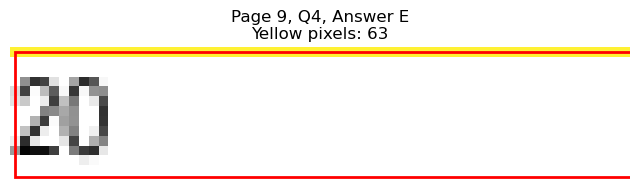


Page 9, Q4 - Selected Answer: D (based on yellow pixel count)




Page 9, Q5 - A: Detected box: x0=82.5, y0=438.5, x1=173.8, y1=451.2
Page 9, Q5, A: Yellow pixels: 0
Page 9, Q5, A: Total non-white pixels: 450
Page 9, Q5, A: Yellow percentage: 0.0%


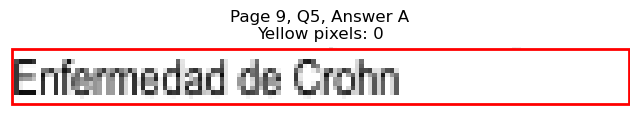

Page 9, Q5 - B: Detected box: x0=82.5, y0=451.1, x1=152.2, y1=463.8
Page 9, Q5, B: Yellow pixels: 0
Page 9, Q5, B: Total non-white pixels: 356
Page 9, Q5, B: Yellow percentage: 0.0%


Page 9, Q5 - C: Detected box: x0=82.9, y0=463.7, x1=144.1, y1=476.4
Page 9, Q5, C: Yellow pixels: 0
Page 9, Q5, C: Total non-white pixels: 328
Page 9, Q5, C: Yellow percentage: 0.0%


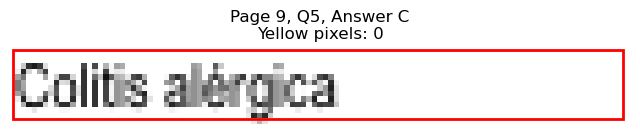

Page 9, Q5 - D: Detected box: x0=334.6, y0=438.5, x1=429.9, y1=451.2
Page 9, Q5, D: Yellow pixels: 1544
Page 9, Q5, D: Total non-white pixels: 2044
Page 9, Q5, D: Yellow percentage: 75.5%


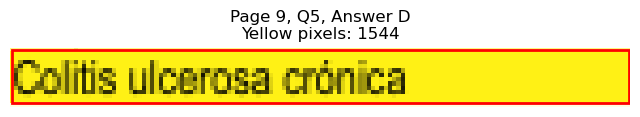

Page 9, Q5 - E: Detected box: x0=334.1, y0=451.1, x1=440.9, y1=463.8
Page 9, Q5, E: Yellow pixels: 0
Page 9, Q5, E: Total non-white pixels: 715
Page 9, Q5, E: Yellow percentage: 0.0%


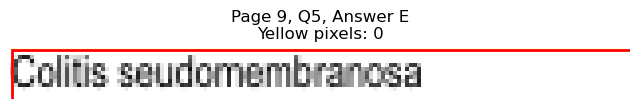


Page 9, Q5 - Selected Answer: D (based on yellow pixel count)




Page 9, Q6 - A: Detected box: x0=70.8, y0=514.3, x1=79.3, y1=526.9
Page 9, Q6, A: Yellow pixels: 0
Page 9, Q6, A: Total non-white pixels: 66
Page 9, Q6, A: Yellow percentage: 0.0%


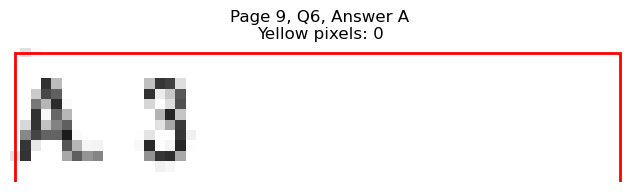

Page 9, Q6 - B: Detected box: x0=70.8, y0=526.9, x1=79.3, y1=539.5
Page 9, Q6, B: Yellow pixels: 0
Page 9, Q6, B: Total non-white pixels: 73
Page 9, Q6, B: Yellow percentage: 0.0%


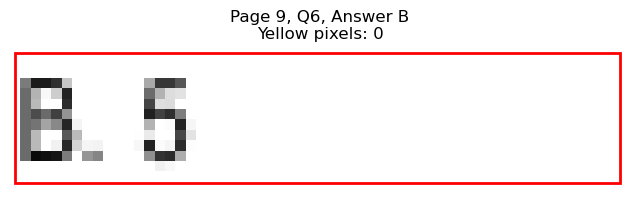

Page 9, Q6 - C: Detected box: x0=70.8, y0=539.5, x1=79.8, y1=552.1
Page 9, Q6, C: Yellow pixels: 0
Page 9, Q6, C: Total non-white pixels: 61
Page 9, Q6, C: Yellow percentage: 0.0%


Page 9, Q6 - D: Detected box: x0=322.5, y0=514.3, x1=331.5, y1=526.9
Page 9, Q6, D: Yellow pixels: 0
Page 9, Q6, D: Total non-white pixels: 132
Page 9, Q6, D: Yellow percentage: 0.0%


Page 9, Q6 - E: Detected box: x0=322.5, y0=526.9, x1=331.0, y1=539.5
Page 9, Q6, E: Yellow pixels: 737
Page 9, Q6, E: Total non-white pixels: 840
Page 9, Q6, E: Yellow percentage: 87.7%



Page 9, Q6 - Selected Answer: E (based on yellow pixel count)




Page 9, Q7 - A: Detected box: x0=82.5, y0=590.0, x1=137.2, y1=602.6
Page 9, Q7, A: Yellow pixels: 0
Page 9, Q7, A: Total non-white pixels: 281
Page 9, Q7, A: Yellow percentage: 0.0%


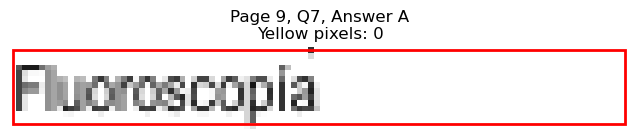

Page 9, Q7 - B: Detected box: x0=82.5, y0=602.6, x1=213.9, y1=615.2
Page 9, Q7, B: Yellow pixels: 182
Page 9, Q7, B: Total non-white pixels: 836
Page 9, Q7, B: Yellow percentage: 21.8%


Page 9, Q7 - C: Detected box: x0=82.9, y0=615.2, x1=124.1, y1=627.8
Page 9, Q7, C: Yellow pixels: 1050
Page 9, Q7, C: Total non-white pixels: 1209
Page 9, Q7, C: Yellow percentage: 86.8%


Page 9, Q7 - D: Detected box: x0=334.6, y0=590.0, x1=428.9, y1=602.6
Page 9, Q7, D: Yellow pixels: 0
Page 9, Q7, D: Total non-white pixels: 487
Page 9, Q7, D: Yellow percentage: 0.0%


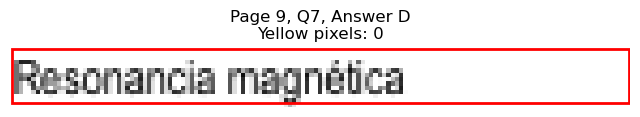

Page 9, Q7 - E: Detected box: x0=334.1, y0=602.6, x1=392.8, y1=615.2
Page 9, Q7, E: Yellow pixels: 0
Page 9, Q7, E: Total non-white pixels: 324
Page 9, Q7, E: Yellow percentage: 0.0%


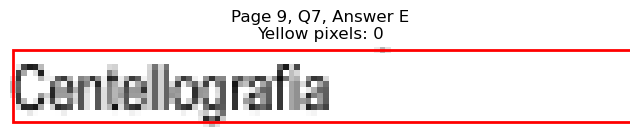


Page 9, Q7 - Selected Answer: C (based on yellow pixel count)




Page 9, Q8 - A: Detected box: x0=82.5, y0=665.7, x1=395.9, y1=678.4
Page 9, Q8, A: Yellow pixels: 364
Page 9, Q8, A: Total non-white pixels: 1862
Page 9, Q8, A: Yellow percentage: 19.5%


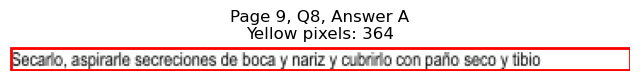

Page 9, Q8 - B: Detected box: x0=82.5, y0=678.3, x1=411.1, y1=691.0
Page 9, Q8, B: Yellow pixels: 3773
Page 9, Q8, B: Total non-white pixels: 4940
Page 9, Q8, B: Yellow percentage: 76.4%


Page 9, Q8 - C: Detected box: x0=82.9, y0=691.1, x1=417.4, y1=703.7
Page 9, Q8, C: Yellow pixels: 0
Page 9, Q8, C: Total non-white pixels: 2004
Page 9, Q8, C: Yellow percentage: 0.0%


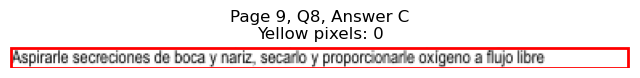

Page 9, Q8 - D: Detected box: x0=82.9, y0=703.7, x1=422.9, y1=716.3
Page 9, Q8, D: Yellow pixels: 0
Page 9, Q8, D: Total non-white pixels: 1607
Page 9, Q8, D: Yellow percentage: 0.0%


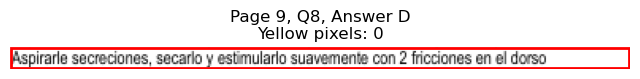

Page 9, Q8 - E: Detected box: x0=82.5, y0=716.3, x1=378.0, y1=728.9
Page 9, Q8, E: Yellow pixels: 0
Page 9, Q8, E: Total non-white pixels: 1415
Page 9, Q8, E: Yellow percentage: 0.0%


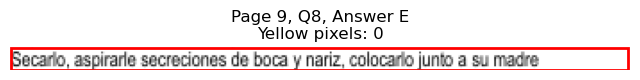


Page 9, Q8 - Selected Answer: B (based on yellow pixel count)





Page 10: Found 7 questions
Page 10, Q1 - A: Detected box: x0=82.5, y0=135.5, x1=220.4, y1=148.2
Page 10, Q1, A: Yellow pixels: 1883
Page 10, Q1, A: Total non-white pixels: 2646
Page 10, Q1, A: Yellow percentage: 71.2%


Page 10, Q1 - B: Detected box: x0=82.5, y0=148.2, x1=245.0, y1=160.9
Page 10, Q1, B: Yellow pixels: 0
Page 10, Q1, B: Total non-white pixels: 1039
Page 10, Q1, B: Yellow percentage: 0.0%


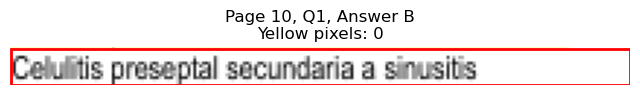

Page 10, Q1 - C: Detected box: x0=82.9, y0=160.8, x1=152.2, y1=173.5
Page 10, Q1, C: Yellow pixels: 0
Page 10, Q1, C: Total non-white pixels: 357
Page 10, Q1, C: Yellow percentage: 0.0%


Page 10, Q1 - D: Detected box: x0=334.6, y0=135.5, x1=385.7, y1=148.2
Page 10, Q1, D: Yellow pixels: 0
Page 10, Q1, D: Total non-white pixels: 274
Page 10, Q1, D: Yellow percentage: 0.0%


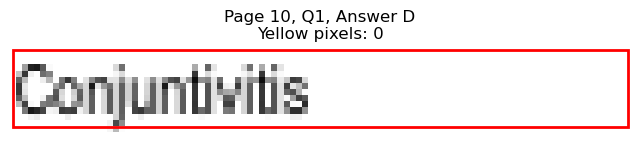

Page 10, Q1 - E: Detected box: x0=334.1, y0=148.2, x1=387.3, y1=160.9
Page 10, Q1, E: Yellow pixels: 0
Page 10, Q1, E: Total non-white pixels: 290
Page 10, Q1, E: Yellow percentage: 0.0%


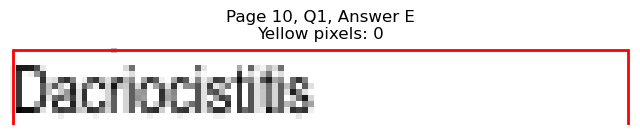


Page 10, Q1 - Selected Answer: A (based on yellow pixel count)




Page 10, Q2 - A: Detected box: x0=82.5, y0=223.9, x1=130.6, y1=236.6
Page 10, Q2, A: Yellow pixels: 1091
Page 10, Q2, A: Total non-white pixels: 1386
Page 10, Q2, A: Yellow percentage: 78.7%


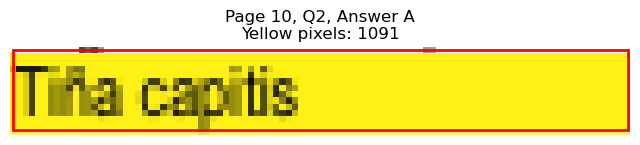

Page 10, Q2 - B: Detected box: x0=82.5, y0=236.5, x1=170.2, y1=249.2
Page 10, Q2, B: Yellow pixels: 139
Page 10, Q2, B: Total non-white pixels: 595
Page 10, Q2, B: Yellow percentage: 23.4%


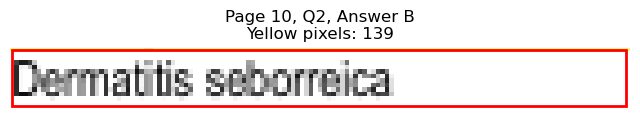

Page 10, Q2 - C: Detected box: x0=82.9, y0=249.1, x1=148.1, y1=261.8
Page 10, Q2, C: Yellow pixels: 0
Page 10, Q2, C: Total non-white pixels: 334
Page 10, Q2, C: Yellow percentage: 0.0%


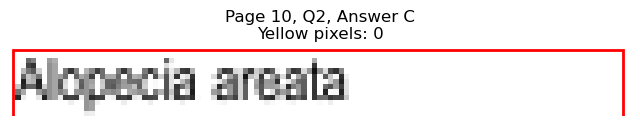

Page 10, Q2 - D: Detected box: x0=334.6, y0=223.9, x1=393.8, y1=236.6
Page 10, Q2, D: Yellow pixels: 0
Page 10, Q2, D: Total non-white pixels: 304
Page 10, Q2, D: Yellow percentage: 0.0%


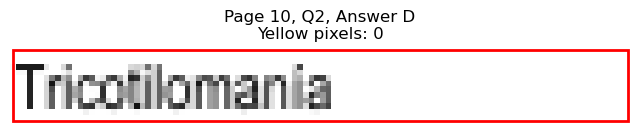

Page 10, Q2 - E: Detected box: x0=334.1, y0=236.5, x1=373.3, y1=249.2
Page 10, Q2, E: Yellow pixels: 0
Page 10, Q2, E: Total non-white pixels: 208
Page 10, Q2, E: Yellow percentage: 0.0%


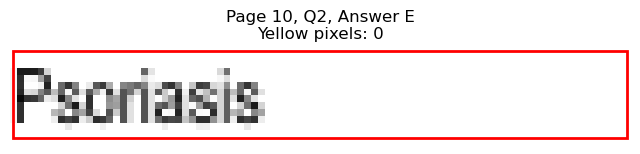


Page 10, Q2 - Selected Answer: A (based on yellow pixel count)




Page 10, Q3 - A: Detected box: x0=82.5, y0=299.7, x1=238.0, y1=312.3
Page 10, Q3, A: Yellow pixels: 0
Page 10, Q3, A: Total non-white pixels: 761
Page 10, Q3, A: Yellow percentage: 0.0%


Page 10, Q3 - B: Detected box: x0=82.5, y0=312.3, x1=266.6, y1=324.9
Page 10, Q3, B: Yellow pixels: 0
Page 10, Q3, B: Total non-white pixels: 964
Page 10, Q3, B: Yellow percentage: 0.0%


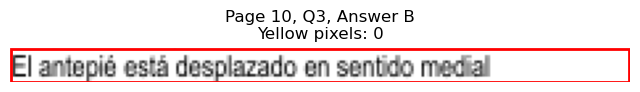

Page 10, Q3 - C: Detected box: x0=82.9, y0=324.9, x1=266.1, y1=337.5
Page 10, Q3, C: Yellow pixels: 0
Page 10, Q3, C: Total non-white pixels: 889
Page 10, Q3, C: Yellow percentage: 0.0%


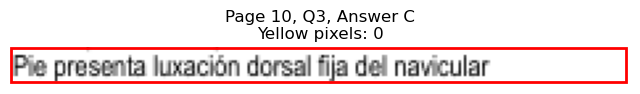

Page 10, Q3 - D: Detected box: x0=334.6, y0=299.7, x1=516.7, y1=312.3
Page 10, Q3, D: Yellow pixels: 192
Page 10, Q3, D: Total non-white pixels: 1073
Page 10, Q3, D: Yellow percentage: 17.9%


Page 10, Q3 - E: Detected box: x0=334.1, y0=312.3, x1=468.6, y1=324.9
Page 10, Q3, E: Yellow pixels: 1898
Page 10, Q3, E: Total non-white pixels: 2405
Page 10, Q3, E: Yellow percentage: 78.9%


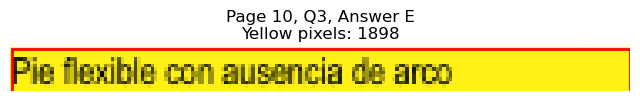


Page 10, Q3 - Selected Answer: E (based on yellow pixel count)




Page 10, Q4 - A: Detected box: x0=70.8, y0=400.6, x1=79.3, y1=413.3
Page 10, Q4, A: Yellow pixels: 0
Page 10, Q4, A: Total non-white pixels: 68
Page 10, Q4, A: Yellow percentage: 0.0%


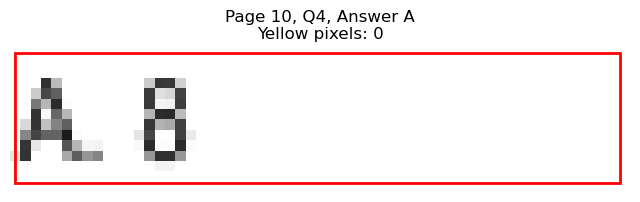

Page 10, Q4 - B: Detected box: x0=82.5, y0=413.3, x1=95.1, y1=426.0
Page 10, Q4, B: Yellow pixels: 0
Page 10, Q4, B: Total non-white pixels: 103
Page 10, Q4, B: Yellow percentage: 0.0%


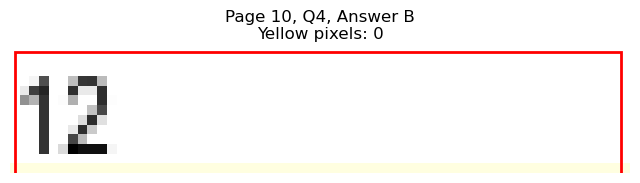

Page 10, Q4 - C: Detected box: x0=70.8, y0=425.9, x1=79.8, y1=438.6
Page 10, Q4, C: Yellow pixels: 727
Page 10, Q4, C: Total non-white pixels: 840
Page 10, Q4, C: Yellow percentage: 86.5%


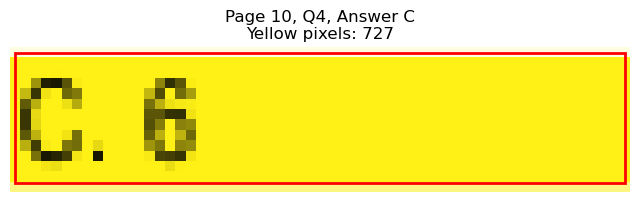

Page 10, Q4 - D: Detected box: x0=334.6, y0=400.6, x1=347.2, y1=413.3
Page 10, Q4, D: Yellow pixels: 0
Page 10, Q4, D: Total non-white pixels: 55
Page 10, Q4, D: Yellow percentage: 0.0%


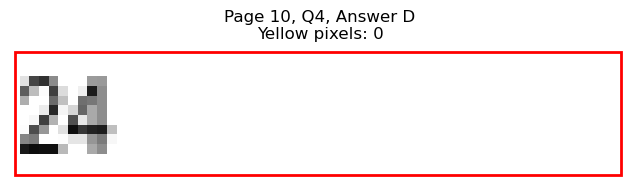

Page 10, Q4 - E: Detected box: x0=322.5, y0=413.3, x1=331.0, y1=426.0
Page 10, Q4, E: Yellow pixels: 0
Page 10, Q4, E: Total non-white pixels: 60
Page 10, Q4, E: Yellow percentage: 0.0%


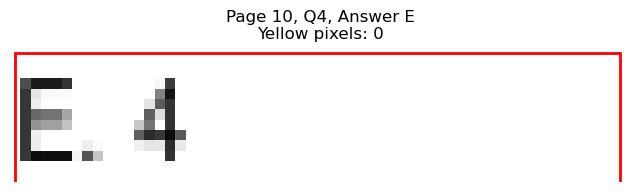


Page 10, Q4 - Selected Answer: C (based on yellow pixel count)




Page 10, Q5 - A: Detected box: x0=82.5, y0=501.7, x1=110.1, y1=514.3
Page 10, Q5, A: Yellow pixels: 79
Page 10, Q5, A: Total non-white pixels: 183
Page 10, Q5, A: Yellow percentage: 43.2%


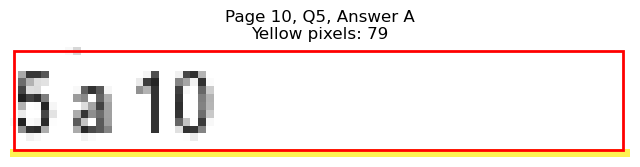

Page 10, Q5 - B: Detected box: x0=82.5, y0=514.3, x1=115.1, y1=526.9
Page 10, Q5, B: Yellow pixels: 992
Page 10, Q5, B: Total non-white pixels: 1092
Page 10, Q5, B: Yellow percentage: 90.8%


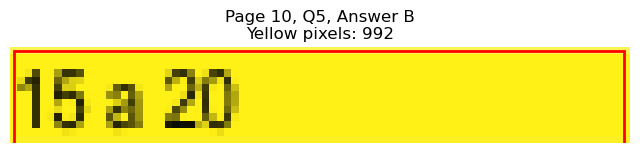

Page 10, Q5 - C: Detected box: x0=82.9, y0=526.9, x1=115.6, y1=539.5
Page 10, Q5, C: Yellow pixels: 84
Page 10, Q5, C: Total non-white pixels: 212
Page 10, Q5, C: Yellow percentage: 39.6%


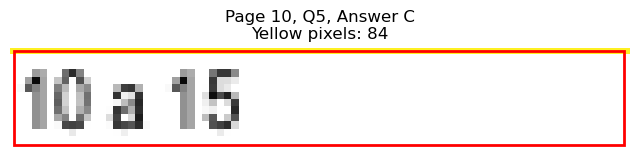

Page 10, Q5 - D: Detected box: x0=334.6, y0=501.7, x1=367.3, y1=514.3
Page 10, Q5, D: Yellow pixels: 0
Page 10, Q5, D: Total non-white pixels: 143
Page 10, Q5, D: Yellow percentage: 0.0%


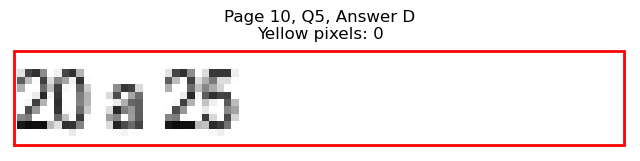

Page 10, Q5 - E: Detected box: x0=334.1, y0=514.3, x1=366.8, y1=526.9
Page 10, Q5, E: Yellow pixels: 0
Page 10, Q5, E: Total non-white pixels: 151
Page 10, Q5, E: Yellow percentage: 0.0%


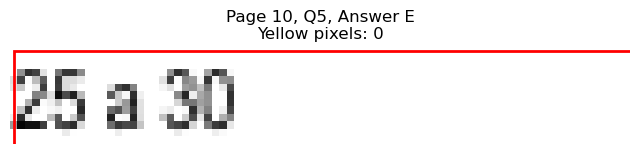


Page 10, Q5 - Selected Answer: B (based on yellow pixel count)




Page 10, Q6 - A: Detected box: x0=82.5, y0=590.0, x1=142.1, y1=602.6
Page 10, Q6, A: Yellow pixels: 0
Page 10, Q6, A: Total non-white pixels: 332
Page 10, Q6, A: Yellow percentage: 0.0%


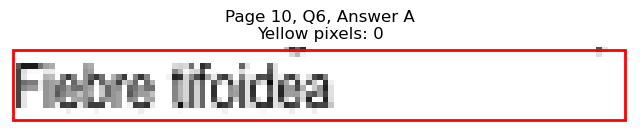

Page 10, Q6 - B: Detected box: x0=82.5, y0=602.6, x1=138.1, y1=615.2
Page 10, Q6, B: Yellow pixels: 0
Page 10, Q6, B: Total non-white pixels: 277
Page 10, Q6, B: Yellow percentage: 0.0%


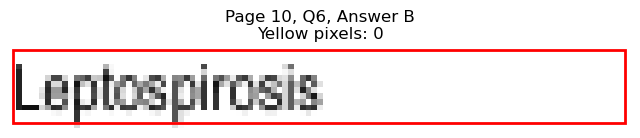

Page 10, Q6 - C: Detected box: x0=82.9, y0=615.2, x1=136.6, y1=627.8
Page 10, Q6, C: Yellow pixels: 0
Page 10, Q6, C: Total non-white pixels: 262
Page 10, Q6, C: Yellow percentage: 0.0%


Page 10, Q6 - D: Detected box: x0=334.6, y0=590.0, x1=392.3, y1=602.6
Page 10, Q6, D: Yellow pixels: 109
Page 10, Q6, D: Total non-white pixels: 405
Page 10, Q6, D: Yellow percentage: 26.9%


Page 10, Q6 - E: Detected box: x0=334.1, y0=602.6, x1=378.3, y1=615.2
Page 10, Q6, E: Yellow pixels: 1056
Page 10, Q6, E: Total non-white pixels: 1330
Page 10, Q6, E: Yellow percentage: 79.4%


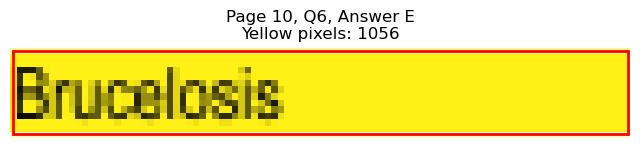


Page 10, Q6 - Selected Answer: E (based on yellow pixel count)




Page 10, Q7 - A: Detected box: x0=82.5, y0=678.3, x1=165.7, y1=691.0
Page 10, Q7, A: Yellow pixels: 0
Page 10, Q7, A: Total non-white pixels: 395
Page 10, Q7, A: Yellow percentage: 0.0%


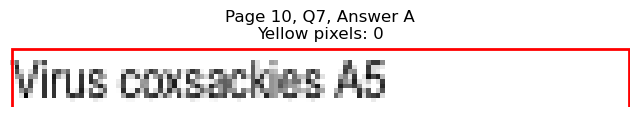

Page 10, Q7 - B: Detected box: x0=82.5, y0=691.1, x1=118.1, y1=703.7
Page 10, Q7, B: Yellow pixels: 0
Page 10, Q7, B: Total non-white pixels: 271
Page 10, Q7, B: Yellow percentage: 0.0%


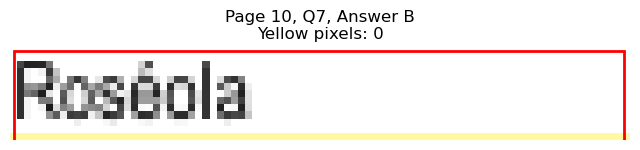

Page 10, Q7 - C: Detected box: x0=82.9, y0=703.7, x1=182.2, y1=716.3
Page 10, Q7, C: Yellow pixels: 1433
Page 10, Q7, C: Total non-white pixels: 2114
Page 10, Q7, C: Yellow percentage: 67.8%


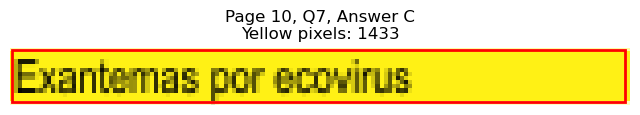

Page 10, Q7 - D: Detected box: x0=334.6, y0=678.3, x1=370.7, y1=691.0
Page 10, Q7, D: Yellow pixels: 0
Page 10, Q7, D: Total non-white pixels: 194
Page 10, Q7, D: Yellow percentage: 0.0%


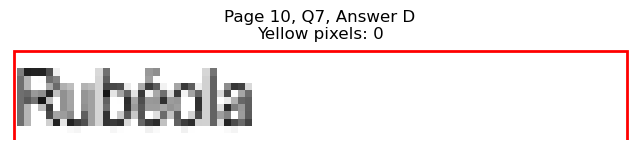

Page 10, Q7 - E: Detected box: x0=334.1, y0=691.1, x1=407.9, y1=703.7
Page 10, Q7, E: Yellow pixels: 0
Page 10, Q7, E: Total non-white pixels: 385
Page 10, Q7, E: Yellow percentage: 0.0%


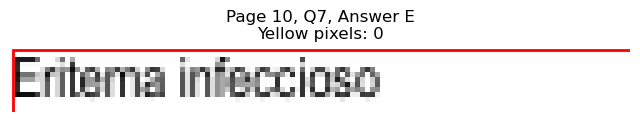


Page 10, Q7 - Selected Answer: C (based on yellow pixel count)





Page 11: Found 8 questions
Page 11, Q1 - A: Detected box: x0=82.5, y0=122.9, x1=142.1, y1=135.6
Page 11, Q1, A: Yellow pixels: 111
Page 11, Q1, A: Total non-white pixels: 431
Page 11, Q1, A: Yellow percentage: 25.8%


Page 11, Q1 - B: Detected box: x0=82.5, y0=135.5, x1=162.7, y1=148.2
Page 11, Q1, B: Yellow pixels: 1421
Page 11, Q1, B: Total non-white pixels: 1834
Page 11, Q1, B: Yellow percentage: 77.5%


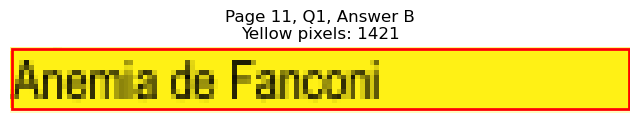

Page 11, Q1 - C: Detected box: x0=82.9, y0=148.2, x1=199.4, y1=160.9
Page 11, Q1, C: Yellow pixels: 0
Page 11, Q1, C: Total non-white pixels: 749
Page 11, Q1, C: Yellow percentage: 0.0%


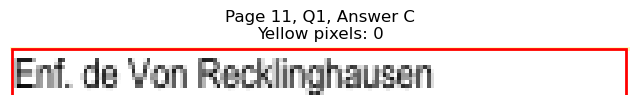

Page 11, Q1 - D: Detected box: x0=334.6, y0=122.9, x1=480.1, y1=135.6
Page 11, Q1, D: Yellow pixels: 0
Page 11, Q1, D: Total non-white pixels: 723
Page 11, Q1, D: Yellow percentage: 0.0%


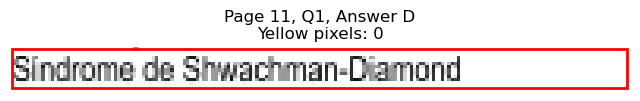

Page 11, Q1 - E: Detected box: x0=334.1, y0=135.5, x1=432.9, y1=148.2
Page 11, Q1, E: Yellow pixels: 0
Page 11, Q1, E: Total non-white pixels: 533
Page 11, Q1, E: Yellow percentage: 0.0%


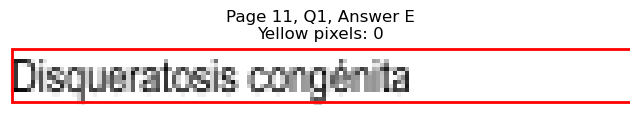


Page 11, Q1 - Selected Answer: B (based on yellow pixel count)




Page 11, Q2 - A: Detected box: x0=82.5, y0=198.6, x1=138.6, y1=211.3
Page 11, Q2, A: Yellow pixels: 0
Page 11, Q2, A: Total non-white pixels: 280
Page 11, Q2, A: Yellow percentage: 0.0%


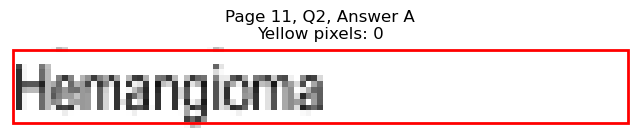

Page 11, Q2 - B: Detected box: x0=82.5, y0=211.3, x1=195.4, y1=224.0
Page 11, Q2, B: Yellow pixels: 1650
Page 11, Q2, B: Total non-white pixels: 2132
Page 11, Q2, B: Yellow percentage: 77.4%


Page 11, Q2 - C: Detected box: x0=82.9, y0=223.9, x1=196.8, y1=236.6
Page 11, Q2, C: Yellow pixels: 161
Page 11, Q2, C: Total non-white pixels: 753
Page 11, Q2, C: Yellow percentage: 21.4%


Page 11, Q2 - D: Detected box: x0=334.6, y0=198.6, x1=505.2, y1=211.3
Page 11, Q2, D: Yellow pixels: 0
Page 11, Q2, D: Total non-white pixels: 905
Page 11, Q2, D: Yellow percentage: 0.0%


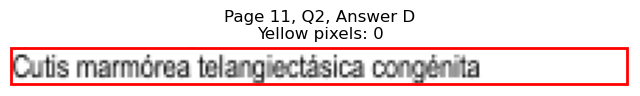

Page 11, Q2 - E: Detected box: x0=334.1, y0=211.3, x1=401.8, y1=224.0
Page 11, Q2, E: Yellow pixels: 0
Page 11, Q2, E: Total non-white pixels: 355
Page 11, Q2, E: Yellow percentage: 0.0%


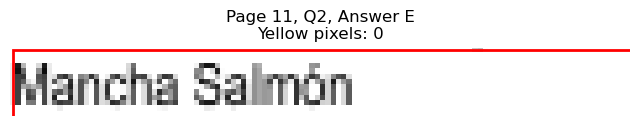


Page 11, Q2 - Selected Answer: B (based on yellow pixel count)




Page 11, Q3 - A: Detected box: x0=82.5, y0=274.5, x1=227.0, y1=287.1
Page 11, Q3, A: Yellow pixels: 0
Page 11, Q3, A: Total non-white pixels: 738
Page 11, Q3, A: Yellow percentage: 0.0%


Page 11, Q3 - B: Detected box: x0=82.5, y0=287.1, x1=170.8, y1=299.7
Page 11, Q3, B: Yellow pixels: 0
Page 11, Q3, B: Total non-white pixels: 463
Page 11, Q3, B: Yellow percentage: 0.0%


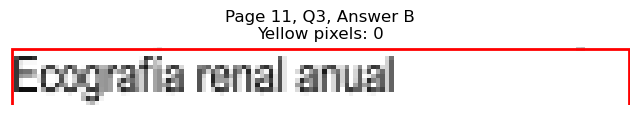

Page 11, Q3 - C: Detected box: x0=82.9, y0=299.7, x1=279.0, y1=312.3
Page 11, Q3, C: Yellow pixels: 241
Page 11, Q3, C: Total non-white pixels: 1204
Page 11, Q3, C: Yellow percentage: 20.0%


Page 11, Q3 - D: Detected box: x0=323.9, y0=274.5, x1=525.6, y1=287.1
Page 11, Q3, D: Yellow pixels: 203
Page 11, Q3, D: Total non-white pixels: 1235
Page 11, Q3, D: Yellow percentage: 16.4%


Page 11, Q3 - E: Detected box: x0=323.5, y0=287.1, x1=527.0, y1=299.7
Page 11, Q3, E: Yellow pixels: 1851
Page 11, Q3, E: Total non-white pixels: 2639
Page 11, Q3, E: Yellow percentage: 70.1%


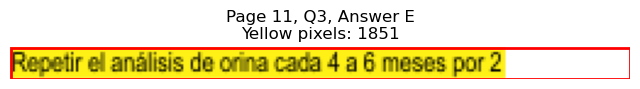


Page 11, Q3 - Selected Answer: E (based on yellow pixel count)




Page 11, Q4 - A: Detected box: x0=82.5, y0=362.8, x1=183.7, y1=375.5
Page 11, Q4, A: Yellow pixels: 1589
Page 11, Q4, A: Total non-white pixels: 2128
Page 11, Q4, A: Yellow percentage: 74.7%


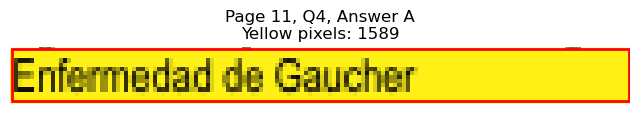

Page 11, Q4 - B: Detected box: x0=82.5, y0=375.4, x1=175.7, y1=388.1
Page 11, Q4, B: Yellow pixels: 144
Page 11, Q4, B: Total non-white pixels: 607
Page 11, Q4, B: Yellow percentage: 23.7%


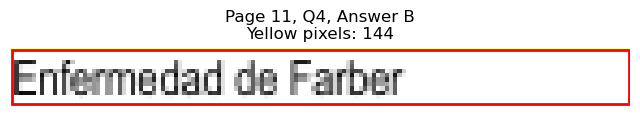

Page 11, Q4 - C: Detected box: x0=82.9, y0=388.0, x1=178.8, y1=400.7
Page 11, Q4, C: Yellow pixels: 0
Page 11, Q4, C: Total non-white pixels: 494
Page 11, Q4, C: Yellow percentage: 0.0%


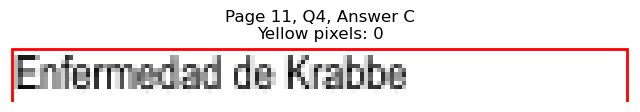

Page 11, Q4 - D: Detected box: x0=334.6, y0=362.8, x1=424.4, y1=375.5
Page 11, Q4, D: Yellow pixels: 0
Page 11, Q4, D: Total non-white pixels: 440
Page 11, Q4, D: Yellow percentage: 0.0%


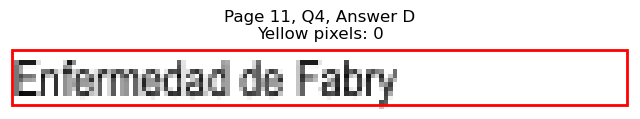

Page 11, Q4 - E: Detected box: x0=334.1, y0=375.4, x1=446.5, y1=388.1
Page 11, Q4, E: Yellow pixels: 0
Page 11, Q4, E: Total non-white pixels: 592
Page 11, Q4, E: Yellow percentage: 0.0%


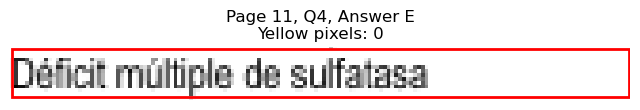


Page 11, Q4 - Selected Answer: A (based on yellow pixel count)




Page 11, Q5 - A: Detected box: x0=82.5, y0=451.1, x1=153.1, y1=463.8
Page 11, Q5, A: Yellow pixels: 0
Page 11, Q5, A: Total non-white pixels: 350
Page 11, Q5, A: Yellow percentage: 0.0%


Page 11, Q5 - B: Detected box: x0=82.5, y0=463.7, x1=177.3, y1=476.4
Page 11, Q5, B: Yellow pixels: 0
Page 11, Q5, B: Total non-white pixels: 463
Page 11, Q5, B: Yellow percentage: 0.0%


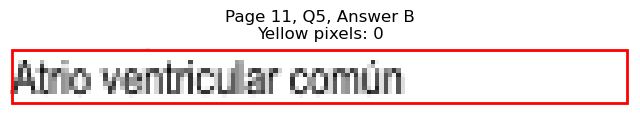

Page 11, Q5 - C: Detected box: x0=82.9, y0=476.3, x1=198.3, y1=489.0
Page 11, Q5, C: Yellow pixels: 0
Page 11, Q5, C: Total non-white pixels: 589
Page 11, Q5, C: Yellow percentage: 0.0%


Page 11, Q5 - D: Detected box: x0=334.6, y0=451.1, x1=411.9, y1=463.8
Page 11, Q5, D: Yellow pixels: 1359
Page 11, Q5, D: Total non-white pixels: 1664
Page 11, Q5, D: Yellow percentage: 81.7%


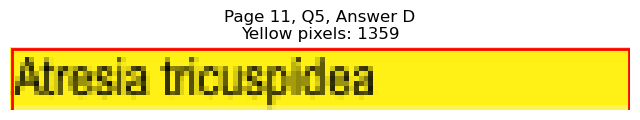

Page 11, Q5 - E: Detected box: x0=334.1, y0=463.7, x1=466.5, y1=476.4
Page 11, Q5, E: Yellow pixels: 0
Page 11, Q5, E: Total non-white pixels: 651
Page 11, Q5, E: Yellow percentage: 0.0%


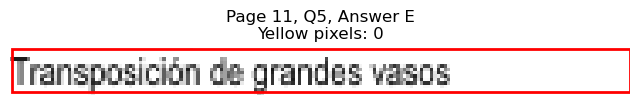


Page 11, Q5 - Selected Answer: D (based on yellow pixel count)




Page 11, Q6 - A: Detected box: x0=82.5, y0=526.9, x1=260.1, y1=539.5
Page 11, Q6, A: Yellow pixels: 0
Page 11, Q6, A: Total non-white pixels: 843
Page 11, Q6, A: Yellow percentage: 0.0%


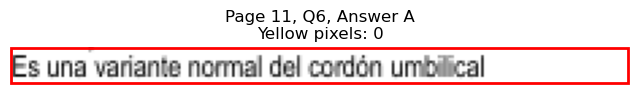

Page 11, Q6 - B: Detected box: x0=82.5, y0=539.5, x1=276.0, y1=552.1
Page 11, Q6, B: Yellow pixels: 0
Page 11, Q6, B: Total non-white pixels: 893
Page 11, Q6, B: Yellow percentage: 0.0%


Page 11, Q6 - C: Detected box: x0=82.9, y0=552.2, x1=253.5, y1=564.8
Page 11, Q6, C: Yellow pixels: 0
Page 11, Q6, C: Total non-white pixels: 877
Page 11, Q6, C: Yellow percentage: 0.0%


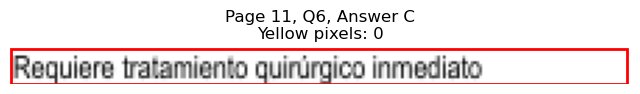

Page 11, Q6 - D: Detected box: x0=482.9, y0=526.9, x1=527.0, y1=539.5
Page 11, Q6, D: Yellow pixels: 0
Page 11, Q6, D: Total non-white pixels: 218
Page 11, Q6, D: Yellow percentage: 0.0%


Page 11, Q6 - E: Detected box: x0=323.5, y0=552.2, x1=500.0, y1=564.8
Page 11, Q6, E: Yellow pixels: 1958
Page 11, Q6, E: Total non-white pixels: 2639
Page 11, Q6, E: Yellow percentage: 74.2%


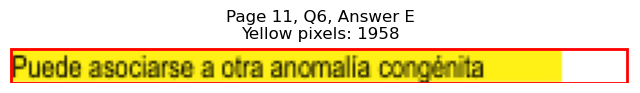


Page 11, Q6 - Selected Answer: E (based on yellow pixel count)




Page 11, Q7 - A: Detected box: x0=82.5, y0=602.6, x1=123.1, y1=615.2
Page 11, Q7, A: Yellow pixels: 92
Page 11, Q7, A: Total non-white pixels: 303
Page 11, Q7, A: Yellow percentage: 30.4%


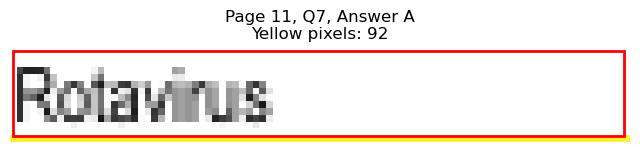

Page 11, Q7 - B: Detected box: x0=82.5, y0=615.2, x1=145.1, y1=627.8
Page 11, Q7, B: Yellow pixels: 1242
Page 11, Q7, B: Total non-white pixels: 1482
Page 11, Q7, B: Yellow percentage: 83.8%


Page 11, Q7 - C: Detected box: x0=82.9, y0=627.9, x1=151.7, y1=640.6
Page 11, Q7, C: Yellow pixels: 120
Page 11, Q7, C: Total non-white pixels: 479
Page 11, Q7, C: Yellow percentage: 25.1%


Page 11, Q7 - D: Detected box: x0=334.6, y0=602.6, x1=418.4, y1=615.2
Page 11, Q7, D: Yellow pixels: 0
Page 11, Q7, D: Total non-white pixels: 458
Page 11, Q7, D: Yellow percentage: 0.0%


Page 11, Q7 - E: Detected box: x0=334.1, y0=615.2, x1=420.9, y1=627.8
Page 11, Q7, E: Yellow pixels: 0
Page 11, Q7, E: Total non-white pixels: 448
Page 11, Q7, E: Yellow percentage: 0.0%


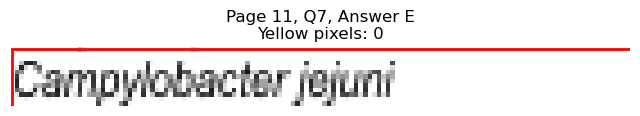


Page 11, Q7 - Selected Answer: B (based on yellow pixel count)




Page 11, Q8 - A: Detected box: x0=82.5, y0=665.7, x1=105.0, y1=678.4
Page 11, Q8, A: Yellow pixels: 826
Page 11, Q8, A: Total non-white pixels: 1036
Page 11, Q8, A: Yellow percentage: 79.7%


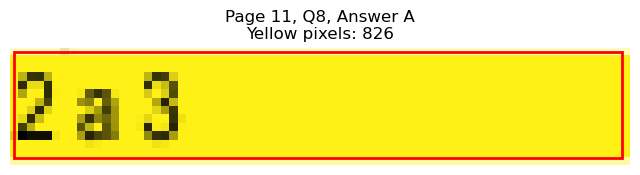

Page 11, Q8 - B: Detected box: x0=82.5, y0=678.3, x1=105.0, y1=691.0
Page 11, Q8, B: Yellow pixels: 0
Page 11, Q8, B: Total non-white pixels: 161
Page 11, Q8, B: Yellow percentage: 0.0%


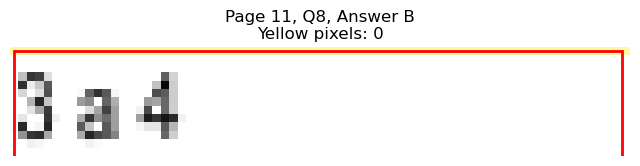

Page 11, Q8 - C: Detected box: x0=82.9, y0=691.1, x1=105.5, y1=703.7
Page 11, Q8, C: Yellow pixels: 0
Page 11, Q8, C: Total non-white pixels: 89
Page 11, Q8, C: Yellow percentage: 0.0%


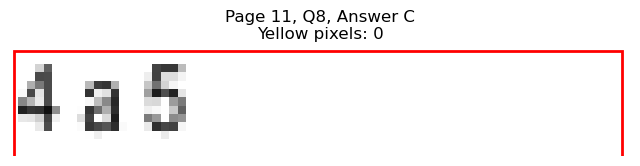

Page 11, Q8 - D: Detected box: x0=334.6, y0=665.7, x1=357.2, y1=678.4
Page 11, Q8, D: Yellow pixels: 0
Page 11, Q8, D: Total non-white pixels: 96
Page 11, Q8, D: Yellow percentage: 0.0%


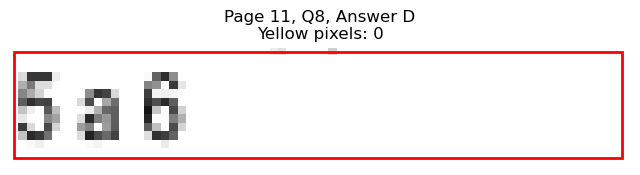

Page 11, Q8 - E: Detected box: x0=334.1, y0=678.3, x1=356.7, y1=691.0
Page 11, Q8, E: Yellow pixels: 0
Page 11, Q8, E: Total non-white pixels: 87
Page 11, Q8, E: Yellow percentage: 0.0%


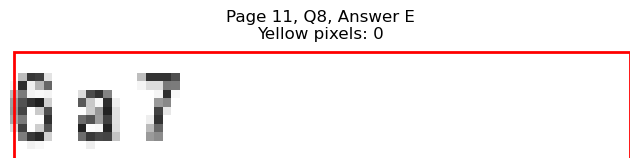


Page 11, Q8 - Selected Answer: A (based on yellow pixel count)





Page 12: Found 9 questions
Page 12, Q1 - A: Detected box: x0=82.5, y0=122.9, x1=142.1, y1=135.6
Page 12, Q1, A: Yellow pixels: 1220
Page 12, Q1, A: Total non-white pixels: 1554
Page 12, Q1, A: Yellow percentage: 78.5%


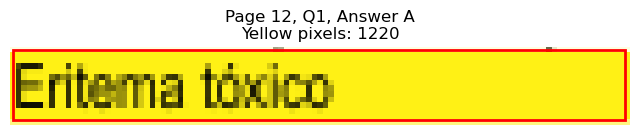

Page 12, Q1 - B: Detected box: x0=82.5, y0=135.5, x1=172.2, y1=148.2
Page 12, Q1, B: Yellow pixels: 141
Page 12, Q1, B: Total non-white pixels: 606
Page 12, Q1, B: Yellow percentage: 23.3%


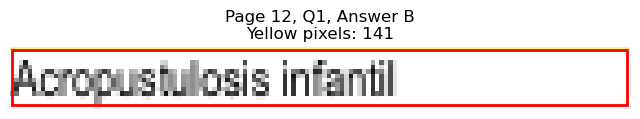

Page 12, Q1 - C: Detected box: x0=82.9, y0=148.2, x1=204.3, y1=160.9
Page 12, Q1, C: Yellow pixels: 0
Page 12, Q1, C: Total non-white pixels: 639
Page 12, Q1, C: Yellow percentage: 0.0%


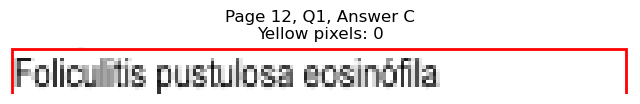

Page 12, Q1 - D: Detected box: x0=334.6, y0=122.9, x1=418.9, y1=135.6
Page 12, Q1, D: Yellow pixels: 0
Page 12, Q1, D: Total non-white pixels: 464
Page 12, Q1, D: Yellow percentage: 0.0%


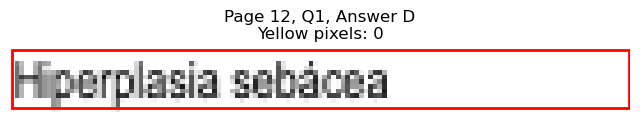

Page 12, Q1 - E: Detected box: x0=334.1, y0=135.5, x1=359.7, y1=148.2
Page 12, Q1, E: Yellow pixels: 0
Page 12, Q1, E: Total non-white pixels: 154
Page 12, Q1, E: Yellow percentage: 0.0%


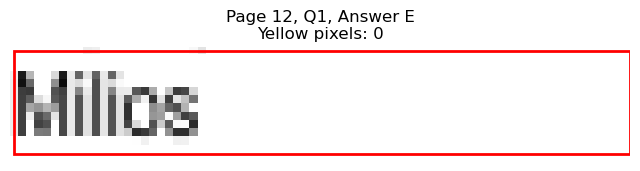


Page 12, Q1 - Selected Answer: A (based on yellow pixel count)




Page 12, Q2 - A: Detected box: x0=70.8, y0=186.0, x1=79.3, y1=198.7
Page 12, Q2, A: Yellow pixels: 0
Page 12, Q2, A: Total non-white pixels: 128
Page 12, Q2, A: Yellow percentage: 0.0%


Page 12, Q2 - B: Detected box: x0=70.8, y0=198.6, x1=79.3, y1=211.3
Page 12, Q2, B: Yellow pixels: 662
Page 12, Q2, B: Total non-white pixels: 840
Page 12, Q2, B: Yellow percentage: 78.8%


Page 12, Q2 - C: Detected box: x0=70.8, y0=211.3, x1=79.8, y1=224.0
Page 12, Q2, C: Yellow pixels: 0
Page 12, Q2, C: Total non-white pixels: 126
Page 12, Q2, C: Yellow percentage: 0.0%


Page 12, Q2 - D: Detected box: x0=322.5, y0=186.0, x1=331.5, y1=198.7
Page 12, Q2, D: Yellow pixels: 0
Page 12, Q2, D: Total non-white pixels: 73
Page 12, Q2, D: Yellow percentage: 0.0%


Page 12, Q2 - E: Detected box: x0=322.5, y0=198.6, x1=331.0, y1=211.3
Page 12, Q2, E: Yellow pixels: 0
Page 12, Q2, E: Total non-white pixels: 63
Page 12, Q2, E: Yellow percentage: 0.0%


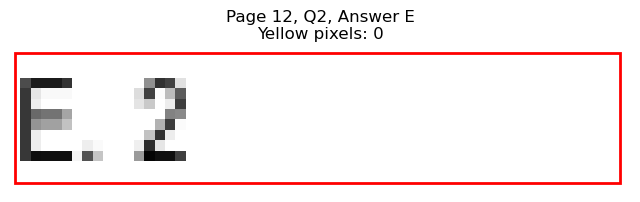


Page 12, Q2 - Selected Answer: B (based on yellow pixel count)




Page 12, Q3 - A: Detected box: x0=82.5, y0=249.1, x1=128.7, y1=261.8
Page 12, Q3, A: Yellow pixels: 0
Page 12, Q3, A: Total non-white pixels: 228
Page 12, Q3, A: Yellow percentage: 0.0%


Page 12, Q3 - B: Detected box: x0=82.5, y0=261.7, x1=154.2, y1=274.4
Page 12, Q3, B: Yellow pixels: 0
Page 12, Q3, B: Total non-white pixels: 372
Page 12, Q3, B: Yellow percentage: 0.0%


Page 12, Q3 - C: Detected box: x0=82.9, y0=274.5, x1=180.7, y1=287.1
Page 12, Q3, C: Yellow pixels: 1531
Page 12, Q3, C: Total non-white pixels: 2086
Page 12, Q3, C: Yellow percentage: 73.4%


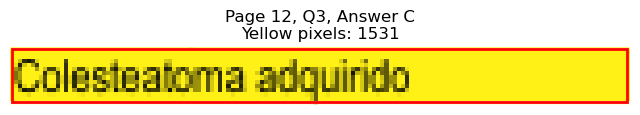

Page 12, Q3 - D: Detected box: x0=334.6, y0=249.1, x1=454.5, y1=261.8
Page 12, Q3, D: Yellow pixels: 0
Page 12, Q3, D: Total non-white pixels: 597
Page 12, Q3, D: Yellow percentage: 0.0%


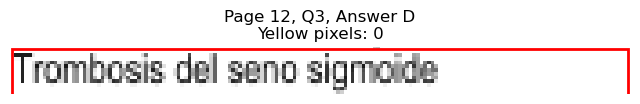

Page 12, Q3 - E: Detected box: x0=334.1, y0=261.7, x1=408.4, y1=274.4
Page 12, Q3, E: Yellow pixels: 0
Page 12, Q3, E: Total non-white pixels: 386
Page 12, Q3, E: Yellow percentage: 0.0%



Page 12, Q3 - Selected Answer: C (based on yellow pixel count)




Page 12, Q4 - A: Detected box: x0=82.5, y0=312.3, x1=142.1, y1=324.9
Page 12, Q4, A: Yellow pixels: 0
Page 12, Q4, A: Total non-white pixels: 313
Page 12, Q4, A: Yellow percentage: 0.0%


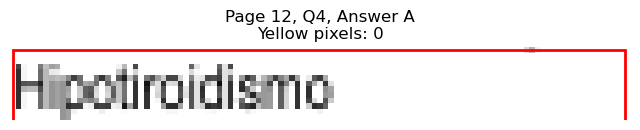

Page 12, Q4 - B: Detected box: x0=82.5, y0=324.9, x1=141.6, y1=337.5
Page 12, Q4, B: Yellow pixels: 110
Page 12, Q4, B: Total non-white pixels: 427
Page 12, Q4, B: Yellow percentage: 25.8%


Page 12, Q4 - C: Detected box: x0=82.9, y0=337.5, x1=174.7, y1=350.1
Page 12, Q4, C: Yellow pixels: 1490
Page 12, Q4, C: Total non-white pixels: 2002
Page 12, Q4, C: Yellow percentage: 74.4%


Page 12, Q4 - D: Detected box: x0=334.6, y0=312.3, x1=424.4, y1=324.9
Page 12, Q4, D: Yellow pixels: 0
Page 12, Q4, D: Total non-white pixels: 447
Page 12, Q4, D: Yellow percentage: 0.0%


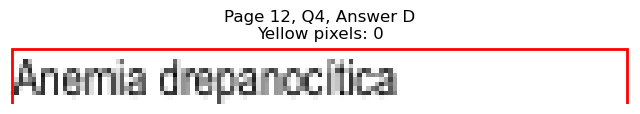

Page 12, Q4 - E: Detected box: x0=334.1, y0=324.9, x1=391.9, y1=337.5
Page 12, Q4, E: Yellow pixels: 0
Page 12, Q4, E: Total non-white pixels: 308
Page 12, Q4, E: Yellow percentage: 0.0%


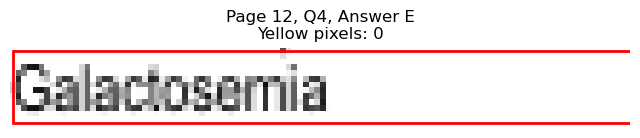


Page 12, Q4 - Selected Answer: C (based on yellow pixel count)




Page 12, Q5 - A: Detected box: x0=82.5, y0=375.4, x1=105.0, y1=388.1
Page 12, Q5, A: Yellow pixels: 893
Page 12, Q5, A: Total non-white pixels: 1036
Page 12, Q5, A: Yellow percentage: 86.2%


Page 12, Q5 - B: Detected box: x0=82.5, y0=388.0, x1=112.6, y1=400.7
Page 12, Q5, B: Yellow pixels: 0
Page 12, Q5, B: Total non-white pixels: 199
Page 12, Q5, B: Yellow percentage: 0.0%


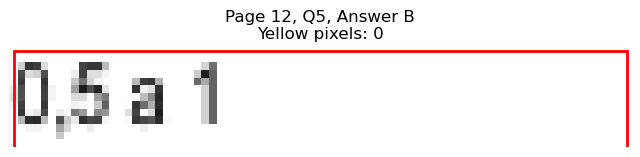

Page 12, Q5 - C: Detected box: x0=82.9, y0=400.6, x1=105.5, y1=413.3
Page 12, Q5, C: Yellow pixels: 0
Page 12, Q5, C: Total non-white pixels: 81
Page 12, Q5, C: Yellow percentage: 0.0%


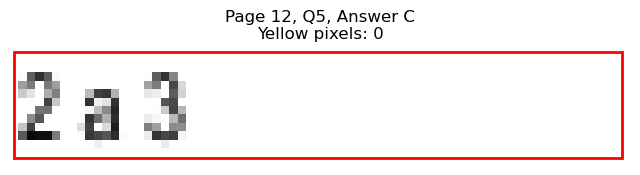

Page 12, Q5 - D: Detected box: x0=334.6, y0=375.4, x1=362.2, y1=388.1
Page 12, Q5, D: Yellow pixels: 0
Page 12, Q5, D: Total non-white pixels: 106
Page 12, Q5, D: Yellow percentage: 0.0%


Page 12, Q5 - E: Detected box: x0=334.1, y0=388.0, x1=366.8, y1=400.7
Page 12, Q5, E: Yellow pixels: 0
Page 12, Q5, E: Total non-white pixels: 128
Page 12, Q5, E: Yellow percentage: 0.0%



Page 12, Q5 - Selected Answer: A (based on yellow pixel count)




Page 12, Q6 - A: Detected box: x0=82.5, y0=451.1, x1=269.6, y1=463.8
Page 12, Q6, A: Yellow pixels: 0
Page 12, Q6, A: Total non-white pixels: 918
Page 12, Q6, A: Yellow percentage: 0.0%


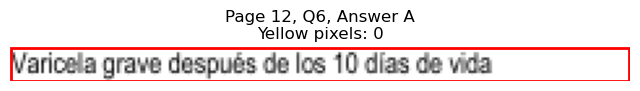

Page 12, Q6 - B: Detected box: x0=82.5, y0=463.7, x1=178.2, y1=476.4
Page 12, Q6, B: Yellow pixels: 0
Page 12, Q6, B: Total non-white pixels: 509
Page 12, Q6, B: Yellow percentage: 0.0%


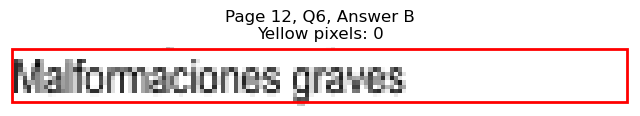

Page 12, Q6 - C: Detected box: x0=82.9, y0=476.3, x1=172.7, y1=489.0
Page 12, Q6, C: Yellow pixels: 0
Page 12, Q6, C: Total non-white pixels: 463
Page 12, Q6, C: Yellow percentage: 0.0%


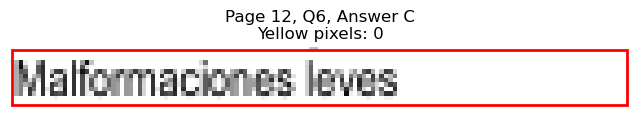

Page 12, Q6 - D: Detected box: x0=334.6, y0=451.1, x1=393.3, y1=463.8
Page 12, Q6, D: Yellow pixels: 0
Page 12, Q6, D: Total non-white pixels: 396
Page 12, Q6, D: Yellow percentage: 0.0%


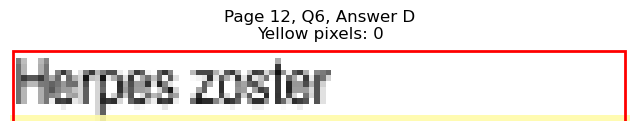

Page 12, Q6 - E: Detected box: x0=334.1, y0=463.7, x1=513.7, y1=476.4
Page 12, Q6, E: Yellow pixels: 1617
Page 12, Q6, E: Total non-white pixels: 2688
Page 12, Q6, E: Yellow percentage: 60.2%



Page 12, Q6 - Selected Answer: E (based on yellow pixel count)




Page 12, Q7 - A: Detected box: x0=82.5, y0=526.9, x1=149.2, y1=539.5
Page 12, Q7, A: Yellow pixels: 1253
Page 12, Q7, A: Total non-white pixels: 1652
Page 12, Q7, A: Yellow percentage: 75.8%


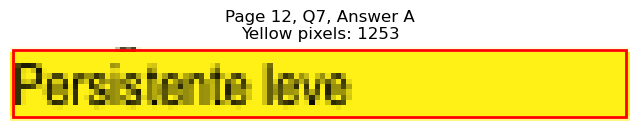

Page 12, Q7 - B: Detected box: x0=82.5, y0=539.5, x1=173.2, y1=552.1
Page 12, Q7, B: Yellow pixels: 142
Page 12, Q7, B: Total non-white pixels: 621
Page 12, Q7, B: Yellow percentage: 22.9%


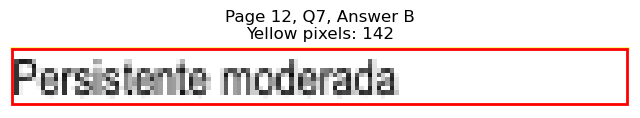

Page 12, Q7 - C: Detected box: x0=82.9, y0=552.2, x1=155.7, y1=564.8
Page 12, Q7, C: Yellow pixels: 0
Page 12, Q7, C: Total non-white pixels: 365
Page 12, Q7, C: Yellow percentage: 0.0%


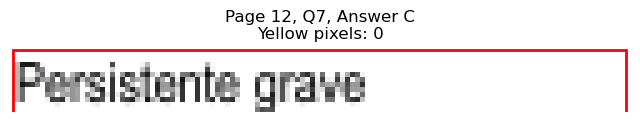

Page 12, Q7 - D: Detected box: x0=334.6, y0=526.9, x1=441.4, y1=539.5
Page 12, Q7, D: Yellow pixels: 0
Page 12, Q7, D: Total non-white pixels: 561
Page 12, Q7, D: Yellow percentage: 0.0%


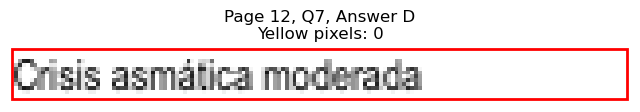

Page 12, Q7 - E: Detected box: x0=334.1, y0=539.5, x1=384.3, y1=552.1
Page 12, Q7, E: Yellow pixels: 0
Page 12, Q7, E: Total non-white pixels: 265
Page 12, Q7, E: Yellow percentage: 0.0%


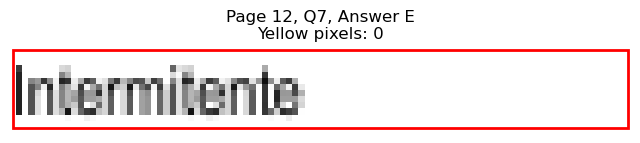


Page 12, Q7 - Selected Answer: A (based on yellow pixel count)




Page 12, Q8 - A: Detected box: x0=82.5, y0=602.6, x1=192.3, y1=615.2
Page 12, Q8, A: Yellow pixels: 0
Page 12, Q8, A: Total non-white pixels: 549
Page 12, Q8, A: Yellow percentage: 0.0%


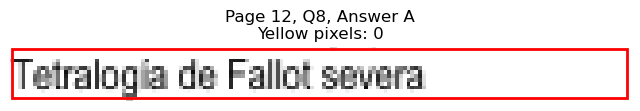

Page 12, Q8 - B: Detected box: x0=82.5, y0=615.2, x1=180.3, y1=627.8
Page 12, Q8, B: Yellow pixels: 0
Page 12, Q8, B: Total non-white pixels: 465
Page 12, Q8, B: Yellow percentage: 0.0%


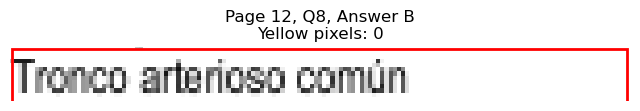

Page 12, Q8 - C: Detected box: x0=82.9, y0=627.9, x1=169.7, y1=640.6
Page 12, Q8, C: Yellow pixels: 0
Page 12, Q8, C: Total non-white pixels: 443
Page 12, Q8, C: Yellow percentage: 0.0%


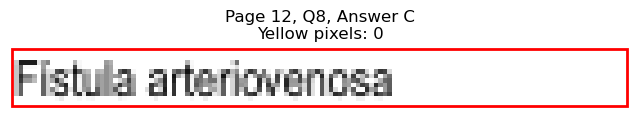

Page 12, Q8 - D: Detected box: x0=334.6, y0=602.6, x1=467.0, y1=615.2
Page 12, Q8, D: Yellow pixels: 1883
Page 12, Q8, D: Total non-white pixels: 2576
Page 12, Q8, D: Yellow percentage: 73.1%


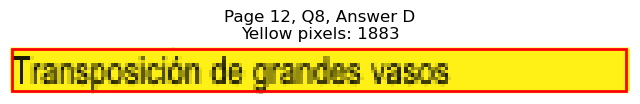

Page 12, Q8 - E: Detected box: x0=334.1, y0=615.2, x1=411.4, y1=627.8
Page 12, Q8, E: Yellow pixels: 0
Page 12, Q8, E: Total non-white pixels: 528
Page 12, Q8, E: Yellow percentage: 0.0%


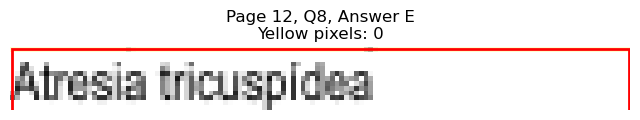


Page 12, Q8 - Selected Answer: D (based on yellow pixel count)




Page 12, Q9 - A: Detected box: x0=82.5, y0=678.3, x1=133.1, y1=691.0
Page 12, Q9, A: Yellow pixels: 0
Page 12, Q9, A: Total non-white pixels: 220
Page 12, Q9, A: Yellow percentage: 0.0%


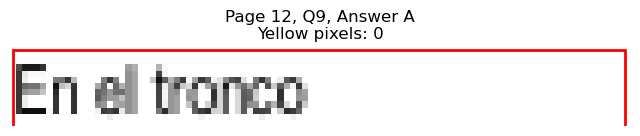

Page 12, Q9 - B: Detected box: x0=82.5, y0=691.1, x1=154.2, y1=703.7
Page 12, Q9, B: Yellow pixels: 0
Page 12, Q9, B: Total non-white pixels: 343
Page 12, Q9, B: Yellow percentage: 0.0%


Page 12, Q9 - C: Detected box: x0=82.9, y0=703.7, x1=185.3, y1=716.3
Page 12, Q9, C: Yellow pixels: 0
Page 12, Q9, C: Total non-white pixels: 524
Page 12, Q9, C: Yellow percentage: 0.0%


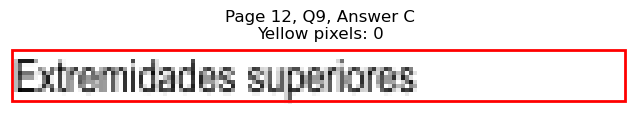

Page 12, Q9 - D: Detected box: x0=334.6, y0=678.3, x1=402.3, y1=691.0
Page 12, Q9, D: Yellow pixels: 0
Page 12, Q9, D: Total non-white pixels: 347
Page 12, Q9, D: Yellow percentage: 0.0%


Page 12, Q9 - E: Detected box: x0=334.1, y0=691.1, x1=431.5, y1=703.7
Page 12, Q9, E: Yellow pixels: 1548
Page 12, Q9, E: Total non-white pixels: 1924
Page 12, Q9, E: Yellow percentage: 80.5%


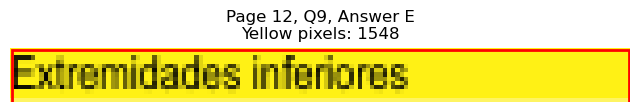


Page 12, Q9 - Selected Answer: E (based on yellow pixel count)





Page 13: Found 1 questions
Page 13, Q1 - A: Detected box: x0=82.5, y0=135.5, x1=156.7, y1=148.2
Page 13, Q1, A: Yellow pixels: 0
Page 13, Q1, A: Total non-white pixels: 346
Page 13, Q1, A: Yellow percentage: 0.0%


Page 13, Q1 - B: Detected box: x0=82.5, y0=148.2, x1=174.7, y1=160.9
Page 13, Q1, B: Yellow pixels: 0
Page 13, Q1, B: Total non-white pixels: 440
Page 13, Q1, B: Yellow percentage: 0.0%


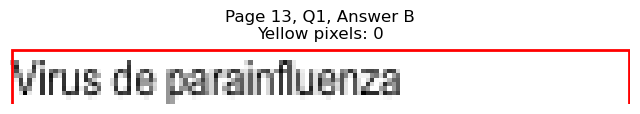

Page 13, Q1 - C: Detected box: x0=82.9, y0=160.8, x1=177.3, y1=173.5
Page 13, Q1, C: Yellow pixels: 0
Page 13, Q1, C: Total non-white pixels: 485
Page 13, Q1, C: Yellow percentage: 0.0%


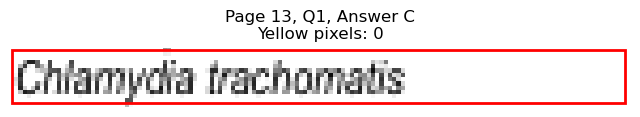

Page 13, Q1 - D: Detected box: x0=334.6, y0=135.5, x1=416.3, y1=148.2
Page 13, Q1, D: Yellow pixels: 0
Page 13, Q1, D: Total non-white pixels: 439
Page 13, Q1, D: Yellow percentage: 0.0%


Page 13, Q1 - E: Detected box: x0=334.1, y0=148.2, x1=439.5, y1=160.9
Page 13, Q1, E: Yellow pixels: 1597
Page 13, Q1, E: Total non-white pixels: 2028
Page 13, Q1, E: Yellow percentage: 78.7%


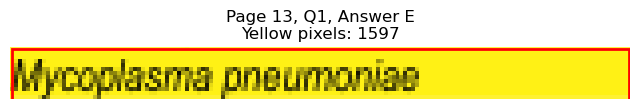


Page 13, Q1 - Selected Answer: E (based on yellow pixel count)






In [6]:
questions_df = extract_questions(pdf_path = pdf_file)
answers_df = extract_answers(pdf_path = pdf_file)
correct_answers_df = extract_correct_answers(pdf_path = pdf_file)

In [7]:
questions_df

question
0   Si un niño ha ingerido hidrocarburos en forma ...
1   Niño de 5 años, traído a la emergencia por pre...
2   ¿Cuál es la condición, para que un paciente de...
3   Paciente de 3 años, presenta desde hace 10 día...
4   Lactante de 1 mes, presenta placas rojizas, co...
..                                                ...
95  Gestante a término, quien 15 días antes del pa...
96  Niño de 8 años, presenta varios episodios de t...
97  Neonato de 6 días de edad, presenta cianosis y...
98  Durante el crecimiento en estatura en los niño...
99  Niño de 7 años, hace 10 días presenta fiebre d...

[100 rows x 1 columns]

In [8]:
answers_df

option_A  \
0                                     Alta médica   
1                                     Encefalitis   
2              Independiente de CD4 y carga viral   
3     Sinusitis maxilar con absceso periorbitario   
4                                       Psoriasis   
..                                            ...   
95  Varicela grave después de los 10 días de vida   
96                               Persistente leve   
97                    Tetralogía de Fallot severa   
98                                   En el tronco   
99                             Virus de influenza   

                                            option_B  \
0           Dosaje de electrolitos y gases en sangre   
1                            Meningitis eosinofílica   
2                         Si CD4 es menor de 750/mm3   
3   Sinusitis esfenoidal con celulitis periorbitaria   
4                         Infección por dermatofitos   
..                                               ...   
95                             Malformaciones graves   
96                              Persistente moderada   
97                            Tronco arterioso común   
98                                  Columna cervical   
99                            Virus de parainfluenza   

                                             option_C  \
0   Profilaxis antibiótica por neumonitis intersti...   
1                           Meningoencefalitis vírica   
2                          En caso que CD4 es 450/mm3   
3       Sinusitis frontal con celulitis periorbitaria   
4                               Dermatitis seborreica   
..                                                ...   
95                               Malformaciones leves   
96                                  Persistente grave   
97                              Fístula arteriovenosa   
98                            Extremidades superiores   
99                              Chlamydia trachomatis   

                                    option_D  \
0                Observación durante 6 horas   
1                        Seudotumor cerebral   
2             Cuando carga viral es >100,000   
3   Pansinusitis con celulitis periorbitaria   
4                Enfermedad de Letterer-Siwe   
..                                       ...   
95                             Herpes zoster   
96                  Crisis asmática moderada   
97            Transposición de grandes vasos   
98                          Cintura pelviana   
99                      Bordetella pertussis   

                                          option_E  
0            Tratamiento con oxígeno y alta médica  
1                                 Absceso cerebral  
2            Si carga viral es de 10,000 copias/ml  
3   Sinusitis etmoidal con celulitis periorbitaria  
4                                  Histiocitosis X  
..                                             ...  
95    Varicela precoz antes de los 10 días de vida  
96                                    Intermitente  
97                             Atresia tricuspídea  
98                         Extremidades inferiores  
99                           Mycoplasma pneumoniae  

[100 rows x 5 columns]

In [9]:
correct_answers_df

correct_answer
0               D
1               B
2               A
3               E
4               C
..            ...
95              E
96              A
97              D
98              E
99              E

[100 rows x 1 columns]

In [10]:
total_df = pd.concat([questions_df, answers_df, correct_answers_df], ignore_index = True, axis = 1)
total_df.columns = ["questions", "option_A", "option_B", "option_C", "option_D", "option_E", "correct_answer"]
total_df

questions  \
0   Si un niño ha ingerido hidrocarburos en forma ...   
1   Niño de 5 años, traído a la emergencia por pre...   
2   ¿Cuál es la condición, para que un paciente de...   
3   Paciente de 3 años, presenta desde hace 10 día...   
4   Lactante de 1 mes, presenta placas rojizas, co...   
..                                                ...   
95  Gestante a término, quien 15 días antes del pa...   
96  Niño de 8 años, presenta varios episodios de t...   
97  Neonato de 6 días de edad, presenta cianosis y...   
98  Durante el crecimiento en estatura en los niño...   
99  Niño de 7 años, hace 10 días presenta fiebre d...   

                                         option_A  \
0                                     Alta médica   
1                                     Encefalitis   
2              Independiente de CD4 y carga viral   
3     Sinusitis maxilar con absceso periorbitario   
4                                       Psoriasis   
..                                            ...   
95  Varicela grave después de los 10 días de vida   
96                               Persistente leve   
97                    Tetralogía de Fallot severa   
98                                   En el tronco   
99                             Virus de influenza   

                                            option_B  \
0           Dosaje de electrolitos y gases en sangre   
1                            Meningitis eosinofílica   
2                         Si CD4 es menor de 750/mm3   
3   Sinusitis esfenoidal con celulitis periorbitaria   
4                         Infección por dermatofitos   
..                                               ...   
95                             Malformaciones graves   
96                              Persistente moderada   
97                            Tronco arterioso común   
98                                  Columna cervical   
99                            Virus de parainfluenza   

                                             option_C  \
0   Profilaxis antibiótica por neumonitis intersti...   
1                           Meningoencefalitis vírica   
2                          En caso que CD4 es 450/mm3   
3       Sinusitis frontal con celulitis periorbitaria   
4                               Dermatitis seborreica   
..                                                ...   
95                               Malformaciones leves   
96                                  Persistente grave   
97                              Fístula arteriovenosa   
98                            Extremidades superiores   
99                              Chlamydia trachomatis   

                                    option_D  \
0                Observación durante 6 horas   
1                        Seudotumor cerebral   
2             Cuando carga viral es >100,000   
3   Pansinusitis con celulitis periorbitaria   
4                Enfermedad de Letterer-Siwe   
..                                       ...   
95                             Herpes zoster   
96                  Crisis asmática moderada   
97            Transposición de grandes vasos   
98                          Cintura pelviana   
99                      Bordetella pertussis   

                                          option_E correct_answer  
0            Tratamiento con oxígeno y alta médica              D  
1                                 Absceso cerebral              B  
2            Si carga viral es de 10,000 copias/ml              A  
3   Sinusitis etmoidal con celulitis periorbitaria              E  
4                                  Histiocitosis X              C  
..                                             ...            ...  
95    Varicela precoz antes de los 10 días de vida              E  
96                                    Intermitente              A  
97                             Atresia tricuspídea              D  
98                         Extremidades inferiores              E  
99                           Mycoplasma

In [11]:
# Extract folder path
folder_path = os.path.dirname(pdf_file)  # Gets the directory path

# Extract filename without extension
file_name = os.path.splitext(os.path.basename(pdf_file))[0]  # Removes the .pdf extension

# Create CSV file path
csv_file = os.path.join(folder_path, f"{file_name}.csv")

# Save a sample DataFrame
total_df.to_csv(csv_file, index=False, encoding="utf-8-sig")
print(f"CSV saved at: {csv_file}")


CSV saved at: /Users/rodrigocarrillo/Library/CloudStorage/OneDrive-EmoryUniversity/Natural Language Processing Projects/Examen Residentado Peru/CONAREME/Year2020/PEDIATRIA.csv
